In [9]:
from rllab.algos.trpo import TRPO
from rllab.baselines.linear_feature_baseline import LinearFeatureBaseline
from rllab.envs.gym_env import GymEnv
from rllab.envs.normalized_env import normalize
from rllab.policies.gaussian_mlp_policy import GaussianMLPPolicy
from rllab.policies.constant_control_policy import ConstantControlPolicy
import rllab.misc.logger as logger
from rllab.sampler import parallel_sampler
from test import test_const_adv, test_rand_adv, test_learnt_adv, test_rand_step_adv, test_step_adv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os
import gym
import random
import pickle
import scipy
import argparse

### Default Parameters

In [2]:
env_name = None                     #Name of adversarial environment
path_length = 1000                  #Maximum episode length
layer_size = tuple([100,100,100])   #Layer definition
ifRender = False                    #Should we render?
afterRender = 100                   #After how many to animate
n_exps = 1                          #Number of training instances to run
n_itr = 25                          #Number of iterations of the alternating optimization
n_pro_itr = 1                       #Number of iterations for the protaginist
n_adv_itr = 1                       #Number of interations for the adversary
batch_size = 4000                   #Number of training samples for each iteration
save_every = 100                    #Save checkpoint every save_every iterations
n_process = 1                       #Number of parallel threads for sampling environment
adv_fraction = 0.25                 #Fraction of maximum adversarial force to be applied
step_size = 0.01                    #kl step size for TRPO
gae_lambda = 0.97                   #gae_lambda for learner
save_dir = './results'              #folder to save result in

### Variables for Experiment

In [3]:
env_name = 'SwimmerAdv-v1'

layer_size = tuple([64,64])
step_size = 0.01
gae_lambda = 0.97
batch_size = 25000

n_itr = 500
save_every = 20
n_process = 4

adv_fraction = 5.0

In [4]:
args = [env_name, path_length, layer_size, ifRender, afterRender, n_exps, n_itr, n_pro_itr, n_adv_itr, 
        batch_size, save_every, n_process, adv_fraction, step_size, gae_lambda, save_dir]

### Adv Policy

In [6]:
filepath = 'results/Swimmer/env-SwimmerAdv-v1_Exp1_Itr500_BS25000_Adv0.25_stp0.01_lam0.97_435321.p'

res_D = pickle.load(open(filepath,'rb'))
pretrained_adv_policy = res_D['adv_policy']

### Train Loop

In [7]:
## Initializing summaries for the tests ##
const_test_rew_summary = []
rand_test_rew_summary = []
step_test_rew_summary = []
rand_step_test_rew_summary = []
adv_test_rew_summary = []

## Preparing file to save results in ##
save_prefix = 'static_env-{}_Exp{}_Itr{}_BS{}_Adv{}_stp{}_lam{}_{}'.format(env_name, n_exps, n_itr, batch_size, adv_fraction, step_size, gae_lambda, random.randint(0,1000000))
save_name = save_dir+'/'+save_prefix

## Looping over experiments to carry out ##
for ne in range(n_exps):
    ## Environment definition ##
    ## The second argument in GymEnv defines the relative magnitude of adversary. For testing we set this to 1.0.
    env = normalize(GymEnv(env_name, adv_fraction))
    env_orig = normalize(GymEnv(env_name, 1.0))

    ## Protagonist policy definition ##
    pro_policy = GaussianMLPPolicy(
        env_spec=env.spec,
        hidden_sizes=layer_size,
        is_protagonist=True
    )
    pro_baseline = LinearFeatureBaseline(env_spec=env.spec)

    ## Zero Adversary for the protagonist training ##
    zero_adv_policy = ConstantControlPolicy(
        env_spec=env.spec,
        is_protagonist=False,
        constant_val = 0.0
    )

    ## Adversary policy definition ##
    adv_policy = pretrained_adv_policy
    adv_baseline = LinearFeatureBaseline(env_spec=env.spec)

    ## Initializing the parallel sampler ##
    parallel_sampler.initialize(n_process)

    ## Optimizer for the Protagonist ##
    pro_algo = TRPO(
        env=env,
        pro_policy=pro_policy,
        adv_policy=adv_policy,
        pro_baseline=pro_baseline,
        adv_baseline=adv_baseline,
        batch_size=batch_size,
        max_path_length=path_length,
        n_itr=n_pro_itr,
        discount=0.995,
        gae_lambda=gae_lambda,
        step_size=step_size,
        is_protagonist=True
    )

    ## Setting up summaries for testing for a specific training instance ##
    pro_rews = []
    adv_rews = []
    all_rews = []
    const_testing_rews = []
    const_testing_rews.append(test_const_adv(env_orig, pro_policy, path_length=path_length))
    rand_testing_rews = []
    rand_testing_rews.append(test_rand_adv(env_orig, pro_policy, path_length=path_length))
    step_testing_rews = []
    step_testing_rews.append(test_step_adv(env_orig, pro_policy, path_length=path_length))
    rand_step_testing_rews = []
    rand_step_testing_rews.append(test_rand_step_adv(env_orig, pro_policy, path_length=path_length))
    adv_testing_rews = []
    adv_testing_rews.append(test_learnt_adv(env, pro_policy, adv_policy, path_length=path_length))

    ## Beginning alternating optimization ##
    for ni in range(n_itr):
        logger.log('\n\nExperiment: {} Iteration: {}\n'.format(ne,ni,))
        
        ## Train Protagonist
        pro_algo.train()
        pro_rews += pro_algo.rews; all_rews += pro_algo.rews;
        logger.log('Protag Reward: {}'.format(np.array(pro_algo.rews).mean()))
        
        ## Test the learnt policies
        const_testing_rews.append(test_const_adv(env, pro_policy, path_length=path_length))
        rand_testing_rews.append(test_rand_adv(env, pro_policy, path_length=path_length))
        step_testing_rews.append(test_step_adv(env, pro_policy, path_length=path_length))
        rand_step_testing_rews.append(test_rand_step_adv(env, pro_policy, path_length=path_length))
        adv_testing_rews.append(test_learnt_adv(env, pro_policy, adv_policy, path_length=path_length))

        if ni%afterRender==0 and ifRender==True:
            test_const_adv(env, pro_policy, path_length=path_length, n_traj=1, render=True);

        if ni!=0 and ni%save_every==0:
            ## SAVING CHECKPOINT INFO ##
            pickle.dump({'args': args,
                         'pro_policy': pro_policy,
                         'adv_policy': adv_policy,
                         'zero_test': [const_testing_rews],
                         'rand_test': [rand_testing_rews],
                         'step_test': [step_testing_rews],
                         'rand_step_test': [rand_step_testing_rews],
                         'iter_save': ni,
                         'exp_save': ne,
                         'adv_test': [adv_testing_rews]}, open(save_name+'_'+str(ni)+'.p','wb'))

    ## Shutting down the optimizer ##
    pro_algo.shutdown_worker()

    ## Updating the test summaries over all training instances
    const_test_rew_summary.append(const_testing_rews)
    rand_test_rew_summary.append(rand_testing_rews)
    step_test_rew_summary.append(step_testing_rews)
    rand_step_test_rew_summary.append(rand_step_testing_rews)
    adv_test_rew_summary.append(adv_testing_rews)

2018-01-24 16:41:47.705108 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.


[2018-01-24 16:41:47,711] Making new env: SwimmerAdv-v1


2018-01-24 16:41:49.134044 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.


[2018-01-24 16:41:49,136] Making new env: SwimmerAdv-v1


2018-01-24 16:41:49.579342 EST | Populating workers...
2018-01-24 16:41:49.587434 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.
2018-01-24 16:41:49.585998 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.
2018-01-24 16:41:49.590320 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.
2018-01-24 16:41:49.586148 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.


[2018-01-24 16:41:49,602] Making new env: SwimmerAdv-v1
[2018-01-24 16:41:49,593] Making new env: SwimmerAdv-v1
[2018-01-24 16:41:49,593] Making new env: SwimmerAdv-v1
[2018-01-24 16:41:49,599] Making new env: SwimmerAdv-v1


2018-01-24 16:41:50.306959 EST | Populated
2018-01-24 16:42:18.144561 EST | 

Experiment: 0 Iteration: 0

2018-01-24 16:42:18.146337 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 16:42:31.171713 EST | fitting baseline...
2018-01-24 16:42:31.217334 EST | fitted
=: Compiling function f_loss
done in 0.641 seconds
=: Compiling function constraint
done in 0.180 seconds
2018-01-24 16:42:32.362577 EST | computing loss before
2018-01-24 16:42:32.548473 EST | performing update
2018-01-24 16:42:32.551892 EST | computing descent direction
=: Compiling function f_grad
done in 0.771 seconds
=: Compiling function f_Hx_plain
done in 4.820 seconds
2018-01-24 16:42:47.837630 EST | descent direction computed
=: Compiling function f_loss_constraint
done in 1.417 seconds
2018-01-24 16:42:49.655840 EST | backtrack iters: 1
2018-01-24 16:42:49.659083 EST | computing loss after
2018-01-24 16:42:49.662102 EST | optimization finished
2018-01-24 16:42:50.476419 EST | Protag Reward: -91.65142072203305
2018-01-24 16:43:21.515258 EST | 

Experiment: 0 Iteration: 1

2018-01-24 16:43:21.517500 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 16:43:34.237789 EST | fitting baseline...
2018-01-24 16:43:34.269118 EST | fitted
2018-01-24 16:43:34.949423 EST | computing loss before
2018-01-24 16:43:35.258024 EST | performing update
2018-01-24 16:43:35.262291 EST | computing descent direction
2018-01-24 16:43:50.194978 EST | descent direction computed
2018-01-24 16:43:50.918942 EST | backtrack iters: 1
2018-01-24 16:43:50.920275 EST | computing loss after
2018-01-24 16:43:50.927139 EST | optimization finished
2018-01-24 16:43:51.937625 EST | Protag Reward: -88.5833137242684
2018-01-24 16:44:23.821983 EST | 

Experiment: 0 Iteration: 2

2018-01-24 16:44:23.829683 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 16:44:33.402395 EST | fitting baseline...
2018-01-24 16:44:33.425255 EST | fitted
2018-01-24 16:44:34.174003 EST | computing loss before
2018-01-24 16:44:34.548243 EST | performing update
2018-01-24 16:44:34.553163 EST | computing descent direction
2018-01-24 16:44:44.973143 EST | descent direction computed
2018-01-24 16:44:45.475446 EST | backtrack iters: 1
2018-01-24 16:44:45.476480 EST | computing loss after
2018-01-24 16:44:45.477461 EST | optimization finished
2018-01-24 16:44:45.972490 EST | Protag Reward: -82.24745769977572
2018-01-24 16:45:19.396446 EST | 

Experiment: 0 Iteration: 3

2018-01-24 16:45:19.409156 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 16:45:30.301108 EST | fitting baseline...
2018-01-24 16:45:30.319122 EST | fitted
2018-01-24 16:45:31.035450 EST | computing loss before
2018-01-24 16:45:31.394037 EST | performing update
2018-01-24 16:45:31.395130 EST | computing descent direction
2018-01-24 16:45:45.452662 EST | descent direction computed
2018-01-24 16:45:46.341182 EST | backtrack iters: 1
2018-01-24 16:45:46.347031 EST | computing loss after
2018-01-24 16:45:46.352771 EST | optimization finished
2018-01-24 16:45:47.919891 EST | Protag Reward: -75.91290800000966
2018-01-24 16:46:19.296565 EST | 

Experiment: 0 Iteration: 4

2018-01-24 16:46:19.305505 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 16:46:29.227182 EST | fitting baseline...
2018-01-24 16:46:29.246938 EST | fitted
2018-01-24 16:46:30.015644 EST | computing loss before
2018-01-24 16:46:30.290392 EST | performing update
2018-01-24 16:46:30.305570 EST | computing descent direction
2018-01-24 16:46:38.242426 EST | descent direction computed
2018-01-24 16:46:38.852130 EST | backtrack iters: 1
2018-01-24 16:46:38.853436 EST | computing loss after
2018-01-24 16:46:38.854872 EST | optimization finished
2018-01-24 16:46:39.630121 EST | Protag Reward: -91.30428005691012
2018-01-24 16:47:02.033085 EST | 

Experiment: 0 Iteration: 5

2018-01-24 16:47:02.034847 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 16:47:10.533724 EST | fitting baseline...
2018-01-24 16:47:10.663468 EST | fitted
2018-01-24 16:47:11.395059 EST | computing loss before
2018-01-24 16:47:11.816098 EST | performing update
2018-01-24 16:47:11.817931 EST | computing descent direction
2018-01-24 16:47:20.921403 EST | descent direction computed
2018-01-24 16:47:21.541994 EST | backtrack iters: 1
2018-01-24 16:47:21.546194 EST | computing loss after
2018-01-24 16:47:21.550546 EST | optimization finished
2018-01-24 16:47:22.199702 EST | Protag Reward: -81.97212868675474
2018-01-24 16:47:44.054055 EST | 

Experiment: 0 Iteration: 6

2018-01-24 16:47:44.055998 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 16:47:53.427209 EST | fitting baseline...
2018-01-24 16:47:53.446631 EST | fitted
2018-01-24 16:47:54.319762 EST | computing loss before
2018-01-24 16:47:54.615581 EST | performing update
2018-01-24 16:47:54.616790 EST | computing descent direction
2018-01-24 16:48:00.775842 EST | descent direction computed
2018-01-24 16:48:01.247680 EST | backtrack iters: 1
2018-01-24 16:48:01.249532 EST | computing loss after
2018-01-24 16:48:01.251210 EST | optimization finished
2018-01-24 16:48:01.902636 EST | Protag Reward: -94.19135256587444
2018-01-24 16:48:23.317514 EST | 

Experiment: 0 Iteration: 7

2018-01-24 16:48:23.319284 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 16:48:33.430539 EST | fitting baseline...
2018-01-24 16:48:33.455482 EST | fitted
2018-01-24 16:48:34.096021 EST | computing loss before
2018-01-24 16:48:34.421502 EST | performing update
2018-01-24 16:48:34.422960 EST | computing descent direction
2018-01-24 16:48:41.880039 EST | descent direction computed
2018-01-24 16:48:42.443275 EST | backtrack iters: 1
2018-01-24 16:48:42.444907 EST | computing loss after
2018-01-24 16:48:42.447085 EST | optimization finished
2018-01-24 16:48:43.024631 EST | Protag Reward: -97.53512442832104
2018-01-24 16:49:10.244688 EST | 

Experiment: 0 Iteration: 8

2018-01-24 16:49:10.246057 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 16:49:19.424082 EST | fitting baseline...
2018-01-24 16:49:19.474925 EST | fitted
2018-01-24 16:49:20.243059 EST | computing loss before
2018-01-24 16:49:20.531472 EST | performing update
2018-01-24 16:49:20.535650 EST | computing descent direction
2018-01-24 16:49:29.774647 EST | descent direction computed
2018-01-24 16:49:30.404658 EST | backtrack iters: 1
2018-01-24 16:49:30.405939 EST | computing loss after
2018-01-24 16:49:30.407247 EST | optimization finished
2018-01-24 16:49:31.104200 EST | Protag Reward: -90.73267954282169
2018-01-24 16:49:50.663639 EST | 

Experiment: 0 Iteration: 9

2018-01-24 16:49:50.665480 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 16:50:00.922363 EST | fitting baseline...
2018-01-24 16:50:00.946050 EST | fitted
2018-01-24 16:50:01.840003 EST | computing loss before
2018-01-24 16:50:02.204681 EST | performing update
2018-01-24 16:50:02.209374 EST | computing descent direction
2018-01-24 16:50:14.108522 EST | descent direction computed
2018-01-24 16:50:14.883152 EST | backtrack iters: 1
2018-01-24 16:50:14.889377 EST | computing loss after
2018-01-24 16:50:14.892740 EST | optimization finished
2018-01-24 16:50:15.633883 EST | Protag Reward: -92.95845564570266
2018-01-24 16:50:33.556668 EST | 

Experiment: 0 Iteration: 10

2018-01-24 16:50:33.564839 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:14


2018-01-24 16:50:49.562976 EST | fitting baseline...
2018-01-24 16:50:49.629776 EST | fitted
2018-01-24 16:50:50.943895 EST | computing loss before
2018-01-24 16:50:51.261532 EST | performing update
2018-01-24 16:50:51.263171 EST | computing descent direction
2018-01-24 16:51:02.536618 EST | descent direction computed
2018-01-24 16:51:03.067919 EST | backtrack iters: 1
2018-01-24 16:51:03.069495 EST | computing loss after
2018-01-24 16:51:03.070660 EST | optimization finished
2018-01-24 16:51:03.611508 EST | Protag Reward: -82.6766962463416
2018-01-24 16:51:22.594733 EST | 

Experiment: 0 Iteration: 11

2018-01-24 16:51:22.596406 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 16:51:35.838075 EST | fitting baseline...
2018-01-24 16:51:35.905772 EST | fitted
2018-01-24 16:51:36.800011 EST | computing loss before
2018-01-24 16:51:37.085544 EST | performing update
2018-01-24 16:51:37.086796 EST | computing descent direction
2018-01-24 16:51:45.509669 EST | descent direction computed
2018-01-24 16:51:46.115771 EST | backtrack iters: 1
2018-01-24 16:51:46.116961 EST | computing loss after
2018-01-24 16:51:46.118363 EST | optimization finished
2018-01-24 16:51:46.814488 EST | Protag Reward: -79.48984127234438
2018-01-24 16:52:06.792732 EST | 

Experiment: 0 Iteration: 12

2018-01-24 16:52:06.794554 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 16:52:18.678786 EST | fitting baseline...
2018-01-24 16:52:18.711234 EST | fitted
2018-01-24 16:52:19.544601 EST | computing loss before
2018-01-24 16:52:19.897898 EST | performing update
2018-01-24 16:52:19.899568 EST | computing descent direction
2018-01-24 16:52:29.798431 EST | descent direction computed
2018-01-24 16:52:30.702255 EST | backtrack iters: 1
2018-01-24 16:52:30.707087 EST | computing loss after
2018-01-24 16:52:30.708437 EST | optimization finished
2018-01-24 16:52:31.443256 EST | Protag Reward: -72.5471913671902
2018-01-24 16:52:54.962542 EST | 

Experiment: 0 Iteration: 13

2018-01-24 16:52:54.964569 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 16:53:07.032199 EST | fitting baseline...
2018-01-24 16:53:07.083717 EST | fitted
2018-01-24 16:53:07.927371 EST | computing loss before
2018-01-24 16:53:08.433307 EST | performing update
2018-01-24 16:53:08.435362 EST | computing descent direction
2018-01-24 16:53:20.850682 EST | descent direction computed
2018-01-24 16:53:21.279557 EST | backtrack iters: 0
2018-01-24 16:53:21.287352 EST | computing loss after
2018-01-24 16:53:21.288742 EST | optimization finished
2018-01-24 16:53:22.114953 EST | Protag Reward: -72.76935323051394
2018-01-24 16:53:39.383683 EST | 

Experiment: 0 Iteration: 14

2018-01-24 16:53:39.384968 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 16:53:52.001358 EST | fitting baseline...
2018-01-24 16:53:52.063693 EST | fitted
2018-01-24 16:53:52.847784 EST | computing loss before
2018-01-24 16:53:53.309107 EST | performing update
2018-01-24 16:53:53.310571 EST | computing descent direction
2018-01-24 16:54:04.723825 EST | descent direction computed
2018-01-24 16:54:05.507243 EST | backtrack iters: 1
2018-01-24 16:54:05.508880 EST | computing loss after
2018-01-24 16:54:05.510292 EST | optimization finished
2018-01-24 16:54:06.411264 EST | Protag Reward: -65.00239585353845
2018-01-24 16:54:24.987533 EST | 

Experiment: 0 Iteration: 15

2018-01-24 16:54:24.989874 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 16:54:35.292335 EST | fitting baseline...
2018-01-24 16:54:35.388644 EST | fitted
2018-01-24 16:54:36.290591 EST | computing loss before
2018-01-24 16:54:36.674430 EST | performing update
2018-01-24 16:54:36.680136 EST | computing descent direction
2018-01-24 16:54:48.602996 EST | descent direction computed
2018-01-24 16:54:49.380884 EST | backtrack iters: 1
2018-01-24 16:54:49.382929 EST | computing loss after
2018-01-24 16:54:49.384631 EST | optimization finished
2018-01-24 16:54:50.071285 EST | Protag Reward: -58.79999807200885
2018-01-24 16:55:08.707283 EST | 

Experiment: 0 Iteration: 16

2018-01-24 16:55:08.719266 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 16:55:19.013898 EST | fitting baseline...
2018-01-24 16:55:19.060441 EST | fitted
2018-01-24 16:55:19.880562 EST | computing loss before
2018-01-24 16:55:20.299686 EST | performing update
2018-01-24 16:55:20.301420 EST | computing descent direction
2018-01-24 16:55:30.332448 EST | descent direction computed
2018-01-24 16:55:31.135076 EST | backtrack iters: 1
2018-01-24 16:55:31.139228 EST | computing loss after
2018-01-24 16:55:31.155293 EST | optimization finished
2018-01-24 16:55:31.812426 EST | Protag Reward: -33.482139911889455
2018-01-24 16:55:55.380965 EST | 

Experiment: 0 Iteration: 17

2018-01-24 16:55:55.382069 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 16:56:04.071429 EST | fitting baseline...
2018-01-24 16:56:04.105025 EST | fitted
2018-01-24 16:56:04.828537 EST | computing loss before
2018-01-24 16:56:05.174466 EST | performing update
2018-01-24 16:56:05.176977 EST | computing descent direction
2018-01-24 16:56:18.313646 EST | descent direction computed
2018-01-24 16:56:18.973847 EST | backtrack iters: 1
2018-01-24 16:56:18.978284 EST | computing loss after
2018-01-24 16:56:18.982735 EST | optimization finished
2018-01-24 16:56:19.900354 EST | Protag Reward: -28.446624849470556
2018-01-24 16:56:39.356170 EST | 

Experiment: 0 Iteration: 18

2018-01-24 16:56:39.357300 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 16:56:50.455639 EST | fitting baseline...
2018-01-24 16:56:50.523511 EST | fitted
2018-01-24 16:56:51.354668 EST | computing loss before
2018-01-24 16:56:51.742700 EST | performing update
2018-01-24 16:56:51.744734 EST | computing descent direction
2018-01-24 16:57:03.901941 EST | descent direction computed
2018-01-24 16:57:04.766832 EST | backtrack iters: 1
2018-01-24 16:57:04.768621 EST | computing loss after
2018-01-24 16:57:04.770483 EST | optimization finished
2018-01-24 16:57:05.655697 EST | Protag Reward: -11.249786711504225
2018-01-24 16:57:24.697443 EST | 

Experiment: 0 Iteration: 19

2018-01-24 16:57:24.702919 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 16:57:36.114798 EST | fitting baseline...
2018-01-24 16:57:36.139999 EST | fitted
2018-01-24 16:57:37.309965 EST | computing loss before
2018-01-24 16:57:37.767805 EST | performing update
2018-01-24 16:57:37.770073 EST | computing descent direction
2018-01-24 16:57:49.091621 EST | descent direction computed
2018-01-24 16:57:49.817347 EST | backtrack iters: 1
2018-01-24 16:57:49.819067 EST | computing loss after
2018-01-24 16:57:49.820672 EST | optimization finished
2018-01-24 16:57:50.514323 EST | Protag Reward: -0.01611667544124432
2018-01-24 16:58:12.408075 EST | 

Experiment: 0 Iteration: 20

2018-01-24 16:58:12.409600 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 16:58:22.141675 EST | fitting baseline...
2018-01-24 16:58:22.167501 EST | fitted
2018-01-24 16:58:22.920062 EST | computing loss before
2018-01-24 16:58:23.222916 EST | performing update
2018-01-24 16:58:23.225512 EST | computing descent direction
2018-01-24 16:58:33.059632 EST | descent direction computed
2018-01-24 16:58:33.889113 EST | backtrack iters: 1
2018-01-24 16:58:33.895409 EST | computing loss after
2018-01-24 16:58:33.896831 EST | optimization finished
2018-01-24 16:58:34.692909 EST | Protag Reward: 10.672951461914904
2018-01-24 16:58:56.371046 EST | 

Experiment: 0 Iteration: 21

2018-01-24 16:58:56.372132 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 16:59:04.234188 EST | fitting baseline...
2018-01-24 16:59:04.252651 EST | fitted
2018-01-24 16:59:05.005113 EST | computing loss before
2018-01-24 16:59:05.415202 EST | performing update
2018-01-24 16:59:05.417156 EST | computing descent direction
2018-01-24 16:59:19.084282 EST | descent direction computed
2018-01-24 16:59:19.561235 EST | backtrack iters: 0
2018-01-24 16:59:19.563374 EST | computing loss after
2018-01-24 16:59:19.572278 EST | optimization finished
2018-01-24 16:59:20.540893 EST | Protag Reward: 15.791310251535112
2018-01-24 16:59:39.532737 EST | 

Experiment: 0 Iteration: 22

2018-01-24 16:59:39.534225 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 16:59:50.085250 EST | fitting baseline...
2018-01-24 16:59:50.167718 EST | fitted
2018-01-24 16:59:50.998855 EST | computing loss before
2018-01-24 16:59:51.407321 EST | performing update
2018-01-24 16:59:51.409457 EST | computing descent direction
2018-01-24 17:00:05.714608 EST | descent direction computed
2018-01-24 17:00:06.582734 EST | backtrack iters: 1
2018-01-24 17:00:06.587494 EST | computing loss after
2018-01-24 17:00:06.589248 EST | optimization finished
2018-01-24 17:00:07.460603 EST | Protag Reward: 23.72694827712849
2018-01-24 17:00:25.631760 EST | 

Experiment: 0 Iteration: 23

2018-01-24 17:00:25.633580 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 17:00:35.632112 EST | fitting baseline...
2018-01-24 17:00:35.726685 EST | fitted
2018-01-24 17:00:36.722383 EST | computing loss before
2018-01-24 17:00:37.169636 EST | performing update
2018-01-24 17:00:37.175592 EST | computing descent direction
2018-01-24 17:00:48.953419 EST | descent direction computed
2018-01-24 17:00:49.708295 EST | backtrack iters: 1
2018-01-24 17:00:49.709729 EST | computing loss after
2018-01-24 17:00:49.710923 EST | optimization finished
2018-01-24 17:00:50.456951 EST | Protag Reward: 18.991860564268713
2018-01-24 17:01:10.298800 EST | 

Experiment: 0 Iteration: 24

2018-01-24 17:01:10.300495 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 17:01:21.539520 EST | fitting baseline...
2018-01-24 17:01:21.595553 EST | fitted
2018-01-24 17:01:22.600712 EST | computing loss before
2018-01-24 17:01:22.941215 EST | performing update
2018-01-24 17:01:22.943509 EST | computing descent direction
2018-01-24 17:01:32.881041 EST | descent direction computed
2018-01-24 17:01:33.300012 EST | backtrack iters: 0
2018-01-24 17:01:33.304889 EST | computing loss after
2018-01-24 17:01:33.308237 EST | optimization finished
2018-01-24 17:01:33.894828 EST | Protag Reward: 19.00069644055438
2018-01-24 17:01:56.794539 EST | 

Experiment: 0 Iteration: 25

2018-01-24 17:01:56.796709 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 17:02:07.085432 EST | fitting baseline...
2018-01-24 17:02:07.124499 EST | fitted
2018-01-24 17:02:07.830056 EST | computing loss before
2018-01-24 17:02:08.170622 EST | performing update
2018-01-24 17:02:08.177305 EST | computing descent direction
2018-01-24 17:02:18.387948 EST | descent direction computed
2018-01-24 17:02:18.794339 EST | backtrack iters: 0
2018-01-24 17:02:18.798679 EST | computing loss after
2018-01-24 17:02:18.803335 EST | optimization finished
2018-01-24 17:02:19.477871 EST | Protag Reward: 26.44692522487252
2018-01-24 17:02:45.040433 EST | 

Experiment: 0 Iteration: 26

2018-01-24 17:02:45.041698 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 17:02:54.362485 EST | fitting baseline...
2018-01-24 17:02:54.390521 EST | fitted
2018-01-24 17:02:55.294532 EST | computing loss before
2018-01-24 17:02:55.696914 EST | performing update
2018-01-24 17:02:55.700608 EST | computing descent direction
2018-01-24 17:03:07.034766 EST | descent direction computed
2018-01-24 17:03:07.448769 EST | backtrack iters: 0
2018-01-24 17:03:07.450847 EST | computing loss after
2018-01-24 17:03:07.452669 EST | optimization finished
2018-01-24 17:03:08.352351 EST | Protag Reward: 33.22305826564142
2018-01-24 17:03:30.437751 EST | 

Experiment: 0 Iteration: 27

2018-01-24 17:03:30.439012 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 17:03:40.314056 EST | fitting baseline...
2018-01-24 17:03:40.435570 EST | fitted
2018-01-24 17:03:41.214237 EST | computing loss before
2018-01-24 17:03:41.578888 EST | performing update
2018-01-24 17:03:41.583663 EST | computing descent direction
2018-01-24 17:03:57.026670 EST | descent direction computed
2018-01-24 17:03:57.468744 EST | backtrack iters: 0
2018-01-24 17:03:57.472528 EST | computing loss after
2018-01-24 17:03:57.476038 EST | optimization finished
2018-01-24 17:03:58.318625 EST | Protag Reward: 35.83239683085646
2018-01-24 17:04:17.332682 EST | 

Experiment: 0 Iteration: 28

2018-01-24 17:04:17.334217 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 17:04:29.409562 EST | fitting baseline...
2018-01-24 17:04:29.485611 EST | fitted
2018-01-24 17:04:30.409331 EST | computing loss before
2018-01-24 17:04:30.763943 EST | performing update
2018-01-24 17:04:30.766148 EST | computing descent direction
2018-01-24 17:04:44.957390 EST | descent direction computed
2018-01-24 17:04:45.463261 EST | backtrack iters: 0
2018-01-24 17:04:45.464888 EST | computing loss after
2018-01-24 17:04:45.466405 EST | optimization finished
2018-01-24 17:04:46.267481 EST | Protag Reward: 41.02943472915503
2018-01-24 17:05:10.837883 EST | 

Experiment: 0 Iteration: 29

2018-01-24 17:05:10.839295 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-24 17:05:24.777620 EST | fitting baseline...
2018-01-24 17:05:24.837476 EST | fitted
2018-01-24 17:05:25.610779 EST | computing loss before
2018-01-24 17:05:25.928131 EST | performing update
2018-01-24 17:05:25.929588 EST | computing descent direction
2018-01-24 17:05:39.315467 EST | descent direction computed
2018-01-24 17:05:39.687767 EST | backtrack iters: 0
2018-01-24 17:05:39.692929 EST | computing loss after
2018-01-24 17:05:39.700195 EST | optimization finished
2018-01-24 17:05:40.423353 EST | Protag Reward: 36.44092588517755
2018-01-24 17:06:01.461893 EST | 

Experiment: 0 Iteration: 30

2018-01-24 17:06:01.463403 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 17:06:11.742141 EST | fitting baseline...
2018-01-24 17:06:11.787679 EST | fitted
2018-01-24 17:06:12.540850 EST | computing loss before
2018-01-24 17:06:12.913432 EST | performing update
2018-01-24 17:06:12.920855 EST | computing descent direction
2018-01-24 17:06:24.300506 EST | descent direction computed
2018-01-24 17:06:24.688345 EST | backtrack iters: 0
2018-01-24 17:06:24.691315 EST | computing loss after
2018-01-24 17:06:24.692526 EST | optimization finished
2018-01-24 17:06:25.277352 EST | Protag Reward: 41.502298471160586
2018-01-24 17:06:48.372468 EST | 

Experiment: 0 Iteration: 31

2018-01-24 17:06:48.374028 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 17:06:56.845582 EST | fitting baseline...
2018-01-24 17:06:56.868766 EST | fitted
2018-01-24 17:06:57.503441 EST | computing loss before
2018-01-24 17:06:57.770894 EST | performing update
2018-01-24 17:06:57.778118 EST | computing descent direction
2018-01-24 17:07:12.299161 EST | descent direction computed
2018-01-24 17:07:12.693293 EST | backtrack iters: 0
2018-01-24 17:07:12.694670 EST | computing loss after
2018-01-24 17:07:12.695912 EST | optimization finished
2018-01-24 17:07:13.446930 EST | Protag Reward: 36.88103344772851
2018-01-24 17:07:36.063170 EST | 

Experiment: 0 Iteration: 32

2018-01-24 17:07:36.064836 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 17:07:48.174057 EST | fitting baseline...
2018-01-24 17:07:48.263312 EST | fitted
2018-01-24 17:07:49.002640 EST | computing loss before
2018-01-24 17:07:49.509541 EST | performing update
2018-01-24 17:07:49.514942 EST | computing descent direction
2018-01-24 17:08:01.482525 EST | descent direction computed
2018-01-24 17:08:02.139652 EST | backtrack iters: 1
2018-01-24 17:08:02.140864 EST | computing loss after
2018-01-24 17:08:02.141921 EST | optimization finished
2018-01-24 17:08:02.710500 EST | Protag Reward: 47.26069910408754
2018-01-24 17:08:23.868147 EST | 

Experiment: 0 Iteration: 33

2018-01-24 17:08:23.871479 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 17:08:33.874375 EST | fitting baseline...
2018-01-24 17:08:33.947294 EST | fitted
2018-01-24 17:08:34.776244 EST | computing loss before
2018-01-24 17:08:35.139248 EST | performing update
2018-01-24 17:08:35.143029 EST | computing descent direction
2018-01-24 17:08:44.845184 EST | descent direction computed
2018-01-24 17:08:45.125564 EST | backtrack iters: 0
2018-01-24 17:08:45.133263 EST | computing loss after
2018-01-24 17:08:45.151118 EST | optimization finished
2018-01-24 17:08:45.763856 EST | Protag Reward: 45.832827391717124
2018-01-24 17:09:04.789566 EST | 

Experiment: 0 Iteration: 34

2018-01-24 17:09:04.791383 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 17:09:13.644838 EST | fitting baseline...
2018-01-24 17:09:13.685996 EST | fitted
2018-01-24 17:09:14.403954 EST | computing loss before
2018-01-24 17:09:14.732685 EST | performing update
2018-01-24 17:09:14.750776 EST | computing descent direction
2018-01-24 17:09:26.638975 EST | descent direction computed
2018-01-24 17:09:26.928081 EST | backtrack iters: 0
2018-01-24 17:09:26.929599 EST | computing loss after
2018-01-24 17:09:26.932450 EST | optimization finished
2018-01-24 17:09:27.501826 EST | Protag Reward: 42.26900338324647
2018-01-24 17:09:47.776625 EST | 

Experiment: 0 Iteration: 35

2018-01-24 17:09:47.779067 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 17:09:57.340338 EST | fitting baseline...
2018-01-24 17:09:57.362163 EST | fitted
2018-01-24 17:09:58.215720 EST | computing loss before
2018-01-24 17:09:58.620132 EST | performing update
2018-01-24 17:09:58.623598 EST | computing descent direction
2018-01-24 17:10:11.936405 EST | descent direction computed
2018-01-24 17:10:12.527028 EST | backtrack iters: 1
2018-01-24 17:10:12.528730 EST | computing loss after
2018-01-24 17:10:12.531536 EST | optimization finished
2018-01-24 17:10:13.102000 EST | Protag Reward: 40.753262007075804
2018-01-24 17:10:45.383163 EST | 

Experiment: 0 Iteration: 36

2018-01-24 17:10:45.384979 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 17:10:55.328824 EST | fitting baseline...
2018-01-24 17:10:55.363446 EST | fitted
2018-01-24 17:10:56.222637 EST | computing loss before
2018-01-24 17:10:56.725274 EST | performing update
2018-01-24 17:10:56.727952 EST | computing descent direction
2018-01-24 17:11:06.730039 EST | descent direction computed
2018-01-24 17:11:07.432781 EST | backtrack iters: 1
2018-01-24 17:11:07.438665 EST | computing loss after
2018-01-24 17:11:07.443157 EST | optimization finished
2018-01-24 17:11:08.028737 EST | Protag Reward: 44.54403164652116
2018-01-24 17:11:30.547743 EST | 

Experiment: 0 Iteration: 37

2018-01-24 17:11:30.550249 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 17:11:42.421670 EST | fitting baseline...
2018-01-24 17:11:42.448464 EST | fitted
2018-01-24 17:11:43.460274 EST | computing loss before
2018-01-24 17:11:43.921538 EST | performing update
2018-01-24 17:11:43.923316 EST | computing descent direction
2018-01-24 17:11:56.971618 EST | descent direction computed
2018-01-24 17:11:57.815945 EST | backtrack iters: 1
2018-01-24 17:11:57.820891 EST | computing loss after
2018-01-24 17:11:57.823764 EST | optimization finished
2018-01-24 17:11:58.580571 EST | Protag Reward: 46.43768628236722
2018-01-24 17:12:24.248570 EST | 

Experiment: 0 Iteration: 38

2018-01-24 17:12:24.254352 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 17:12:36.476886 EST | fitting baseline...
2018-01-24 17:12:36.503522 EST | fitted
2018-01-24 17:12:37.338879 EST | computing loss before
2018-01-24 17:12:37.723062 EST | performing update
2018-01-24 17:12:37.725145 EST | computing descent direction
2018-01-24 17:12:49.776210 EST | descent direction computed
2018-01-24 17:12:50.174960 EST | backtrack iters: 0
2018-01-24 17:12:50.176625 EST | computing loss after
2018-01-24 17:12:50.178365 EST | optimization finished
2018-01-24 17:12:50.908371 EST | Protag Reward: 45.897160958363436
2018-01-24 17:13:11.873010 EST | 

Experiment: 0 Iteration: 39

2018-01-24 17:13:11.878999 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 17:13:23.160983 EST | fitting baseline...
2018-01-24 17:13:23.192590 EST | fitted
2018-01-24 17:13:24.188000 EST | computing loss before
2018-01-24 17:13:24.646063 EST | performing update
2018-01-24 17:13:24.649012 EST | computing descent direction
2018-01-24 17:13:36.723750 EST | descent direction computed
2018-01-24 17:13:37.505097 EST | backtrack iters: 1
2018-01-24 17:13:37.516570 EST | computing loss after
2018-01-24 17:13:37.530941 EST | optimization finished
2018-01-24 17:13:38.347133 EST | Protag Reward: 47.0699028682824
2018-01-24 17:14:01.618394 EST | 

Experiment: 0 Iteration: 40

2018-01-24 17:14:01.622606 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-24 17:14:15.423841 EST | fitting baseline...
2018-01-24 17:14:15.491841 EST | fitted
2018-01-24 17:14:16.244317 EST | computing loss before
2018-01-24 17:14:16.605350 EST | performing update
2018-01-24 17:14:16.607430 EST | computing descent direction
2018-01-24 17:14:27.675140 EST | descent direction computed
2018-01-24 17:14:27.997517 EST | backtrack iters: 0
2018-01-24 17:14:27.998965 EST | computing loss after
2018-01-24 17:14:28.000209 EST | optimization finished
2018-01-24 17:14:28.730507 EST | Protag Reward: 52.402688929645485
2018-01-24 17:14:54.301076 EST | 

Experiment: 0 Iteration: 41

2018-01-24 17:14:54.304520 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 17:15:06.844969 EST | fitting baseline...
2018-01-24 17:15:06.865355 EST | fitted
2018-01-24 17:15:07.621908 EST | computing loss before
2018-01-24 17:15:08.059683 EST | performing update
2018-01-24 17:15:08.061138 EST | computing descent direction
2018-01-24 17:15:20.406893 EST | descent direction computed
2018-01-24 17:15:21.184775 EST | backtrack iters: 1
2018-01-24 17:15:21.188600 EST | computing loss after
2018-01-24 17:15:21.195661 EST | optimization finished
2018-01-24 17:15:22.069794 EST | Protag Reward: 56.510582741667854
2018-01-24 17:15:44.337848 EST | 

Experiment: 0 Iteration: 42

2018-01-24 17:15:44.339490 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 17:15:52.106574 EST | fitting baseline...
2018-01-24 17:15:52.134095 EST | fitted
2018-01-24 17:15:52.997029 EST | computing loss before
2018-01-24 17:15:53.454060 EST | performing update
2018-01-24 17:15:53.456468 EST | computing descent direction
2018-01-24 17:16:06.445387 EST | descent direction computed
2018-01-24 17:16:07.024729 EST | backtrack iters: 1
2018-01-24 17:16:07.026329 EST | computing loss after
2018-01-24 17:16:07.027584 EST | optimization finished
2018-01-24 17:16:07.705871 EST | Protag Reward: 58.22979714650122
2018-01-24 17:16:32.850641 EST | 

Experiment: 0 Iteration: 43

2018-01-24 17:16:32.852248 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 17:16:42.928428 EST | fitting baseline...
2018-01-24 17:16:42.943419 EST | fitted
2018-01-24 17:16:43.685357 EST | computing loss before
2018-01-24 17:16:44.047280 EST | performing update
2018-01-24 17:16:44.052980 EST | computing descent direction
2018-01-24 17:16:57.106315 EST | descent direction computed
2018-01-24 17:16:58.013290 EST | backtrack iters: 1
2018-01-24 17:16:58.015292 EST | computing loss after
2018-01-24 17:16:58.021956 EST | optimization finished
2018-01-24 17:16:58.983062 EST | Protag Reward: 55.14917091564985
2018-01-24 17:17:21.885642 EST | 

Experiment: 0 Iteration: 44

2018-01-24 17:17:21.886907 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 17:17:31.115383 EST | fitting baseline...
2018-01-24 17:17:31.133891 EST | fitted
2018-01-24 17:17:31.727482 EST | computing loss before
2018-01-24 17:17:32.075734 EST | performing update
2018-01-24 17:17:32.080245 EST | computing descent direction
2018-01-24 17:17:45.039216 EST | descent direction computed
2018-01-24 17:17:46.150389 EST | backtrack iters: 1
2018-01-24 17:17:46.157286 EST | computing loss after
2018-01-24 17:17:46.161819 EST | optimization finished
2018-01-24 17:17:47.050581 EST | Protag Reward: 52.1298702516974
2018-01-24 17:18:14.930112 EST | 

Experiment: 0 Iteration: 45

2018-01-24 17:18:14.931416 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 17:18:22.952763 EST | fitting baseline...
2018-01-24 17:18:22.969285 EST | fitted
2018-01-24 17:18:23.752536 EST | computing loss before
2018-01-24 17:18:24.178305 EST | performing update
2018-01-24 17:18:24.181592 EST | computing descent direction
2018-01-24 17:18:39.824563 EST | descent direction computed
2018-01-24 17:18:40.780747 EST | backtrack iters: 1
2018-01-24 17:18:40.785686 EST | computing loss after
2018-01-24 17:18:40.790508 EST | optimization finished
2018-01-24 17:18:41.781809 EST | Protag Reward: 55.565524843340015
2018-01-24 17:19:08.580184 EST | 

Experiment: 0 Iteration: 46

2018-01-24 17:19:08.581897 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 17:19:17.793537 EST | fitting baseline...
2018-01-24 17:19:17.813813 EST | fitted
2018-01-24 17:19:18.360153 EST | computing loss before
2018-01-24 17:19:18.651467 EST | performing update
2018-01-24 17:19:18.652545 EST | computing descent direction
2018-01-24 17:19:34.681890 EST | descent direction computed
2018-01-24 17:19:35.611139 EST | backtrack iters: 1
2018-01-24 17:19:35.617142 EST | computing loss after
2018-01-24 17:19:35.620895 EST | optimization finished
2018-01-24 17:19:36.449981 EST | Protag Reward: 57.69211534187423
2018-01-24 17:20:00.328933 EST | 

Experiment: 0 Iteration: 47

2018-01-24 17:20:00.330734 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 17:20:09.655404 EST | fitting baseline...
2018-01-24 17:20:09.680410 EST | fitted
2018-01-24 17:20:10.408180 EST | computing loss before
2018-01-24 17:20:10.734562 EST | performing update
2018-01-24 17:20:10.735828 EST | computing descent direction
2018-01-24 17:20:23.856277 EST | descent direction computed
2018-01-24 17:20:24.808646 EST | backtrack iters: 1
2018-01-24 17:20:24.810331 EST | computing loss after
2018-01-24 17:20:24.811874 EST | optimization finished
2018-01-24 17:20:25.822124 EST | Protag Reward: 53.149933909354765
2018-01-24 17:20:52.933856 EST | 

Experiment: 0 Iteration: 48

2018-01-24 17:20:52.935336 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 17:21:02.210174 EST | fitting baseline...
2018-01-24 17:21:02.226151 EST | fitted
2018-01-24 17:21:02.677774 EST | computing loss before
2018-01-24 17:21:02.971972 EST | performing update
2018-01-24 17:21:02.973483 EST | computing descent direction
2018-01-24 17:21:16.094015 EST | descent direction computed
2018-01-24 17:21:16.745537 EST | backtrack iters: 0
2018-01-24 17:21:16.747899 EST | computing loss after
2018-01-24 17:21:16.750243 EST | optimization finished
2018-01-24 17:21:17.719599 EST | Protag Reward: 62.13405520862238
2018-01-24 17:21:43.084830 EST | 

Experiment: 0 Iteration: 49

2018-01-24 17:21:43.085963 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 17:21:51.245299 EST | fitting baseline...
2018-01-24 17:21:51.262599 EST | fitted
2018-01-24 17:21:51.877547 EST | computing loss before
2018-01-24 17:21:52.133865 EST | performing update
2018-01-24 17:21:52.135103 EST | computing descent direction
2018-01-24 17:22:01.392759 EST | descent direction computed
2018-01-24 17:22:02.423942 EST | backtrack iters: 1
2018-01-24 17:22:02.436062 EST | computing loss after
2018-01-24 17:22:02.445104 EST | optimization finished
2018-01-24 17:22:03.436254 EST | Protag Reward: 53.57019223922829
2018-01-24 17:22:31.070130 EST | 

Experiment: 0 Iteration: 50

2018-01-24 17:22:31.072949 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 17:22:40.958677 EST | fitting baseline...
2018-01-24 17:22:40.982461 EST | fitted
2018-01-24 17:22:41.735191 EST | computing loss before
2018-01-24 17:22:42.068142 EST | performing update
2018-01-24 17:22:42.069669 EST | computing descent direction
2018-01-24 17:22:50.690638 EST | descent direction computed
2018-01-24 17:22:51.277217 EST | backtrack iters: 1
2018-01-24 17:22:51.279193 EST | computing loss after
2018-01-24 17:22:51.281211 EST | optimization finished
2018-01-24 17:22:51.925354 EST | Protag Reward: 56.454807685073426
2018-01-24 17:23:20.312000 EST | 

Experiment: 0 Iteration: 51

2018-01-24 17:23:20.313281 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 17:23:27.387827 EST | fitting baseline...
2018-01-24 17:23:27.409575 EST | fitted
2018-01-24 17:23:28.065670 EST | computing loss before
2018-01-24 17:23:28.358420 EST | performing update
2018-01-24 17:23:28.359762 EST | computing descent direction
2018-01-24 17:23:37.284609 EST | descent direction computed
2018-01-24 17:23:37.898660 EST | backtrack iters: 1
2018-01-24 17:23:37.903272 EST | computing loss after
2018-01-24 17:23:37.906268 EST | optimization finished
2018-01-24 17:23:38.453186 EST | Protag Reward: 54.45140930715073
2018-01-24 17:24:08.634349 EST | 

Experiment: 0 Iteration: 52

2018-01-24 17:24:08.636088 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00

2018-01-24 17:24:20.488779 EST | fitting baseline...
2018-01-24 17:24:20.528028 EST | fitted



Total time elapsed: 00:00:11


2018-01-24 17:24:21.243360 EST | computing loss before
2018-01-24 17:24:21.571285 EST | performing update
2018-01-24 17:24:21.572637 EST | computing descent direction
2018-01-24 17:24:31.623662 EST | descent direction computed
2018-01-24 17:24:32.315151 EST | backtrack iters: 1
2018-01-24 17:24:32.316462 EST | computing loss after
2018-01-24 17:24:32.317837 EST | optimization finished
2018-01-24 17:24:32.892352 EST | Protag Reward: 55.5398443591014
2018-01-24 17:24:55.473869 EST | 

Experiment: 0 Iteration: 53

2018-01-24 17:24:55.476719 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-24 17:25:08.395967 EST | fitting baseline...
2018-01-24 17:25:08.452491 EST | fitted
2018-01-24 17:25:09.309744 EST | computing loss before
2018-01-24 17:25:09.729527 EST | performing update
2018-01-24 17:25:09.734453 EST | computing descent direction
2018-01-24 17:25:20.958871 EST | descent direction computed
2018-01-24 17:25:21.469126 EST | backtrack iters: 1
2018-01-24 17:25:21.473534 EST | computing loss after
2018-01-24 17:25:21.474911 EST | optimization finished
2018-01-24 17:25:21.938548 EST | Protag Reward: 42.12552730258297
2018-01-24 17:25:49.315343 EST | 

Experiment: 0 Iteration: 54

2018-01-24 17:25:49.320819 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-24 17:26:02.962306 EST | fitting baseline...
2018-01-24 17:26:02.990694 EST | fitted
2018-01-24 17:26:03.741416 EST | computing loss before
2018-01-24 17:26:04.164328 EST | performing update
2018-01-24 17:26:04.170371 EST | computing descent direction
2018-01-24 17:26:12.390578 EST | descent direction computed
2018-01-24 17:26:12.969984 EST | backtrack iters: 1
2018-01-24 17:26:12.971571 EST | computing loss after
2018-01-24 17:26:12.972909 EST | optimization finished
2018-01-24 17:26:13.514241 EST | Protag Reward: 54.35007631458959
2018-01-24 17:26:39.171029 EST | 

Experiment: 0 Iteration: 55

2018-01-24 17:26:39.173760 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:14


2018-01-24 17:26:54.120579 EST | fitting baseline...
2018-01-24 17:26:54.151098 EST | fitted
2018-01-24 17:26:55.106009 EST | computing loss before
2018-01-24 17:26:55.630244 EST | performing update
2018-01-24 17:26:55.640644 EST | computing descent direction
2018-01-24 17:27:08.276732 EST | descent direction computed
2018-01-24 17:27:09.089430 EST | backtrack iters: 1
2018-01-24 17:27:09.092059 EST | computing loss after
2018-01-24 17:27:09.095769 EST | optimization finished
2018-01-24 17:27:09.976397 EST | Protag Reward: 50.631395459720856
2018-01-24 17:27:33.709546 EST | 

Experiment: 0 Iteration: 56

2018-01-24 17:27:33.711826 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 17:27:44.727621 EST | fitting baseline...
2018-01-24 17:27:44.791692 EST | fitted
2018-01-24 17:27:45.771981 EST | computing loss before
2018-01-24 17:27:46.196089 EST | performing update
2018-01-24 17:27:46.197766 EST | computing descent direction
2018-01-24 17:27:57.315460 EST | descent direction computed
2018-01-24 17:27:57.949319 EST | backtrack iters: 1
2018-01-24 17:27:57.961147 EST | computing loss after
2018-01-24 17:27:57.962548 EST | optimization finished
2018-01-24 17:27:58.671669 EST | Protag Reward: 51.64909478350801
2018-01-24 17:28:20.514550 EST | 

Experiment: 0 Iteration: 57

2018-01-24 17:28:20.517323 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 17:28:32.490333 EST | fitting baseline...
2018-01-24 17:28:32.649603 EST | fitted
2018-01-24 17:28:33.750140 EST | computing loss before
2018-01-24 17:28:34.332589 EST | performing update
2018-01-24 17:28:34.340145 EST | computing descent direction
2018-01-24 17:28:46.969740 EST | descent direction computed
2018-01-24 17:28:47.803359 EST | backtrack iters: 1
2018-01-24 17:28:47.806901 EST | computing loss after
2018-01-24 17:28:47.809156 EST | optimization finished
2018-01-24 17:28:48.568299 EST | Protag Reward: 52.518806776910296
2018-01-24 17:29:10.247309 EST | 

Experiment: 0 Iteration: 58

2018-01-24 17:29:10.251897 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:16


2018-01-24 17:29:27.688750 EST | fitting baseline...
2018-01-24 17:29:27.768473 EST | fitted
2018-01-24 17:29:28.893983 EST | computing loss before
2018-01-24 17:29:29.311039 EST | performing update
2018-01-24 17:29:29.312859 EST | computing descent direction
2018-01-24 17:29:45.131105 EST | descent direction computed
2018-01-24 17:29:46.042381 EST | backtrack iters: 1
2018-01-24 17:29:46.047819 EST | computing loss after
2018-01-24 17:29:46.049947 EST | optimization finished
2018-01-24 17:29:46.897335 EST | Protag Reward: 51.97366784480091
2018-01-24 17:30:11.081110 EST | 

Experiment: 0 Iteration: 59

2018-01-24 17:30:11.082337 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 17:30:23.142251 EST | fitting baseline...
2018-01-24 17:30:23.197473 EST | fitted
2018-01-24 17:30:24.384873 EST | computing loss before
2018-01-24 17:30:24.965912 EST | performing update
2018-01-24 17:30:24.968582 EST | computing descent direction
2018-01-24 17:30:39.802319 EST | descent direction computed
2018-01-24 17:30:40.752132 EST | backtrack iters: 1
2018-01-24 17:30:40.754488 EST | computing loss after
2018-01-24 17:30:40.756194 EST | optimization finished
2018-01-24 17:30:41.506377 EST | Protag Reward: 55.27167409487762
2018-01-24 17:31:00.224833 EST | 

Experiment: 0 Iteration: 60

2018-01-24 17:31:00.226334 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 17:31:12.036536 EST | fitting baseline...
2018-01-24 17:31:12.114899 EST | fitted
2018-01-24 17:31:13.065937 EST | computing loss before
2018-01-24 17:31:13.470835 EST | performing update
2018-01-24 17:31:13.472764 EST | computing descent direction
2018-01-24 17:31:26.669295 EST | descent direction computed
2018-01-24 17:31:27.439322 EST | backtrack iters: 1
2018-01-24 17:31:27.441322 EST | computing loss after
2018-01-24 17:31:27.444561 EST | optimization finished
2018-01-24 17:31:28.147854 EST | Protag Reward: 56.01877410757136
2018-01-24 17:31:43.969927 EST | 

Experiment: 0 Iteration: 61

2018-01-24 17:31:43.971396 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 17:31:53.337696 EST | fitting baseline...
2018-01-24 17:31:53.433098 EST | fitted
2018-01-24 17:31:54.490347 EST | computing loss before
2018-01-24 17:31:55.059144 EST | performing update
2018-01-24 17:31:55.063666 EST | computing descent direction
2018-01-24 17:32:08.690230 EST | descent direction computed
2018-01-24 17:32:09.584814 EST | backtrack iters: 1
2018-01-24 17:32:09.586793 EST | computing loss after
2018-01-24 17:32:09.588092 EST | optimization finished
2018-01-24 17:32:10.367265 EST | Protag Reward: 57.4217884416878
2018-01-24 17:32:30.513901 EST | 

Experiment: 0 Iteration: 62

2018-01-24 17:32:30.515497 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 17:32:43.134947 EST | fitting baseline...
2018-01-24 17:32:43.187384 EST | fitted
2018-01-24 17:32:44.415955 EST | computing loss before
2018-01-24 17:32:44.993328 EST | performing update
2018-01-24 17:32:45.003701 EST | computing descent direction
2018-01-24 17:32:59.762884 EST | descent direction computed
2018-01-24 17:33:00.267088 EST | backtrack iters: 0
2018-01-24 17:33:00.270393 EST | computing loss after
2018-01-24 17:33:00.273145 EST | optimization finished
2018-01-24 17:33:01.154948 EST | Protag Reward: 62.60218568778685
2018-01-24 17:33:23.055891 EST | 

Experiment: 0 Iteration: 63

2018-01-24 17:33:23.057186 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-24 17:33:35.969491 EST | fitting baseline...
2018-01-24 17:33:36.083653 EST | fitted
2018-01-24 17:33:37.160112 EST | computing loss before
2018-01-24 17:33:37.646228 EST | performing update
2018-01-24 17:33:37.655620 EST | computing descent direction
2018-01-24 17:33:49.683913 EST | descent direction computed
2018-01-24 17:33:50.127410 EST | backtrack iters: 0
2018-01-24 17:33:50.131850 EST | computing loss after
2018-01-24 17:33:50.138775 EST | optimization finished
2018-01-24 17:33:50.957930 EST | Protag Reward: 60.16296166691478
2018-01-24 17:34:07.627760 EST | 

Experiment: 0 Iteration: 64

2018-01-24 17:34:07.629586 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 17:34:18.288318 EST | fitting baseline...
2018-01-24 17:34:18.364065 EST | fitted
2018-01-24 17:34:19.461957 EST | computing loss before
2018-01-24 17:34:19.884444 EST | performing update
2018-01-24 17:34:19.892321 EST | computing descent direction
2018-01-24 17:34:39.366731 EST | descent direction computed
2018-01-24 17:34:40.355322 EST | backtrack iters: 1
2018-01-24 17:34:40.359411 EST | computing loss after
2018-01-24 17:34:40.363872 EST | optimization finished
2018-01-24 17:34:41.276039 EST | Protag Reward: 61.90452478640107
2018-01-24 17:35:11.138995 EST | 

Experiment: 0 Iteration: 65

2018-01-24 17:35:11.140403 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 17:35:23.380487 EST | fitting baseline...
2018-01-24 17:35:23.467444 EST | fitted
2018-01-24 17:35:24.654484 EST | computing loss before
2018-01-24 17:35:25.227745 EST | performing update
2018-01-24 17:35:25.231865 EST | computing descent direction
2018-01-24 17:35:39.658772 EST | descent direction computed
2018-01-24 17:35:40.760209 EST | backtrack iters: 1
2018-01-24 17:35:40.784666 EST | computing loss after
2018-01-24 17:35:40.798414 EST | optimization finished
2018-01-24 17:35:41.733306 EST | Protag Reward: 62.52606931290357
2018-01-24 17:36:13.655714 EST | 

Experiment: 0 Iteration: 66

2018-01-24 17:36:13.657204 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 17:36:22.861751 EST | fitting baseline...
2018-01-24 17:36:22.911559 EST | fitted
2018-01-24 17:36:23.954712 EST | computing loss before
2018-01-24 17:36:24.472256 EST | performing update
2018-01-24 17:36:24.477299 EST | computing descent direction
2018-01-24 17:36:39.581850 EST | descent direction computed
2018-01-24 17:36:39.957862 EST | backtrack iters: 0
2018-01-24 17:36:39.961316 EST | computing loss after
2018-01-24 17:36:39.963698 EST | optimization finished
2018-01-24 17:36:40.737463 EST | Protag Reward: 65.25563654702977
2018-01-24 17:37:02.966621 EST | 

Experiment: 0 Iteration: 67

2018-01-24 17:37:02.967843 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 17:37:10.676130 EST | fitting baseline...
2018-01-24 17:37:10.703487 EST | fitted
2018-01-24 17:37:11.422349 EST | computing loss before
2018-01-24 17:37:12.047488 EST | performing update
2018-01-24 17:37:12.053202 EST | computing descent direction
2018-01-24 17:37:25.466890 EST | descent direction computed
2018-01-24 17:37:26.279649 EST | backtrack iters: 1
2018-01-24 17:37:26.281332 EST | computing loss after
2018-01-24 17:37:26.282852 EST | optimization finished
2018-01-24 17:37:27.101153 EST | Protag Reward: 62.84780699561096
2018-01-24 17:37:47.056930 EST | 

Experiment: 0 Iteration: 68

2018-01-24 17:37:47.058604 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-24 17:38:01.010861 EST | fitting baseline...
2018-01-24 17:38:01.042267 EST | fitted
2018-01-24 17:38:01.983869 EST | computing loss before
2018-01-24 17:38:02.427320 EST | performing update
2018-01-24 17:38:02.429984 EST | computing descent direction
2018-01-24 17:38:19.017442 EST | descent direction computed
2018-01-24 17:38:19.829102 EST | backtrack iters: 1
2018-01-24 17:38:19.830673 EST | computing loss after
2018-01-24 17:38:19.832234 EST | optimization finished
2018-01-24 17:38:20.736313 EST | Protag Reward: 60.07492602680151
2018-01-24 17:39:03.460774 EST | 

Experiment: 0 Iteration: 69

2018-01-24 17:39:03.461970 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-24 17:39:16.413594 EST | fitting baseline...
2018-01-24 17:39:16.498300 EST | fitted
2018-01-24 17:39:17.282807 EST | computing loss before
2018-01-24 17:39:17.850057 EST | performing update
2018-01-24 17:39:17.854845 EST | computing descent direction
2018-01-24 17:39:35.483587 EST | descent direction computed
2018-01-24 17:39:35.964248 EST | backtrack iters: 0
2018-01-24 17:39:35.969602 EST | computing loss after
2018-01-24 17:39:35.986584 EST | optimization finished
2018-01-24 17:39:37.024542 EST | Protag Reward: 64.24096670592618
2018-01-24 17:39:57.066628 EST | 

Experiment: 0 Iteration: 70

2018-01-24 17:39:57.068135 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 17:40:05.730654 EST | fitting baseline...
2018-01-24 17:40:05.754365 EST | fitted
2018-01-24 17:40:06.589015 EST | computing loss before
2018-01-24 17:40:07.065935 EST | performing update
2018-01-24 17:40:07.077400 EST | computing descent direction
2018-01-24 17:40:19.118782 EST | descent direction computed
2018-01-24 17:40:19.833968 EST | backtrack iters: 1
2018-01-24 17:40:19.837867 EST | computing loss after
2018-01-24 17:40:19.841841 EST | optimization finished
2018-01-24 17:40:20.629434 EST | Protag Reward: 58.0509061076961
2018-01-24 17:40:39.077954 EST | 

Experiment: 0 Iteration: 71

2018-01-24 17:40:39.079390 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 17:40:48.731777 EST | fitting baseline...
2018-01-24 17:40:48.780744 EST | fitted
2018-01-24 17:40:49.558578 EST | computing loss before
2018-01-24 17:40:49.905797 EST | performing update
2018-01-24 17:40:49.907795 EST | computing descent direction
2018-01-24 17:41:01.985365 EST | descent direction computed
2018-01-24 17:41:02.349417 EST | backtrack iters: 0
2018-01-24 17:41:02.355006 EST | computing loss after
2018-01-24 17:41:02.363097 EST | optimization finished
2018-01-24 17:41:03.263795 EST | Protag Reward: 52.981499637742296
2018-01-24 17:41:21.180038 EST | 

Experiment: 0 Iteration: 72

2018-01-24 17:41:21.181345 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 17:41:29.813144 EST | fitting baseline...
2018-01-24 17:41:29.831323 EST | fitted
2018-01-24 17:41:30.476023 EST | computing loss before
2018-01-24 17:41:30.867438 EST | performing update
2018-01-24 17:41:30.869222 EST | computing descent direction
2018-01-24 17:41:43.195091 EST | descent direction computed
2018-01-24 17:41:43.986316 EST | backtrack iters: 1
2018-01-24 17:41:43.987877 EST | computing loss after
2018-01-24 17:41:43.989423 EST | optimization finished
2018-01-24 17:41:44.709758 EST | Protag Reward: 54.37789347980407
2018-01-24 17:42:13.007148 EST | 

Experiment: 0 Iteration: 73

2018-01-24 17:42:13.008590 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 17:42:21.545280 EST | fitting baseline...
2018-01-24 17:42:21.570065 EST | fitted
2018-01-24 17:42:22.438062 EST | computing loss before
2018-01-24 17:42:22.841614 EST | performing update
2018-01-24 17:42:22.843163 EST | computing descent direction
2018-01-24 17:42:35.603546 EST | descent direction computed
2018-01-24 17:42:36.398007 EST | backtrack iters: 1
2018-01-24 17:42:36.399702 EST | computing loss after
2018-01-24 17:42:36.401149 EST | optimization finished
2018-01-24 17:42:37.173912 EST | Protag Reward: 55.08759171803918
2018-01-24 17:42:54.492785 EST | 

Experiment: 0 Iteration: 74

2018-01-24 17:42:54.494257 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 17:43:02.670299 EST | fitting baseline...
2018-01-24 17:43:02.691578 EST | fitted
2018-01-24 17:43:03.435236 EST | computing loss before
2018-01-24 17:43:03.819286 EST | performing update
2018-01-24 17:43:03.820756 EST | computing descent direction
2018-01-24 17:43:16.093205 EST | descent direction computed
2018-01-24 17:43:16.945711 EST | backtrack iters: 1
2018-01-24 17:43:16.947350 EST | computing loss after
2018-01-24 17:43:16.948812 EST | optimization finished
2018-01-24 17:43:17.743150 EST | Protag Reward: 60.949730430118805
2018-01-24 17:43:34.972083 EST | 

Experiment: 0 Iteration: 75

2018-01-24 17:43:34.973616 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 17:43:43.759722 EST | fitting baseline...
2018-01-24 17:43:43.789850 EST | fitted
2018-01-24 17:43:44.765973 EST | computing loss before
2018-01-24 17:43:45.358283 EST | performing update
2018-01-24 17:43:45.361807 EST | computing descent direction
2018-01-24 17:44:02.762601 EST | descent direction computed
2018-01-24 17:44:03.785243 EST | backtrack iters: 1
2018-01-24 17:44:03.789908 EST | computing loss after
2018-01-24 17:44:03.794360 EST | optimization finished
2018-01-24 17:44:04.779269 EST | Protag Reward: 60.30696851656495
2018-01-24 17:44:26.632897 EST | 

Experiment: 0 Iteration: 76

2018-01-24 17:44:26.634130 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 17:44:34.774677 EST | fitting baseline...
2018-01-24 17:44:34.799251 EST | fitted
2018-01-24 17:44:35.482546 EST | computing loss before
2018-01-24 17:44:35.740747 EST | performing update
2018-01-24 17:44:35.742355 EST | computing descent direction
2018-01-24 17:44:52.859071 EST | descent direction computed
2018-01-24 17:44:53.910472 EST | backtrack iters: 1
2018-01-24 17:44:53.912776 EST | computing loss after
2018-01-24 17:44:53.921136 EST | optimization finished
2018-01-24 17:44:54.909794 EST | Protag Reward: 57.85317236846233
2018-01-24 17:45:18.147607 EST | 

Experiment: 0 Iteration: 77

2018-01-24 17:45:18.149360 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:13


2018-01-24 17:45:32.115726 EST | fitting baseline...
2018-01-24 17:45:32.172954 EST | fitted
2018-01-24 17:45:32.973847 EST | computing loss before
2018-01-24 17:45:33.407600 EST | performing update
2018-01-24 17:45:33.413119 EST | computing descent direction
2018-01-24 17:45:49.312443 EST | descent direction computed
2018-01-24 17:45:50.325170 EST | backtrack iters: 1
2018-01-24 17:45:50.328268 EST | computing loss after
2018-01-24 17:45:50.331880 EST | optimization finished
2018-01-24 17:45:51.132801 EST | Protag Reward: 58.6641793281883
2018-01-24 17:46:20.760316 EST | 

Experiment: 0 Iteration: 78

2018-01-24 17:46:20.761389 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 17:46:31.675491 EST | fitting baseline...
2018-01-24 17:46:31.759752 EST | fitted
2018-01-24 17:46:32.525717 EST | computing loss before
2018-01-24 17:46:32.803065 EST | performing update
2018-01-24 17:46:32.804683 EST | computing descent direction
2018-01-24 17:46:49.661403 EST | descent direction computed
2018-01-24 17:46:50.551875 EST | backtrack iters: 1
2018-01-24 17:46:50.556485 EST | computing loss after
2018-01-24 17:46:50.559185 EST | optimization finished
2018-01-24 17:46:51.389553 EST | Protag Reward: 62.40323050562945
2018-01-24 17:47:12.335561 EST | 

Experiment: 0 Iteration: 79

2018-01-24 17:47:12.339250 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 17:47:23.066096 EST | fitting baseline...
2018-01-24 17:47:23.103269 EST | fitted
2018-01-24 17:47:23.712275 EST | computing loss before
2018-01-24 17:47:24.022957 EST | performing update
2018-01-24 17:47:24.024719 EST | computing descent direction
2018-01-24 17:47:41.006005 EST | descent direction computed
2018-01-24 17:47:41.848917 EST | backtrack iters: 0
2018-01-24 17:47:41.853889 EST | computing loss after
2018-01-24 17:47:41.858659 EST | optimization finished
2018-01-24 17:47:43.197863 EST | Protag Reward: 65.37910904955424
2018-01-24 17:48:01.325981 EST | 

Experiment: 0 Iteration: 80

2018-01-24 17:48:01.327171 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 17:48:08.531456 EST | fitting baseline...
2018-01-24 17:48:08.559862 EST | fitted
2018-01-24 17:48:09.115412 EST | computing loss before
2018-01-24 17:48:09.353440 EST | performing update
2018-01-24 17:48:09.355009 EST | computing descent direction
2018-01-24 17:48:22.198108 EST | descent direction computed
2018-01-24 17:48:22.604813 EST | backtrack iters: 0
2018-01-24 17:48:22.618550 EST | computing loss after
2018-01-24 17:48:22.626695 EST | optimization finished
2018-01-24 17:48:23.533922 EST | Protag Reward: 58.0951842102693
2018-01-24 17:48:42.082327 EST | 

Experiment: 0 Iteration: 81

2018-01-24 17:48:42.083631 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 17:48:49.351269 EST | fitting baseline...
2018-01-24 17:48:49.371941 EST | fitted
2018-01-24 17:48:49.954364 EST | computing loss before
2018-01-24 17:48:50.266116 EST | performing update
2018-01-24 17:48:50.267633 EST | computing descent direction
2018-01-24 17:49:01.361249 EST | descent direction computed
2018-01-24 17:49:01.782665 EST | backtrack iters: 0
2018-01-24 17:49:01.787854 EST | computing loss after
2018-01-24 17:49:01.793317 EST | optimization finished
2018-01-24 17:49:02.596442 EST | Protag Reward: 62.97271210942836
2018-01-24 17:49:22.079838 EST | 

Experiment: 0 Iteration: 82

2018-01-24 17:49:22.081415 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 17:49:30.299426 EST | fitting baseline...
2018-01-24 17:49:30.322813 EST | fitted
2018-01-24 17:49:30.895705 EST | computing loss before
2018-01-24 17:49:31.176870 EST | performing update
2018-01-24 17:49:31.178681 EST | computing descent direction
2018-01-24 17:49:38.271865 EST | descent direction computed
2018-01-24 17:49:39.105920 EST | backtrack iters: 1
2018-01-24 17:49:39.108138 EST | computing loss after
2018-01-24 17:49:39.110315 EST | optimization finished
2018-01-24 17:49:39.902845 EST | Protag Reward: 64.11074662390561
2018-01-24 17:50:01.881614 EST | 

Experiment: 0 Iteration: 83

2018-01-24 17:50:01.882839 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 17:50:09.100455 EST | fitting baseline...
2018-01-24 17:50:09.121533 EST | fitted
2018-01-24 17:50:09.655360 EST | computing loss before
2018-01-24 17:50:09.926591 EST | performing update
2018-01-24 17:50:09.928108 EST | computing descent direction
2018-01-24 17:50:15.648008 EST | descent direction computed
2018-01-24 17:50:16.301797 EST | backtrack iters: 1
2018-01-24 17:50:16.303258 EST | computing loss after
2018-01-24 17:50:16.304499 EST | optimization finished
2018-01-24 17:50:16.825233 EST | Protag Reward: 65.51936878584141
2018-01-24 17:50:39.583345 EST | 

Experiment: 0 Iteration: 84

2018-01-24 17:50:39.585257 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 17:50:46.900707 EST | fitting baseline...
2018-01-24 17:50:46.916873 EST | fitted
2018-01-24 17:50:47.471877 EST | computing loss before
2018-01-24 17:50:47.693526 EST | performing update
2018-01-24 17:50:47.694725 EST | computing descent direction
2018-01-24 17:50:54.176492 EST | descent direction computed
2018-01-24 17:50:54.707370 EST | backtrack iters: 1
2018-01-24 17:50:54.708610 EST | computing loss after
2018-01-24 17:50:54.709884 EST | optimization finished
2018-01-24 17:50:55.254160 EST | Protag Reward: 67.53602825661031
2018-01-24 17:51:16.695045 EST | 

Experiment: 0 Iteration: 85

2018-01-24 17:51:16.697068 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 17:51:25.502775 EST | fitting baseline...
2018-01-24 17:51:25.518072 EST | fitted
2018-01-24 17:51:26.058857 EST | computing loss before
2018-01-24 17:51:26.307469 EST | performing update
2018-01-24 17:51:26.308596 EST | computing descent direction
2018-01-24 17:51:31.900268 EST | descent direction computed
2018-01-24 17:51:32.435552 EST | backtrack iters: 1
2018-01-24 17:51:32.437102 EST | computing loss after
2018-01-24 17:51:32.438630 EST | optimization finished
2018-01-24 17:51:33.005585 EST | Protag Reward: 65.6740410263745
2018-01-24 17:51:51.077782 EST | 

Experiment: 0 Iteration: 86

2018-01-24 17:51:51.080511 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 17:52:01.809971 EST | fitting baseline...
2018-01-24 17:52:01.862135 EST | fitted
2018-01-24 17:52:02.866179 EST | computing loss before
2018-01-24 17:52:03.252581 EST | performing update
2018-01-24 17:52:03.268427 EST | computing descent direction
2018-01-24 17:52:11.027819 EST | descent direction computed
2018-01-24 17:52:11.328690 EST | backtrack iters: 0
2018-01-24 17:52:11.329996 EST | computing loss after
2018-01-24 17:52:11.331390 EST | optimization finished
2018-01-24 17:52:11.923206 EST | Protag Reward: 70.44058639859728
2018-01-24 17:52:30.977112 EST | 

Experiment: 0 Iteration: 87

2018-01-24 17:52:30.979750 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:13


2018-01-24 17:52:46.759344 EST | fitting baseline...
2018-01-24 17:52:46.823590 EST | fitted
2018-01-24 17:52:47.666738 EST | computing loss before
2018-01-24 17:52:48.023180 EST | performing update
2018-01-24 17:52:48.026121 EST | computing descent direction
2018-01-24 17:53:00.188829 EST | descent direction computed
2018-01-24 17:53:00.829201 EST | backtrack iters: 1
2018-01-24 17:53:00.830422 EST | computing loss after
2018-01-24 17:53:00.831869 EST | optimization finished
2018-01-24 17:53:01.420470 EST | Protag Reward: 69.82265341278885
2018-01-24 17:53:21.213860 EST | 

Experiment: 0 Iteration: 88

2018-01-24 17:53:21.216471 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:14


2018-01-24 17:53:37.378382 EST | fitting baseline...
2018-01-24 17:53:37.453497 EST | fitted
2018-01-24 17:53:38.352570 EST | computing loss before
2018-01-24 17:53:38.722474 EST | performing update
2018-01-24 17:53:38.730356 EST | computing descent direction
2018-01-24 17:53:47.884382 EST | descent direction computed
2018-01-24 17:53:48.554936 EST | backtrack iters: 1
2018-01-24 17:53:48.558595 EST | computing loss after
2018-01-24 17:53:48.561285 EST | optimization finished
2018-01-24 17:53:49.233673 EST | Protag Reward: 71.30360689161468
2018-01-24 17:54:15.469954 EST | 

Experiment: 0 Iteration: 89

2018-01-24 17:54:15.472886 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:15


2018-01-24 17:54:33.087977 EST | fitting baseline...
2018-01-24 17:54:33.144634 EST | fitted
2018-01-24 17:54:34.226077 EST | computing loss before
2018-01-24 17:54:34.591710 EST | performing update
2018-01-24 17:54:34.600265 EST | computing descent direction
2018-01-24 17:54:49.905825 EST | descent direction computed
2018-01-24 17:54:50.698734 EST | backtrack iters: 1
2018-01-24 17:54:50.707494 EST | computing loss after
2018-01-24 17:54:50.709462 EST | optimization finished
2018-01-24 17:54:51.406513 EST | Protag Reward: 71.61125308016214
2018-01-24 17:55:21.137608 EST | 

Experiment: 0 Iteration: 90

2018-01-24 17:55:21.142231 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:13


2018-01-24 17:55:35.321580 EST | fitting baseline...
2018-01-24 17:55:35.373068 EST | fitted
2018-01-24 17:55:36.558275 EST | computing loss before
2018-01-24 17:55:36.950174 EST | performing update
2018-01-24 17:55:36.952253 EST | computing descent direction
2018-01-24 17:55:51.419122 EST | descent direction computed
2018-01-24 17:55:52.162161 EST | backtrack iters: 1
2018-01-24 17:55:52.166376 EST | computing loss after
2018-01-24 17:55:52.169206 EST | optimization finished
2018-01-24 17:55:52.882632 EST | Protag Reward: 72.16481832683523
2018-01-24 17:56:17.042726 EST | 

Experiment: 0 Iteration: 91

2018-01-24 17:56:17.045208 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 17:56:28.795709 EST | fitting baseline...
2018-01-24 17:56:28.871451 EST | fitted
2018-01-24 17:56:29.969545 EST | computing loss before
2018-01-24 17:56:30.492496 EST | performing update
2018-01-24 17:56:30.498560 EST | computing descent direction
2018-01-24 17:56:43.625658 EST | descent direction computed
2018-01-24 17:56:44.360748 EST | backtrack iters: 1
2018-01-24 17:56:44.366181 EST | computing loss after
2018-01-24 17:56:44.371739 EST | optimization finished
2018-01-24 17:56:45.142854 EST | Protag Reward: 71.07244291509353
2018-01-24 17:57:03.981865 EST | 

Experiment: 0 Iteration: 92

2018-01-24 17:57:03.984768 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 17:57:16.807421 EST | fitting baseline...
2018-01-24 17:57:16.844209 EST | fitted
2018-01-24 17:57:17.756582 EST | computing loss before
2018-01-24 17:57:18.187172 EST | performing update
2018-01-24 17:57:18.194606 EST | computing descent direction
2018-01-24 17:57:31.702862 EST | descent direction computed
2018-01-24 17:57:32.686804 EST | backtrack iters: 1
2018-01-24 17:57:32.690248 EST | computing loss after
2018-01-24 17:57:32.694776 EST | optimization finished
2018-01-24 17:57:33.753338 EST | Protag Reward: 72.42693541820974
2018-01-24 17:58:01.180949 EST | 

Experiment: 0 Iteration: 93

2018-01-24 17:58:01.182461 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 17:58:13.439189 EST | fitting baseline...
2018-01-24 17:58:13.500558 EST | fitted
2018-01-24 17:58:14.477820 EST | computing loss before
2018-01-24 17:58:14.871550 EST | performing update
2018-01-24 17:58:14.873740 EST | computing descent direction
2018-01-24 17:58:30.278159 EST | descent direction computed
2018-01-24 17:58:31.076296 EST | backtrack iters: 1
2018-01-24 17:58:31.077571 EST | computing loss after
2018-01-24 17:58:31.078806 EST | optimization finished
2018-01-24 17:58:31.847615 EST | Protag Reward: 69.12511953833169
2018-01-24 17:59:06.303164 EST | 

Experiment: 0 Iteration: 94

2018-01-24 17:59:06.305654 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 17:59:16.898296 EST | fitting baseline...
2018-01-24 17:59:16.952321 EST | fitted
2018-01-24 17:59:17.625298 EST | computing loss before
2018-01-24 17:59:17.988785 EST | performing update
2018-01-24 17:59:17.991144 EST | computing descent direction
2018-01-24 17:59:31.954548 EST | descent direction computed
2018-01-24 17:59:32.361556 EST | backtrack iters: 0
2018-01-24 17:59:32.367529 EST | computing loss after
2018-01-24 17:59:32.373187 EST | optimization finished
2018-01-24 17:59:33.167652 EST | Protag Reward: 69.29126508108133
2018-01-24 17:59:52.114834 EST | 

Experiment: 0 Iteration: 95

2018-01-24 17:59:52.116181 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 17:59:59.539694 EST | fitting baseline...
2018-01-24 17:59:59.567728 EST | fitted
2018-01-24 18:00:00.240067 EST | computing loss before
2018-01-24 18:00:00.652773 EST | performing update
2018-01-24 18:00:00.654895 EST | computing descent direction
2018-01-24 18:00:13.775437 EST | descent direction computed
2018-01-24 18:00:14.600699 EST | backtrack iters: 1
2018-01-24 18:00:14.602026 EST | computing loss after
2018-01-24 18:00:14.603600 EST | optimization finished
2018-01-24 18:00:15.319822 EST | Protag Reward: 69.47969317031192
2018-01-24 18:00:35.999975 EST | 

Experiment: 0 Iteration: 96

2018-01-24 18:00:36.001607 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 18:00:45.647090 EST | fitting baseline...
2018-01-24 18:00:45.664505 EST | fitted
2018-01-24 18:00:46.184120 EST | computing loss before
2018-01-24 18:00:46.461967 EST | performing update
2018-01-24 18:00:46.463320 EST | computing descent direction
2018-01-24 18:00:58.715041 EST | descent direction computed
2018-01-24 18:00:59.484836 EST | backtrack iters: 1
2018-01-24 18:00:59.501854 EST | computing loss after
2018-01-24 18:00:59.509027 EST | optimization finished
2018-01-24 18:01:00.333620 EST | Protag Reward: 69.95713459462554
2018-01-24 18:01:31.602167 EST | 

Experiment: 0 Iteration: 97

2018-01-24 18:01:31.603235 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:13


2018-01-24 18:01:46.256086 EST | fitting baseline...
2018-01-24 18:01:46.296263 EST | fitted
2018-01-24 18:01:46.853448 EST | computing loss before
2018-01-24 18:01:47.198687 EST | performing update
2018-01-24 18:01:47.202517 EST | computing descent direction
2018-01-24 18:02:06.146004 EST | descent direction computed
2018-01-24 18:02:07.593966 EST | backtrack iters: 1
2018-01-24 18:02:07.600052 EST | computing loss after
2018-01-24 18:02:07.608758 EST | optimization finished
2018-01-24 18:02:08.391698 EST | Protag Reward: 72.65930249457543
2018-01-24 18:02:39.491250 EST | 

Experiment: 0 Iteration: 98

2018-01-24 18:02:39.492874 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 18:02:51.254894 EST | fitting baseline...
2018-01-24 18:02:51.269960 EST | fitted
2018-01-24 18:02:51.816446 EST | computing loss before
2018-01-24 18:02:52.071573 EST | performing update
2018-01-24 18:02:52.072707 EST | computing descent direction
2018-01-24 18:03:04.356627 EST | descent direction computed
2018-01-24 18:03:05.244940 EST | backtrack iters: 1
2018-01-24 18:03:05.248688 EST | computing loss after
2018-01-24 18:03:05.252500 EST | optimization finished
2018-01-24 18:03:06.096151 EST | Protag Reward: 70.67938641255553
2018-01-24 18:03:34.046853 EST | 

Experiment: 0 Iteration: 99

2018-01-24 18:03:34.048872 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:13


2018-01-24 18:03:48.591097 EST | fitting baseline...
2018-01-24 18:03:48.660343 EST | fitted
2018-01-24 18:03:49.437973 EST | computing loss before
2018-01-24 18:03:49.792039 EST | performing update
2018-01-24 18:03:49.793134 EST | computing descent direction
2018-01-24 18:03:59.100807 EST | descent direction computed
2018-01-24 18:03:59.691820 EST | backtrack iters: 0
2018-01-24 18:03:59.697892 EST | computing loss after
2018-01-24 18:03:59.705143 EST | optimization finished
2018-01-24 18:04:00.689245 EST | Protag Reward: 71.75053865493355
2018-01-24 18:04:25.329006 EST | 

Experiment: 0 Iteration: 100

2018-01-24 18:04:25.330862 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 18:04:33.832841 EST | fitting baseline...
2018-01-24 18:04:33.855005 EST | fitted
2018-01-24 18:04:34.466632 EST | computing loss before
2018-01-24 18:04:34.765877 EST | performing update
2018-01-24 18:04:34.767582 EST | computing descent direction
2018-01-24 18:04:41.800537 EST | descent direction computed
2018-01-24 18:04:42.099041 EST | backtrack iters: 0
2018-01-24 18:04:42.101760 EST | computing loss after
2018-01-24 18:04:42.103677 EST | optimization finished
2018-01-24 18:04:42.845277 EST | Protag Reward: 73.52363781628972
2018-01-24 18:05:05.225147 EST | 

Experiment: 0 Iteration: 101

2018-01-24 18:05:05.226957 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00

2018-01-24 18:05:14.662089 EST | fitting baseline...
2018-01-24 18:05:14.696368 EST | fitted



Total time elapsed: 00:00:09


2018-01-24 18:05:15.249510 EST | computing loss before
2018-01-24 18:05:15.538817 EST | performing update
2018-01-24 18:05:15.540055 EST | computing descent direction
2018-01-24 18:05:21.965895 EST | descent direction computed
2018-01-24 18:05:22.235280 EST | backtrack iters: 0
2018-01-24 18:05:22.236680 EST | computing loss after
2018-01-24 18:05:22.237672 EST | optimization finished
2018-01-24 18:05:22.796593 EST | Protag Reward: 74.77120590143568
2018-01-24 18:05:41.847946 EST | 

Experiment: 0 Iteration: 102

2018-01-24 18:05:41.850644 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 18:05:52.445848 EST | fitting baseline...
2018-01-24 18:05:52.530080 EST | fitted
2018-01-24 18:05:53.380916 EST | computing loss before
2018-01-24 18:05:53.677039 EST | performing update
2018-01-24 18:05:53.678630 EST | computing descent direction
2018-01-24 18:06:01.547210 EST | descent direction computed
2018-01-24 18:06:02.163657 EST | backtrack iters: 1
2018-01-24 18:06:02.164981 EST | computing loss after
2018-01-24 18:06:02.166036 EST | optimization finished
2018-01-24 18:06:02.736806 EST | Protag Reward: 75.80002789137072
2018-01-24 18:06:26.658527 EST | 

Experiment: 0 Iteration: 103

2018-01-24 18:06:26.660932 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:16


2018-01-24 18:06:44.848116 EST | fitting baseline...
2018-01-24 18:06:44.878842 EST | fitted
2018-01-24 18:06:45.840845 EST | computing loss before
2018-01-24 18:06:46.255567 EST | performing update
2018-01-24 18:06:46.259147 EST | computing descent direction
2018-01-24 18:06:59.310948 EST | descent direction computed
2018-01-24 18:06:59.728604 EST | backtrack iters: 0
2018-01-24 18:06:59.731189 EST | computing loss after
2018-01-24 18:06:59.736249 EST | optimization finished
2018-01-24 18:07:00.532625 EST | Protag Reward: 66.43013517427093
2018-01-24 18:07:27.194267 EST | 

Experiment: 0 Iteration: 104

2018-01-24 18:07:27.196140 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:16


2018-01-24 18:07:45.365588 EST | fitting baseline...
2018-01-24 18:07:45.467309 EST | fitted
2018-01-24 18:07:46.486933 EST | computing loss before
2018-01-24 18:07:46.884201 EST | performing update
2018-01-24 18:07:46.887408 EST | computing descent direction
2018-01-24 18:07:58.190998 EST | descent direction computed
2018-01-24 18:07:58.753063 EST | backtrack iters: 0
2018-01-24 18:07:58.754866 EST | computing loss after
2018-01-24 18:07:58.756431 EST | optimization finished
2018-01-24 18:07:59.606210 EST | Protag Reward: 67.57490604367608
2018-01-24 18:08:19.533344 EST | 

Experiment: 0 Iteration: 105

2018-01-24 18:08:19.535092 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-24 18:08:32.612938 EST | fitting baseline...
2018-01-24 18:08:32.706769 EST | fitted
2018-01-24 18:08:33.699159 EST | computing loss before
2018-01-24 18:08:34.134471 EST | performing update
2018-01-24 18:08:34.137040 EST | computing descent direction
2018-01-24 18:08:45.473185 EST | descent direction computed
2018-01-24 18:08:46.413596 EST | backtrack iters: 1
2018-01-24 18:08:46.417044 EST | computing loss after
2018-01-24 18:08:46.419316 EST | optimization finished
2018-01-24 18:08:47.378403 EST | Protag Reward: 75.22179601444762
2018-01-24 18:09:07.902635 EST | 

Experiment: 0 Iteration: 106

2018-01-24 18:09:07.904469 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:16


2018-01-24 18:09:25.446812 EST | fitting baseline...
2018-01-24 18:09:25.538942 EST | fitted
2018-01-24 18:09:26.507428 EST | computing loss before
2018-01-24 18:09:27.027242 EST | performing update
2018-01-24 18:09:27.032334 EST | computing descent direction
2018-01-24 18:09:39.414844 EST | descent direction computed
2018-01-24 18:09:40.105489 EST | backtrack iters: 1
2018-01-24 18:09:40.107395 EST | computing loss after
2018-01-24 18:09:40.110391 EST | optimization finished
2018-01-24 18:09:40.974574 EST | Protag Reward: 77.35213492161641
2018-01-24 18:10:07.440663 EST | 

Experiment: 0 Iteration: 107

2018-01-24 18:10:07.442553 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-24 18:10:20.458966 EST | fitting baseline...
2018-01-24 18:10:20.535476 EST | fitted
2018-01-24 18:10:21.466248 EST | computing loss before
2018-01-24 18:10:22.007145 EST | performing update
2018-01-24 18:10:22.008841 EST | computing descent direction
2018-01-24 18:10:36.391018 EST | descent direction computed
2018-01-24 18:10:37.425270 EST | backtrack iters: 1
2018-01-24 18:10:37.426804 EST | computing loss after
2018-01-24 18:10:37.428504 EST | optimization finished
2018-01-24 18:10:38.169095 EST | Protag Reward: 73.70935203972648
2018-01-24 18:10:56.320291 EST | 

Experiment: 0 Iteration: 108

2018-01-24 18:10:56.321565 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 18:11:07.719105 EST | fitting baseline...
2018-01-24 18:11:07.807485 EST | fitted
2018-01-24 18:11:08.880890 EST | computing loss before
2018-01-24 18:11:09.243705 EST | performing update
2018-01-24 18:11:09.248699 EST | computing descent direction
2018-01-24 18:11:22.218730 EST | descent direction computed
2018-01-24 18:11:23.127899 EST | backtrack iters: 1
2018-01-24 18:11:23.129459 EST | computing loss after
2018-01-24 18:11:23.134510 EST | optimization finished
2018-01-24 18:11:24.196978 EST | Protag Reward: 71.19044924789829
2018-01-24 18:11:42.733871 EST | 

Experiment: 0 Iteration: 109

2018-01-24 18:11:42.735403 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 18:11:53.143533 EST | fitting baseline...
2018-01-24 18:11:53.195818 EST | fitted
2018-01-24 18:11:54.047539 EST | computing loss before
2018-01-24 18:11:54.366404 EST | performing update
2018-01-24 18:11:54.368487 EST | computing descent direction
2018-01-24 18:12:06.554872 EST | descent direction computed
2018-01-24 18:12:07.513039 EST | backtrack iters: 1
2018-01-24 18:12:07.514882 EST | computing loss after
2018-01-24 18:12:07.516462 EST | optimization finished
2018-01-24 18:12:08.331903 EST | Protag Reward: 55.85788246024442
2018-01-24 18:12:26.917298 EST | 

Experiment: 0 Iteration: 110

2018-01-24 18:12:26.918834 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 18:12:39.168285 EST | fitting baseline...
2018-01-24 18:12:39.233586 EST | fitted
2018-01-24 18:12:40.209806 EST | computing loss before
2018-01-24 18:12:40.694954 EST | performing update
2018-01-24 18:12:40.698106 EST | computing descent direction
2018-01-24 18:12:56.178899 EST | descent direction computed
2018-01-24 18:12:57.408144 EST | backtrack iters: 1
2018-01-24 18:12:57.412115 EST | computing loss after
2018-01-24 18:12:57.414586 EST | optimization finished
2018-01-24 18:12:58.386144 EST | Protag Reward: 66.3398415682238
2018-01-24 18:13:20.489622 EST | 

Experiment: 0 Iteration: 111

2018-01-24 18:13:20.490949 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 18:13:29.025430 EST | fitting baseline...
2018-01-24 18:13:29.052887 EST | fitted
2018-01-24 18:13:29.784345 EST | computing loss before
2018-01-24 18:13:30.120015 EST | performing update
2018-01-24 18:13:30.121734 EST | computing descent direction
2018-01-24 18:13:43.370317 EST | descent direction computed
2018-01-24 18:13:44.180729 EST | backtrack iters: 1
2018-01-24 18:13:44.182425 EST | computing loss after
2018-01-24 18:13:44.183947 EST | optimization finished
2018-01-24 18:13:45.093210 EST | Protag Reward: 66.37874005695728
2018-01-24 18:14:10.114051 EST | 

Experiment: 0 Iteration: 112

2018-01-24 18:14:10.118262 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-24 18:14:23.144808 EST | fitting baseline...
2018-01-24 18:14:23.223275 EST | fitted
2018-01-24 18:14:23.926391 EST | computing loss before
2018-01-24 18:14:24.300326 EST | performing update
2018-01-24 18:14:24.302041 EST | computing descent direction
2018-01-24 18:14:39.192408 EST | descent direction computed
2018-01-24 18:14:40.012790 EST | backtrack iters: 0
2018-01-24 18:14:40.014705 EST | computing loss after
2018-01-24 18:14:40.021454 EST | optimization finished
2018-01-24 18:14:40.537024 EST | Protag Reward: 77.21812483892322
2018-01-24 18:15:07.561892 EST | 

Experiment: 0 Iteration: 113

2018-01-24 18:15:07.563488 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 18:15:20.084068 EST | fitting baseline...
2018-01-24 18:15:20.168751 EST | fitted
2018-01-24 18:15:21.070168 EST | computing loss before
2018-01-24 18:15:21.419350 EST | performing update
2018-01-24 18:15:21.421199 EST | computing descent direction
2018-01-24 18:15:38.405888 EST | descent direction computed
2018-01-24 18:15:39.360449 EST | backtrack iters: 1
2018-01-24 18:15:39.366520 EST | computing loss after
2018-01-24 18:15:39.374629 EST | optimization finished
2018-01-24 18:15:40.262308 EST | Protag Reward: 75.32694070915268
2018-01-24 18:16:04.815964 EST | 

Experiment: 0 Iteration: 114

2018-01-24 18:16:04.817360 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 18:16:17.025215 EST | fitting baseline...
2018-01-24 18:16:17.046067 EST | fitted
2018-01-24 18:16:17.777148 EST | computing loss before
2018-01-24 18:16:18.129127 EST | performing update
2018-01-24 18:16:18.132407 EST | computing descent direction
2018-01-24 18:16:30.647461 EST | descent direction computed
2018-01-24 18:16:31.784925 EST | backtrack iters: 1
2018-01-24 18:16:31.787664 EST | computing loss after
2018-01-24 18:16:31.789766 EST | optimization finished
2018-01-24 18:16:32.938113 EST | Protag Reward: 75.28359937786152
2018-01-24 18:17:04.497097 EST | 

Experiment: 0 Iteration: 115

2018-01-24 18:17:04.499632 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 18:17:13.883272 EST | fitting baseline...
2018-01-24 18:17:13.931416 EST | fitted
2018-01-24 18:17:14.524452 EST | computing loss before
2018-01-24 18:17:14.826636 EST | performing update
2018-01-24 18:17:14.828427 EST | computing descent direction
2018-01-24 18:17:25.644624 EST | descent direction computed
2018-01-24 18:17:26.411196 EST | backtrack iters: 1
2018-01-24 18:17:26.419136 EST | computing loss after
2018-01-24 18:17:26.426676 EST | optimization finished
2018-01-24 18:17:27.267628 EST | Protag Reward: 75.55951239247608
2018-01-24 18:17:55.323866 EST | 

Experiment: 0 Iteration: 116

2018-01-24 18:17:55.325507 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 18:18:05.642906 EST | fitting baseline...
2018-01-24 18:18:05.687494 EST | fitted
2018-01-24 18:18:06.347626 EST | computing loss before
2018-01-24 18:18:06.753251 EST | performing update
2018-01-24 18:18:06.755375 EST | computing descent direction
2018-01-24 18:18:14.407664 EST | descent direction computed
2018-01-24 18:18:15.214963 EST | backtrack iters: 1
2018-01-24 18:18:15.216600 EST | computing loss after
2018-01-24 18:18:15.218074 EST | optimization finished
2018-01-24 18:18:15.999246 EST | Protag Reward: 77.6047495370921
2018-01-24 18:18:47.852861 EST | 

Experiment: 0 Iteration: 117

2018-01-24 18:18:47.854735 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 18:18:59.389395 EST | fitting baseline...
2018-01-24 18:18:59.424572 EST | fitted
2018-01-24 18:19:00.186702 EST | computing loss before
2018-01-24 18:19:00.593212 EST | performing update
2018-01-24 18:19:00.595881 EST | computing descent direction
2018-01-24 18:19:11.275817 EST | descent direction computed
2018-01-24 18:19:12.005418 EST | backtrack iters: 1
2018-01-24 18:19:12.010718 EST | computing loss after
2018-01-24 18:19:12.013761 EST | optimization finished
2018-01-24 18:19:12.700776 EST | Protag Reward: 77.74993324639945
2018-01-24 18:19:37.169006 EST | 

Experiment: 0 Iteration: 118

2018-01-24 18:19:37.170453 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 18:19:49.357226 EST | fitting baseline...
2018-01-24 18:19:49.384223 EST | fitted
2018-01-24 18:19:50.107697 EST | computing loss before
2018-01-24 18:19:50.573447 EST | performing update
2018-01-24 18:19:50.577862 EST | computing descent direction
2018-01-24 18:19:59.354238 EST | descent direction computed
2018-01-24 18:19:59.767571 EST | backtrack iters: 0
2018-01-24 18:19:59.769004 EST | computing loss after
2018-01-24 18:19:59.770485 EST | optimization finished
2018-01-24 18:20:00.499607 EST | Protag Reward: 72.44734620844727
2018-01-24 18:20:19.592993 EST | 

Experiment: 0 Iteration: 119

2018-01-24 18:20:19.600849 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:16


2018-01-24 18:20:36.875523 EST | fitting baseline...
2018-01-24 18:20:36.955594 EST | fitted
2018-01-24 18:20:37.952041 EST | computing loss before
2018-01-24 18:20:38.439751 EST | performing update
2018-01-24 18:20:38.442805 EST | computing descent direction
2018-01-24 18:20:49.319175 EST | descent direction computed
2018-01-24 18:20:49.637065 EST | backtrack iters: 0
2018-01-24 18:20:49.638327 EST | computing loss after
2018-01-24 18:20:49.641764 EST | optimization finished
2018-01-24 18:20:50.326800 EST | Protag Reward: 56.293577394751445
2018-01-24 18:21:12.165269 EST | 

Experiment: 0 Iteration: 120

2018-01-24 18:21:12.167887 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:14


2018-01-24 18:21:27.988633 EST | fitting baseline...
2018-01-24 18:21:28.071456 EST | fitted
2018-01-24 18:21:28.872506 EST | computing loss before
2018-01-24 18:21:29.283539 EST | performing update
2018-01-24 18:21:29.284701 EST | computing descent direction
2018-01-24 18:21:40.312451 EST | descent direction computed
2018-01-24 18:21:40.847820 EST | backtrack iters: 0
2018-01-24 18:21:40.850939 EST | computing loss after
2018-01-24 18:21:40.853743 EST | optimization finished
2018-01-24 18:21:41.847699 EST | Protag Reward: 76.08079766763699
2018-01-24 18:22:01.246527 EST | 

Experiment: 0 Iteration: 121

2018-01-24 18:22:01.247995 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 18:22:11.960287 EST | fitting baseline...
2018-01-24 18:22:12.038235 EST | fitted
2018-01-24 18:22:13.070656 EST | computing loss before
2018-01-24 18:22:13.713075 EST | performing update
2018-01-24 18:22:13.719845 EST | computing descent direction
2018-01-24 18:22:29.096575 EST | descent direction computed
2018-01-24 18:22:29.477374 EST | backtrack iters: 0
2018-01-24 18:22:29.481092 EST | computing loss after
2018-01-24 18:22:29.484729 EST | optimization finished
2018-01-24 18:22:30.209700 EST | Protag Reward: 63.99342711752242
2018-01-24 18:22:50.976238 EST | 

Experiment: 0 Iteration: 122

2018-01-24 18:22:50.978705 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-24 18:23:04.839562 EST | fitting baseline...
2018-01-24 18:23:04.937327 EST | fitted
2018-01-24 18:23:06.245348 EST | computing loss before
2018-01-24 18:23:06.716726 EST | performing update
2018-01-24 18:23:06.719434 EST | computing descent direction
2018-01-24 18:23:23.028892 EST | descent direction computed
2018-01-24 18:23:23.876530 EST | backtrack iters: 1
2018-01-24 18:23:23.878341 EST | computing loss after
2018-01-24 18:23:23.879923 EST | optimization finished
2018-01-24 18:23:24.777319 EST | Protag Reward: 77.31155335960581
2018-01-24 18:23:50.808609 EST | 

Experiment: 0 Iteration: 123

2018-01-24 18:23:50.811350 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:13


2018-01-24 18:24:06.153616 EST | fitting baseline...
2018-01-24 18:24:06.261859 EST | fitted
2018-01-24 18:24:07.162742 EST | computing loss before
2018-01-24 18:24:07.572181 EST | performing update
2018-01-24 18:24:07.575791 EST | computing descent direction
2018-01-24 18:24:19.375305 EST | descent direction computed
2018-01-24 18:24:20.043044 EST | backtrack iters: 1
2018-01-24 18:24:20.052937 EST | computing loss after
2018-01-24 18:24:20.061621 EST | optimization finished
2018-01-24 18:24:20.844531 EST | Protag Reward: 78.68240591483946
2018-01-24 18:24:42.933462 EST | 

Experiment: 0 Iteration: 124

2018-01-24 18:24:42.934942 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:13


2018-01-24 18:24:57.546484 EST | fitting baseline...
2018-01-24 18:24:57.584260 EST | fitted
2018-01-24 18:24:58.332728 EST | computing loss before
2018-01-24 18:24:58.708444 EST | performing update
2018-01-24 18:24:58.712182 EST | computing descent direction
2018-01-24 18:25:11.952011 EST | descent direction computed
2018-01-24 18:25:12.927074 EST | backtrack iters: 1
2018-01-24 18:25:12.929433 EST | computing loss after
2018-01-24 18:25:12.932092 EST | optimization finished
2018-01-24 18:25:13.805683 EST | Protag Reward: 79.75467299549202
2018-01-24 18:25:54.847858 EST | 

Experiment: 0 Iteration: 125

2018-01-24 18:25:54.850070 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:15


2018-01-24 18:26:11.966071 EST | fitting baseline...
2018-01-24 18:26:12.013293 EST | fitted
2018-01-24 18:26:13.112129 EST | computing loss before
2018-01-24 18:26:13.625693 EST | performing update
2018-01-24 18:26:13.628643 EST | computing descent direction
2018-01-24 18:26:29.031420 EST | descent direction computed
2018-01-24 18:26:29.588726 EST | backtrack iters: 0
2018-01-24 18:26:29.592368 EST | computing loss after
2018-01-24 18:26:29.594490 EST | optimization finished
2018-01-24 18:26:30.600023 EST | Protag Reward: 81.14999992114045
2018-01-24 18:27:07.796442 EST | 

Experiment: 0 Iteration: 126

2018-01-24 18:27:07.800119 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:15


2018-01-24 18:27:24.067008 EST | fitting baseline...
2018-01-24 18:27:24.145373 EST | fitted
2018-01-24 18:27:25.031596 EST | computing loss before
2018-01-24 18:27:25.458902 EST | performing update
2018-01-24 18:27:25.460808 EST | computing descent direction
2018-01-24 18:27:39.977607 EST | descent direction computed
2018-01-24 18:27:40.959435 EST | backtrack iters: 1
2018-01-24 18:27:40.966532 EST | computing loss after
2018-01-24 18:27:40.968533 EST | optimization finished
2018-01-24 18:27:41.938536 EST | Protag Reward: 77.74780090550266
2018-01-24 18:28:10.307802 EST | 

Experiment: 0 Iteration: 127

2018-01-24 18:28:10.309213 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-24 18:28:22.815137 EST | fitting baseline...
2018-01-24 18:28:22.835922 EST | fitted
2018-01-24 18:28:23.622330 EST | computing loss before
2018-01-24 18:28:24.049679 EST | performing update
2018-01-24 18:28:24.069901 EST | computing descent direction
2018-01-24 18:28:38.562380 EST | descent direction computed
2018-01-24 18:28:39.454318 EST | backtrack iters: 1
2018-01-24 18:28:39.456361 EST | computing loss after
2018-01-24 18:28:39.458148 EST | optimization finished
2018-01-24 18:28:40.237597 EST | Protag Reward: 82.26856055289501
2018-01-24 18:29:03.879056 EST | 

Experiment: 0 Iteration: 128

2018-01-24 18:29:03.880759 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 18:29:11.813007 EST | fitting baseline...
2018-01-24 18:29:11.830818 EST | fitted
2018-01-24 18:29:12.466456 EST | computing loss before
2018-01-24 18:29:12.741620 EST | performing update
2018-01-24 18:29:12.743329 EST | computing descent direction
2018-01-24 18:29:28.544813 EST | descent direction computed
2018-01-24 18:29:29.548352 EST | backtrack iters: 1
2018-01-24 18:29:29.555546 EST | computing loss after
2018-01-24 18:29:29.564967 EST | optimization finished
2018-01-24 18:29:30.544969 EST | Protag Reward: 80.77484850368562
2018-01-24 18:29:59.798130 EST | 

Experiment: 0 Iteration: 129

2018-01-24 18:29:59.800031 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 18:30:08.436748 EST | fitting baseline...
2018-01-24 18:30:08.469707 EST | fitted
2018-01-24 18:30:09.142412 EST | computing loss before
2018-01-24 18:30:09.437404 EST | performing update
2018-01-24 18:30:09.438865 EST | computing descent direction
2018-01-24 18:30:25.592110 EST | descent direction computed
2018-01-24 18:30:26.577366 EST | backtrack iters: 1
2018-01-24 18:30:26.579969 EST | computing loss after
2018-01-24 18:30:26.582212 EST | optimization finished
2018-01-24 18:30:27.696780 EST | Protag Reward: 84.48149771205985
2018-01-24 18:30:53.315283 EST | 

Experiment: 0 Iteration: 130

2018-01-24 18:30:53.317194 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 18:31:01.789255 EST | fitting baseline...
2018-01-24 18:31:01.841494 EST | fitted
2018-01-24 18:31:02.506729 EST | computing loss before
2018-01-24 18:31:02.834416 EST | performing update
2018-01-24 18:31:02.836610 EST | computing descent direction
2018-01-24 18:31:12.759725 EST | descent direction computed
2018-01-24 18:31:13.166989 EST | backtrack iters: 0
2018-01-24 18:31:13.168641 EST | computing loss after
2018-01-24 18:31:13.170572 EST | optimization finished
2018-01-24 18:31:13.906799 EST | Protag Reward: 83.32343975561939
2018-01-24 18:31:32.705627 EST | 

Experiment: 0 Iteration: 131

2018-01-24 18:31:32.706923 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 18:31:40.305036 EST | fitting baseline...
2018-01-24 18:31:40.334495 EST | fitted
2018-01-24 18:31:41.025096 EST | computing loss before
2018-01-24 18:31:41.313588 EST | performing update
2018-01-24 18:31:41.315240 EST | computing descent direction
2018-01-24 18:31:49.530600 EST | descent direction computed
2018-01-24 18:31:50.222667 EST | backtrack iters: 1
2018-01-24 18:31:50.224756 EST | computing loss after
2018-01-24 18:31:50.234220 EST | optimization finished
2018-01-24 18:31:51.185547 EST | Protag Reward: 83.02893356030084
2018-01-24 18:32:10.889838 EST | 

Experiment: 0 Iteration: 132

2018-01-24 18:32:10.891476 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 18:32:17.947709 EST | fitting baseline...
2018-01-24 18:32:17.973567 EST | fitted
2018-01-24 18:32:18.476613 EST | computing loss before
2018-01-24 18:32:18.733859 EST | performing update
2018-01-24 18:32:18.734966 EST | computing descent direction
2018-01-24 18:32:24.030043 EST | descent direction computed
2018-01-24 18:32:24.405436 EST | backtrack iters: 0
2018-01-24 18:32:24.407679 EST | computing loss after
2018-01-24 18:32:24.409734 EST | optimization finished
2018-01-24 18:32:25.081354 EST | Protag Reward: 82.76178878453575
2018-01-24 18:32:45.341202 EST | 

Experiment: 0 Iteration: 133

2018-01-24 18:32:45.343057 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 18:32:52.365566 EST | fitting baseline...
2018-01-24 18:32:52.384037 EST | fitted
2018-01-24 18:32:52.961522 EST | computing loss before
2018-01-24 18:32:53.251399 EST | performing update
2018-01-24 18:32:53.252756 EST | computing descent direction
2018-01-24 18:32:58.396321 EST | descent direction computed
2018-01-24 18:32:58.640175 EST | backtrack iters: 0
2018-01-24 18:32:58.642085 EST | computing loss after
2018-01-24 18:32:58.643689 EST | optimization finished
2018-01-24 18:32:59.178813 EST | Protag Reward: 83.91586904847317
2018-01-24 18:33:17.311269 EST | 

Experiment: 0 Iteration: 134

2018-01-24 18:33:17.313223 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 18:33:25.381715 EST | fitting baseline...
2018-01-24 18:33:25.401133 EST | fitted
2018-01-24 18:33:25.985895 EST | computing loss before
2018-01-24 18:33:26.260494 EST | performing update
2018-01-24 18:33:26.261711 EST | computing descent direction
2018-01-24 18:33:31.646940 EST | descent direction computed
2018-01-24 18:33:32.169180 EST | backtrack iters: 1
2018-01-24 18:33:32.171102 EST | computing loss after
2018-01-24 18:33:32.172814 EST | optimization finished
2018-01-24 18:33:32.652923 EST | Protag Reward: 83.65815505922288
2018-01-24 18:33:48.674092 EST | 

Experiment: 0 Iteration: 135

2018-01-24 18:33:48.675796 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 18:33:58.289055 EST | fitting baseline...
2018-01-24 18:33:58.371658 EST | fitted
2018-01-24 18:33:59.251733 EST | computing loss before
2018-01-24 18:33:59.578095 EST | performing update
2018-01-24 18:33:59.581640 EST | computing descent direction
2018-01-24 18:34:05.435649 EST | descent direction computed
2018-01-24 18:34:05.952078 EST | backtrack iters: 1
2018-01-24 18:34:05.953224 EST | computing loss after
2018-01-24 18:34:05.954344 EST | optimization finished
2018-01-24 18:34:06.481371 EST | Protag Reward: 81.24558135277755
2018-01-24 18:34:21.784688 EST | 

Experiment: 0 Iteration: 136

2018-01-24 18:34:21.791906 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 18:34:32.619717 EST | fitting baseline...
2018-01-24 18:34:32.642643 EST | fitted
2018-01-24 18:34:33.463369 EST | computing loss before
2018-01-24 18:34:33.878310 EST | performing update
2018-01-24 18:34:33.883508 EST | computing descent direction
2018-01-24 18:34:41.687899 EST | descent direction computed
2018-01-24 18:34:42.038966 EST | backtrack iters: 0
2018-01-24 18:34:42.040497 EST | computing loss after
2018-01-24 18:34:42.041848 EST | optimization finished
2018-01-24 18:34:42.585643 EST | Protag Reward: 82.29116307472202
2018-01-24 18:34:54.797480 EST | 

Experiment: 0 Iteration: 137

2018-01-24 18:34:54.799272 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 18:35:05.077137 EST | fitting baseline...
2018-01-24 18:35:05.103097 EST | fitted
2018-01-24 18:35:05.997960 EST | computing loss before
2018-01-24 18:35:06.430029 EST | performing update
2018-01-24 18:35:06.431614 EST | computing descent direction
2018-01-24 18:35:15.303073 EST | descent direction computed
2018-01-24 18:35:15.683522 EST | backtrack iters: 0
2018-01-24 18:35:15.685040 EST | computing loss after
2018-01-24 18:35:15.686280 EST | optimization finished
2018-01-24 18:35:16.477891 EST | Protag Reward: 80.97142848765519
2018-01-24 18:35:28.698953 EST | 

Experiment: 0 Iteration: 138

2018-01-24 18:35:28.700468 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 18:35:37.617925 EST | fitting baseline...
2018-01-24 18:35:37.641723 EST | fitted
2018-01-24 18:35:38.356829 EST | computing loss before
2018-01-24 18:35:38.666327 EST | performing update
2018-01-24 18:35:38.668343 EST | computing descent direction
2018-01-24 18:35:48.866097 EST | descent direction computed
2018-01-24 18:35:49.595983 EST | backtrack iters: 1
2018-01-24 18:35:49.598296 EST | computing loss after
2018-01-24 18:35:49.599802 EST | optimization finished
2018-01-24 18:35:50.369399 EST | Protag Reward: 79.12375740940014
2018-01-24 18:36:05.581244 EST | 

Experiment: 0 Iteration: 139

2018-01-24 18:36:05.582647 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 18:36:14.198078 EST | fitting baseline...
2018-01-24 18:36:14.315313 EST | fitted
2018-01-24 18:36:15.018979 EST | computing loss before
2018-01-24 18:36:15.381472 EST | performing update
2018-01-24 18:36:15.383143 EST | computing descent direction
2018-01-24 18:36:26.009870 EST | descent direction computed
2018-01-24 18:36:26.707658 EST | backtrack iters: 1
2018-01-24 18:36:26.737251 EST | computing loss after
2018-01-24 18:36:26.753989 EST | optimization finished
2018-01-24 18:36:27.408860 EST | Protag Reward: 81.21874220806919
2018-01-24 18:36:48.253973 EST | 

Experiment: 0 Iteration: 140

2018-01-24 18:36:48.254974 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 18:36:57.554861 EST | fitting baseline...
2018-01-24 18:36:57.574232 EST | fitted
2018-01-24 18:36:58.220772 EST | computing loss before
2018-01-24 18:36:58.702208 EST | performing update
2018-01-24 18:36:58.705546 EST | computing descent direction
2018-01-24 18:37:09.785058 EST | descent direction computed
2018-01-24 18:37:10.268846 EST | backtrack iters: 0
2018-01-24 18:37:10.274702 EST | computing loss after
2018-01-24 18:37:10.276207 EST | optimization finished
2018-01-24 18:37:11.109412 EST | Protag Reward: 81.52283059183051
2018-01-24 18:37:27.267275 EST | 

Experiment: 0 Iteration: 141

2018-01-24 18:37:27.268513 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 18:37:35.060294 EST | fitting baseline...
2018-01-24 18:37:35.081349 EST | fitted
2018-01-24 18:37:35.824387 EST | computing loss before
2018-01-24 18:37:36.137341 EST | performing update
2018-01-24 18:37:36.138526 EST | computing descent direction
2018-01-24 18:37:45.694946 EST | descent direction computed
2018-01-24 18:37:46.326400 EST | backtrack iters: 1
2018-01-24 18:37:46.350965 EST | computing loss after
2018-01-24 18:37:46.367341 EST | optimization finished
2018-01-24 18:37:47.035839 EST | Protag Reward: 81.85119079272674
2018-01-24 18:38:02.255705 EST | 

Experiment: 0 Iteration: 142

2018-01-24 18:38:02.256802 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 18:38:09.336690 EST | fitting baseline...
2018-01-24 18:38:09.385489 EST | fitted
2018-01-24 18:38:10.138559 EST | computing loss before
2018-01-24 18:38:10.435963 EST | performing update
2018-01-24 18:38:10.437325 EST | computing descent direction
2018-01-24 18:38:19.060032 EST | descent direction computed
2018-01-24 18:38:19.975858 EST | backtrack iters: 1
2018-01-24 18:38:19.979781 EST | computing loss after
2018-01-24 18:38:19.981824 EST | optimization finished
2018-01-24 18:38:20.822310 EST | Protag Reward: 81.60465387131535
2018-01-24 18:38:36.994504 EST | 

Experiment: 0 Iteration: 143

2018-01-24 18:38:36.995683 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-24 18:38:43.343089 EST | fitting baseline...
2018-01-24 18:38:43.368397 EST | fitted
2018-01-24 18:38:44.038449 EST | computing loss before
2018-01-24 18:38:44.362782 EST | performing update
2018-01-24 18:38:44.364709 EST | computing descent direction
2018-01-24 18:38:53.463989 EST | descent direction computed
2018-01-24 18:38:54.326322 EST | backtrack iters: 1
2018-01-24 18:38:54.328429 EST | computing loss after
2018-01-24 18:38:54.351268 EST | optimization finished
2018-01-24 18:38:55.125436 EST | Protag Reward: 81.57598562890432
2018-01-24 18:39:11.915182 EST | 

Experiment: 0 Iteration: 144

2018-01-24 18:39:11.916253 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-24 18:39:18.444087 EST | fitting baseline...
2018-01-24 18:39:18.508001 EST | fitted
2018-01-24 18:39:19.207142 EST | computing loss before
2018-01-24 18:39:19.510334 EST | performing update
2018-01-24 18:39:19.511430 EST | computing descent direction
2018-01-24 18:39:31.944885 EST | descent direction computed
2018-01-24 18:39:32.701857 EST | backtrack iters: 1
2018-01-24 18:39:32.703286 EST | computing loss after
2018-01-24 18:39:32.704526 EST | optimization finished
2018-01-24 18:39:33.571385 EST | Protag Reward: 82.00378581375253
2018-01-24 18:39:49.089115 EST | 

Experiment: 0 Iteration: 145

2018-01-24 18:39:49.090479 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00

2018-01-24 18:39:55.641857 EST | fitting baseline...
2018-01-24 18:39:55.678412 EST | fitted



Total time elapsed: 00:00:06


2018-01-24 18:39:56.233977 EST | computing loss before
2018-01-24 18:39:56.482743 EST | performing update
2018-01-24 18:39:56.483905 EST | computing descent direction
2018-01-24 18:40:07.757920 EST | descent direction computed
2018-01-24 18:40:08.535190 EST | backtrack iters: 1
2018-01-24 18:40:08.538638 EST | computing loss after
2018-01-24 18:40:08.540629 EST | optimization finished
2018-01-24 18:40:09.237794 EST | Protag Reward: 80.63191721657218
2018-01-24 18:40:24.692535 EST | 

Experiment: 0 Iteration: 146

2018-01-24 18:40:24.693661 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-24 18:40:30.951696 EST | fitting baseline...
2018-01-24 18:40:30.993075 EST | fitted
2018-01-24 18:40:31.643257 EST | computing loss before
2018-01-24 18:40:31.955465 EST | performing update
2018-01-24 18:40:31.956476 EST | computing descent direction
2018-01-24 18:40:42.560816 EST | descent direction computed
2018-01-24 18:40:43.291265 EST | backtrack iters: 1
2018-01-24 18:40:43.294627 EST | computing loss after
2018-01-24 18:40:43.297017 EST | optimization finished
2018-01-24 18:40:44.023339 EST | Protag Reward: 83.3352630568065
2018-01-24 18:41:00.980052 EST | 

Experiment: 0 Iteration: 147

2018-01-24 18:41:00.981229 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-24 18:41:07.259860 EST | fitting baseline...
2018-01-24 18:41:07.273889 EST | fitted
2018-01-24 18:41:07.816338 EST | computing loss before
2018-01-24 18:41:08.078370 EST | performing update
2018-01-24 18:41:08.079564 EST | computing descent direction
2018-01-24 18:41:17.943255 EST | descent direction computed
2018-01-24 18:41:18.359505 EST | backtrack iters: 0
2018-01-24 18:41:18.364660 EST | computing loss after
2018-01-24 18:41:18.369717 EST | optimization finished
2018-01-24 18:41:19.035259 EST | Protag Reward: 84.50776454308507
2018-01-24 18:41:36.401140 EST | 

Experiment: 0 Iteration: 148

2018-01-24 18:41:36.402409 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 18:41:43.608667 EST | fitting baseline...
2018-01-24 18:41:43.635448 EST | fitted
2018-01-24 18:41:44.202851 EST | computing loss before
2018-01-24 18:41:44.472533 EST | performing update
2018-01-24 18:41:44.473645 EST | computing descent direction
2018-01-24 18:41:52.146725 EST | descent direction computed
2018-01-24 18:41:52.496309 EST | backtrack iters: 0
2018-01-24 18:41:52.502519 EST | computing loss after
2018-01-24 18:41:52.510522 EST | optimization finished
2018-01-24 18:41:53.404274 EST | Protag Reward: 83.30164982512751
2018-01-24 18:42:11.225986 EST | 

Experiment: 0 Iteration: 149

2018-01-24 18:42:11.227136 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-24 18:42:17.715182 EST | fitting baseline...
2018-01-24 18:42:17.732561 EST | fitted
2018-01-24 18:42:18.295647 EST | computing loss before
2018-01-24 18:42:18.605024 EST | performing update
2018-01-24 18:42:18.606113 EST | computing descent direction
2018-01-24 18:42:25.599068 EST | descent direction computed
2018-01-24 18:42:26.218016 EST | backtrack iters: 1
2018-01-24 18:42:26.220002 EST | computing loss after
2018-01-24 18:42:26.221829 EST | optimization finished
2018-01-24 18:42:26.902149 EST | Protag Reward: 82.93650304470951
2018-01-24 18:42:46.629544 EST | 

Experiment: 0 Iteration: 150

2018-01-24 18:42:46.630757 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-24 18:42:53.144176 EST | fitting baseline...
2018-01-24 18:42:53.168183 EST | fitted
2018-01-24 18:42:53.802753 EST | computing loss before
2018-01-24 18:42:54.028975 EST | performing update
2018-01-24 18:42:54.032692 EST | computing descent direction
2018-01-24 18:42:59.024470 EST | descent direction computed
2018-01-24 18:42:59.281100 EST | backtrack iters: 0
2018-01-24 18:42:59.282602 EST | computing loss after
2018-01-24 18:42:59.283921 EST | optimization finished
2018-01-24 18:42:59.911547 EST | Protag Reward: 81.77533311435884
2018-01-24 18:43:18.825343 EST | 

Experiment: 0 Iteration: 151

2018-01-24 18:43:18.827560 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00

2018-01-24 18:43:27.105424 EST | fitting baseline...
2018-01-24 18:43:27.127258 EST | fitted



Total time elapsed: 00:00:08


2018-01-24 18:43:27.704973 EST | computing loss before
2018-01-24 18:43:27.969960 EST | performing update
2018-01-24 18:43:27.971400 EST | computing descent direction
2018-01-24 18:43:33.228836 EST | descent direction computed
2018-01-24 18:43:33.738836 EST | backtrack iters: 1
2018-01-24 18:43:33.740380 EST | computing loss after
2018-01-24 18:43:33.741683 EST | optimization finished
2018-01-24 18:43:34.229001 EST | Protag Reward: 84.45876691220418
2018-01-24 18:43:50.320036 EST | 

Experiment: 0 Iteration: 152

2018-01-24 18:43:50.321875 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 18:43:59.046198 EST | fitting baseline...
2018-01-24 18:43:59.092242 EST | fitted
2018-01-24 18:43:59.789564 EST | computing loss before
2018-01-24 18:44:00.172565 EST | performing update
2018-01-24 18:44:00.173656 EST | computing descent direction
2018-01-24 18:44:05.885173 EST | descent direction computed
2018-01-24 18:44:06.379877 EST | backtrack iters: 1
2018-01-24 18:44:06.381419 EST | computing loss after
2018-01-24 18:44:06.382885 EST | optimization finished
2018-01-24 18:44:06.880561 EST | Protag Reward: 83.82518239343544
2018-01-24 18:44:20.933523 EST | 

Experiment: 0 Iteration: 153

2018-01-24 18:44:20.934879 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 18:44:30.207478 EST | fitting baseline...
2018-01-24 18:44:30.223818 EST | fitted
2018-01-24 18:44:31.142383 EST | computing loss before
2018-01-24 18:44:31.455559 EST | performing update
2018-01-24 18:44:31.459439 EST | computing descent direction
2018-01-24 18:44:38.813091 EST | descent direction computed
2018-01-24 18:44:39.077267 EST | backtrack iters: 0
2018-01-24 18:44:39.079098 EST | computing loss after
2018-01-24 18:44:39.080690 EST | optimization finished
2018-01-24 18:44:39.677657 EST | Protag Reward: 82.38557015282746
2018-01-24 18:44:52.336538 EST | 

Experiment: 0 Iteration: 154

2018-01-24 18:44:52.338751 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 18:45:03.696419 EST | fitting baseline...
2018-01-24 18:45:03.744935 EST | fitted
2018-01-24 18:45:04.583130 EST | computing loss before
2018-01-24 18:45:04.916179 EST | performing update
2018-01-24 18:45:04.918370 EST | computing descent direction
2018-01-24 18:45:13.160627 EST | descent direction computed
2018-01-24 18:45:13.761409 EST | backtrack iters: 1
2018-01-24 18:45:13.763087 EST | computing loss after
2018-01-24 18:45:13.764498 EST | optimization finished
2018-01-24 18:45:14.373125 EST | Protag Reward: 81.98409502307403
2018-01-24 18:45:28.084574 EST | 

Experiment: 0 Iteration: 155

2018-01-24 18:45:28.086057 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 18:45:39.890838 EST | fitting baseline...
2018-01-24 18:45:39.955260 EST | fitted
2018-01-24 18:45:40.732743 EST | computing loss before
2018-01-24 18:45:41.192893 EST | performing update
2018-01-24 18:45:41.205426 EST | computing descent direction
2018-01-24 18:45:50.318713 EST | descent direction computed
2018-01-24 18:45:51.151710 EST | backtrack iters: 1
2018-01-24 18:45:51.153129 EST | computing loss after
2018-01-24 18:45:51.154372 EST | optimization finished
2018-01-24 18:45:52.038492 EST | Protag Reward: 82.35753882650938
2018-01-24 18:46:05.044650 EST | 

Experiment: 0 Iteration: 156

2018-01-24 18:46:05.045761 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 18:46:15.007643 EST | fitting baseline...
2018-01-24 18:46:15.095724 EST | fitted
2018-01-24 18:46:16.027173 EST | computing loss before
2018-01-24 18:46:16.412298 EST | performing update
2018-01-24 18:46:16.434782 EST | computing descent direction
2018-01-24 18:46:25.244282 EST | descent direction computed
2018-01-24 18:46:25.999702 EST | backtrack iters: 1
2018-01-24 18:46:26.001696 EST | computing loss after
2018-01-24 18:46:26.005561 EST | optimization finished
2018-01-24 18:46:26.712217 EST | Protag Reward: 81.8507632154573
2018-01-24 18:46:39.966677 EST | 

Experiment: 0 Iteration: 157

2018-01-24 18:46:39.967824 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 18:46:49.174749 EST | fitting baseline...
2018-01-24 18:46:49.245834 EST | fitted
2018-01-24 18:46:50.169646 EST | computing loss before
2018-01-24 18:46:50.603967 EST | performing update
2018-01-24 18:46:50.609234 EST | computing descent direction
2018-01-24 18:46:59.989201 EST | descent direction computed
2018-01-24 18:47:00.821751 EST | backtrack iters: 1
2018-01-24 18:47:00.823680 EST | computing loss after
2018-01-24 18:47:00.825657 EST | optimization finished
2018-01-24 18:47:01.621861 EST | Protag Reward: 83.36532865463289
2018-01-24 18:47:15.770612 EST | 

Experiment: 0 Iteration: 158

2018-01-24 18:47:15.771777 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 18:47:23.579063 EST | fitting baseline...
2018-01-24 18:47:23.658629 EST | fitted
2018-01-24 18:47:24.587332 EST | computing loss before
2018-01-24 18:47:24.947074 EST | performing update
2018-01-24 18:47:24.952004 EST | computing descent direction
2018-01-24 18:47:35.830752 EST | descent direction computed
2018-01-24 18:47:36.215635 EST | backtrack iters: 0
2018-01-24 18:47:36.220503 EST | computing loss after
2018-01-24 18:47:36.225193 EST | optimization finished
2018-01-24 18:47:37.082749 EST | Protag Reward: 81.64460502750549
2018-01-24 18:47:53.558601 EST | 

Experiment: 0 Iteration: 159

2018-01-24 18:47:53.559997 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 18:48:01.247389 EST | fitting baseline...
2018-01-24 18:48:01.319404 EST | fitted
2018-01-24 18:48:02.217716 EST | computing loss before
2018-01-24 18:48:02.606330 EST | performing update
2018-01-24 18:48:02.611389 EST | computing descent direction
2018-01-24 18:48:12.963572 EST | descent direction computed
2018-01-24 18:48:13.556959 EST | backtrack iters: 1
2018-01-24 18:48:13.558262 EST | computing loss after
2018-01-24 18:48:13.559464 EST | optimization finished
2018-01-24 18:48:14.349126 EST | Protag Reward: 81.63812265334163
2018-01-24 18:48:28.803659 EST | 

Experiment: 0 Iteration: 160

2018-01-24 18:48:28.805374 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 18:48:36.742204 EST | fitting baseline...
2018-01-24 18:48:36.767540 EST | fitted
2018-01-24 18:48:37.490150 EST | computing loss before
2018-01-24 18:48:37.827997 EST | performing update
2018-01-24 18:48:37.829878 EST | computing descent direction
2018-01-24 18:48:47.470754 EST | descent direction computed
2018-01-24 18:48:47.813459 EST | backtrack iters: 0
2018-01-24 18:48:47.817491 EST | computing loss after
2018-01-24 18:48:47.821607 EST | optimization finished
2018-01-24 18:48:48.529523 EST | Protag Reward: 83.3267985056498
2018-01-24 18:49:05.068659 EST | 

Experiment: 0 Iteration: 161

2018-01-24 18:49:05.069723 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-24 18:49:11.533925 EST | fitting baseline...
2018-01-24 18:49:11.559241 EST | fitted
2018-01-24 18:49:12.125083 EST | computing loss before
2018-01-24 18:49:12.398425 EST | performing update
2018-01-24 18:49:12.399692 EST | computing descent direction
2018-01-24 18:49:24.535069 EST | descent direction computed
2018-01-24 18:49:25.262667 EST | backtrack iters: 1
2018-01-24 18:49:25.264202 EST | computing loss after
2018-01-24 18:49:25.265503 EST | optimization finished
2018-01-24 18:49:25.866750 EST | Protag Reward: 82.95709552255498
2018-01-24 18:49:42.985250 EST | 

Experiment: 0 Iteration: 162

2018-01-24 18:49:42.986529 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 18:49:50.003419 EST | fitting baseline...
2018-01-24 18:49:50.027834 EST | fitted
2018-01-24 18:49:50.637809 EST | computing loss before
2018-01-24 18:49:50.903140 EST | performing update
2018-01-24 18:49:50.904428 EST | computing descent direction
2018-01-24 18:50:02.024827 EST | descent direction computed
2018-01-24 18:50:02.432661 EST | backtrack iters: 0
2018-01-24 18:50:02.434533 EST | computing loss after
2018-01-24 18:50:02.436188 EST | optimization finished
2018-01-24 18:50:03.125960 EST | Protag Reward: 83.39083055254862
2018-01-24 18:50:19.789928 EST | 

Experiment: 0 Iteration: 163

2018-01-24 18:50:19.791502 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 18:50:26.736813 EST | fitting baseline...
2018-01-24 18:50:26.762714 EST | fitted
2018-01-24 18:50:27.266414 EST | computing loss before
2018-01-24 18:50:27.529156 EST | performing update
2018-01-24 18:50:27.531008 EST | computing descent direction
2018-01-24 18:50:37.669170 EST | descent direction computed
2018-01-24 18:50:38.463334 EST | backtrack iters: 1
2018-01-24 18:50:38.468061 EST | computing loss after
2018-01-24 18:50:38.472903 EST | optimization finished
2018-01-24 18:50:39.187670 EST | Protag Reward: 81.22679017011278
2018-01-24 18:50:56.390357 EST | 

Experiment: 0 Iteration: 164

2018-01-24 18:50:56.391630 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 18:51:03.328412 EST | fitting baseline...
2018-01-24 18:51:03.375210 EST | fitted
2018-01-24 18:51:03.851809 EST | computing loss before
2018-01-24 18:51:04.126846 EST | performing update
2018-01-24 18:51:04.127863 EST | computing descent direction
2018-01-24 18:51:12.905079 EST | descent direction computed
2018-01-24 18:51:13.273565 EST | backtrack iters: 0
2018-01-24 18:51:13.290553 EST | computing loss after
2018-01-24 18:51:13.298524 EST | optimization finished
2018-01-24 18:51:14.075471 EST | Protag Reward: 80.57229992338394
2018-01-24 18:51:32.020677 EST | 

Experiment: 0 Iteration: 165

2018-01-24 18:51:32.021900 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 18:51:38.934025 EST | fitting baseline...
2018-01-24 18:51:38.952454 EST | fitted
2018-01-24 18:51:39.521090 EST | computing loss before
2018-01-24 18:51:39.815810 EST | performing update
2018-01-24 18:51:39.816810 EST | computing descent direction
2018-01-24 18:51:45.651640 EST | descent direction computed
2018-01-24 18:51:46.373098 EST | backtrack iters: 1
2018-01-24 18:51:46.375137 EST | computing loss after
2018-01-24 18:51:46.377014 EST | optimization finished
2018-01-24 18:51:47.065377 EST | Protag Reward: 84.31424892277492
2018-01-24 18:52:06.084354 EST | 

Experiment: 0 Iteration: 166

2018-01-24 18:52:06.085486 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-24 18:52:12.585704 EST | fitting baseline...
2018-01-24 18:52:12.607384 EST | fitted
2018-01-24 18:52:13.150321 EST | computing loss before
2018-01-24 18:52:13.457523 EST | performing update
2018-01-24 18:52:13.458686 EST | computing descent direction
2018-01-24 18:52:18.616798 EST | descent direction computed
2018-01-24 18:52:19.058183 EST | backtrack iters: 1
2018-01-24 18:52:19.060140 EST | computing loss after
2018-01-24 18:52:19.061842 EST | optimization finished
2018-01-24 18:52:19.548536 EST | Protag Reward: 80.32111064351061
2018-01-24 18:52:37.423237 EST | 

Experiment: 0 Iteration: 167

2018-01-24 18:52:37.424991 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 18:52:45.141075 EST | fitting baseline...
2018-01-24 18:52:45.159358 EST | fitted
2018-01-24 18:52:45.719369 EST | computing loss before
2018-01-24 18:52:45.965728 EST | performing update
2018-01-24 18:52:45.966898 EST | computing descent direction
2018-01-24 18:52:50.969975 EST | descent direction computed
2018-01-24 18:52:51.446983 EST | backtrack iters: 1
2018-01-24 18:52:51.448500 EST | computing loss after
2018-01-24 18:52:51.449552 EST | optimization finished
2018-01-24 18:52:51.988597 EST | Protag Reward: 81.31373290568618
2018-01-24 18:53:09.401321 EST | 

Experiment: 0 Iteration: 168

2018-01-24 18:53:09.402747 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 18:53:19.073806 EST | fitting baseline...
2018-01-24 18:53:19.095595 EST | fitted
2018-01-24 18:53:19.901032 EST | computing loss before
2018-01-24 18:53:20.278510 EST | performing update
2018-01-24 18:53:20.282233 EST | computing descent direction
2018-01-24 18:53:26.577346 EST | descent direction computed
2018-01-24 18:53:26.879841 EST | backtrack iters: 0
2018-01-24 18:53:26.881163 EST | computing loss after
2018-01-24 18:53:26.882247 EST | optimization finished
2018-01-24 18:53:27.412580 EST | Protag Reward: 82.82924652996148
2018-01-24 18:53:42.325659 EST | 

Experiment: 0 Iteration: 169

2018-01-24 18:53:42.327948 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 18:53:51.928078 EST | fitting baseline...
2018-01-24 18:53:51.951243 EST | fitted
2018-01-24 18:53:52.590970 EST | computing loss before
2018-01-24 18:53:53.034090 EST | performing update
2018-01-24 18:53:53.058669 EST | computing descent direction
2018-01-24 18:54:00.987046 EST | descent direction computed
2018-01-24 18:54:01.294145 EST | backtrack iters: 0
2018-01-24 18:54:01.295943 EST | computing loss after
2018-01-24 18:54:01.297922 EST | optimization finished
2018-01-24 18:54:01.875922 EST | Protag Reward: 81.70220700242477
2018-01-24 18:54:15.137170 EST | 

Experiment: 0 Iteration: 170

2018-01-24 18:54:15.138975 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 18:54:25.561754 EST | fitting baseline...
2018-01-24 18:54:25.609324 EST | fitted
2018-01-24 18:54:26.572806 EST | computing loss before
2018-01-24 18:54:26.963139 EST | performing update
2018-01-24 18:54:26.965024 EST | computing descent direction
2018-01-24 18:54:35.238379 EST | descent direction computed
2018-01-24 18:54:35.969328 EST | backtrack iters: 1
2018-01-24 18:54:35.970894 EST | computing loss after
2018-01-24 18:54:35.972056 EST | optimization finished
2018-01-24 18:54:36.736946 EST | Protag Reward: 79.67744276989804
2018-01-24 18:54:50.054136 EST | 

Experiment: 0 Iteration: 171

2018-01-24 18:54:50.055262 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 18:54:59.855724 EST | fitting baseline...
2018-01-24 18:54:59.923354 EST | fitted
2018-01-24 18:55:00.880796 EST | computing loss before
2018-01-24 18:55:01.271906 EST | performing update
2018-01-24 18:55:01.273608 EST | computing descent direction
2018-01-24 18:55:10.634394 EST | descent direction computed
2018-01-24 18:55:11.527636 EST | backtrack iters: 1
2018-01-24 18:55:11.529436 EST | computing loss after
2018-01-24 18:55:11.530776 EST | optimization finished
2018-01-24 18:55:12.332030 EST | Protag Reward: 82.02806284186398
2018-01-24 18:55:25.731977 EST | 

Experiment: 0 Iteration: 172

2018-01-24 18:55:25.733112 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 18:55:34.575050 EST | fitting baseline...
2018-01-24 18:55:34.671344 EST | fitted
2018-01-24 18:55:35.768830 EST | computing loss before
2018-01-24 18:55:36.241428 EST | performing update
2018-01-24 18:55:36.250938 EST | computing descent direction
2018-01-24 18:55:45.324086 EST | descent direction computed
2018-01-24 18:55:46.005559 EST | backtrack iters: 1
2018-01-24 18:55:46.007159 EST | computing loss after
2018-01-24 18:55:46.008496 EST | optimization finished
2018-01-24 18:55:46.759926 EST | Protag Reward: 83.1720409314378
2018-01-24 18:56:01.372756 EST | 

Experiment: 0 Iteration: 173

2018-01-24 18:56:01.374018 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 18:56:10.104045 EST | fitting baseline...
2018-01-24 18:56:10.128540 EST | fitted
2018-01-24 18:56:10.925364 EST | computing loss before
2018-01-24 18:56:11.444783 EST | performing update
2018-01-24 18:56:11.446830 EST | computing descent direction
2018-01-24 18:56:21.414129 EST | descent direction computed
2018-01-24 18:56:22.138749 EST | backtrack iters: 1
2018-01-24 18:56:22.140330 EST | computing loss after
2018-01-24 18:56:22.141691 EST | optimization finished
2018-01-24 18:56:22.886701 EST | Protag Reward: 83.71387103132633
2018-01-24 18:56:37.598395 EST | 

Experiment: 0 Iteration: 174

2018-01-24 18:56:37.599468 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 18:56:45.383087 EST | fitting baseline...
2018-01-24 18:56:45.447461 EST | fitted
2018-01-24 18:56:46.376713 EST | computing loss before
2018-01-24 18:56:46.766812 EST | performing update
2018-01-24 18:56:46.778536 EST | computing descent direction
2018-01-24 18:56:57.888335 EST | descent direction computed
2018-01-24 18:56:58.583548 EST | backtrack iters: 1
2018-01-24 18:56:58.585187 EST | computing loss after
2018-01-24 18:56:58.586585 EST | optimization finished
2018-01-24 18:56:59.268579 EST | Protag Reward: 85.47247467681235
2018-01-24 18:57:14.219809 EST | 

Experiment: 0 Iteration: 175

2018-01-24 18:57:14.221388 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 18:57:22.049746 EST | fitting baseline...
2018-01-24 18:57:22.066275 EST | fitted
2018-01-24 18:57:22.810857 EST | computing loss before
2018-01-24 18:57:23.113741 EST | performing update
2018-01-24 18:57:23.115649 EST | computing descent direction
2018-01-24 18:57:34.526487 EST | descent direction computed
2018-01-24 18:57:34.818324 EST | backtrack iters: 0
2018-01-24 18:57:34.823728 EST | computing loss after
2018-01-24 18:57:34.825342 EST | optimization finished
2018-01-24 18:57:35.447730 EST | Protag Reward: 85.18661146969498
2018-01-24 18:57:51.342446 EST | 

Experiment: 0 Iteration: 176

2018-01-24 18:57:51.343683 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 18:57:58.489822 EST | fitting baseline...
2018-01-24 18:57:58.507943 EST | fitted
2018-01-24 18:57:59.220931 EST | computing loss before
2018-01-24 18:57:59.477592 EST | performing update
2018-01-24 18:57:59.479869 EST | computing descent direction
2018-01-24 18:58:09.461147 EST | descent direction computed
2018-01-24 18:58:10.186142 EST | backtrack iters: 1
2018-01-24 18:58:10.187788 EST | computing loss after
2018-01-24 18:58:10.189267 EST | optimization finished
2018-01-24 18:58:11.026833 EST | Protag Reward: 85.86606750100687
2018-01-24 18:58:25.751060 EST | 

Experiment: 0 Iteration: 177

2018-01-24 18:58:25.752257 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 18:58:33.605750 EST | fitting baseline...
2018-01-24 18:58:33.627377 EST | fitted
2018-01-24 18:58:34.273364 EST | computing loss before
2018-01-24 18:58:34.655694 EST | performing update
2018-01-24 18:58:34.657008 EST | computing descent direction
2018-01-24 18:58:45.337261 EST | descent direction computed
2018-01-24 18:58:46.179164 EST | backtrack iters: 1
2018-01-24 18:58:46.180843 EST | computing loss after
2018-01-24 18:58:46.183404 EST | optimization finished
2018-01-24 18:58:46.957236 EST | Protag Reward: 85.9325284222996
2018-01-24 18:59:03.742494 EST | 

Experiment: 0 Iteration: 178

2018-01-24 18:59:03.743586 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 18:59:10.659913 EST | fitting baseline...
2018-01-24 18:59:10.687264 EST | fitted
2018-01-24 18:59:11.344731 EST | computing loss before
2018-01-24 18:59:11.681333 EST | performing update
2018-01-24 18:59:11.682586 EST | computing descent direction
2018-01-24 18:59:21.114110 EST | descent direction computed
2018-01-24 18:59:21.478100 EST | backtrack iters: 0
2018-01-24 18:59:21.480896 EST | computing loss after
2018-01-24 18:59:21.482534 EST | optimization finished
2018-01-24 18:59:22.318289 EST | Protag Reward: 84.51587507591569
2018-01-24 18:59:38.663181 EST | 

Experiment: 0 Iteration: 179

2018-01-24 18:59:38.664409 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 18:59:45.361274 EST | fitting baseline...
2018-01-24 18:59:45.408299 EST | fitted
2018-01-24 18:59:46.112944 EST | computing loss before
2018-01-24 18:59:46.428865 EST | performing update
2018-01-24 18:59:46.430676 EST | computing descent direction
2018-01-24 18:59:56.852542 EST | descent direction computed
2018-01-24 18:59:57.312789 EST | backtrack iters: 0
2018-01-24 18:59:57.342518 EST | computing loss after
2018-01-24 18:59:57.344148 EST | optimization finished
2018-01-24 18:59:58.217249 EST | Protag Reward: 85.35881169672678
2018-01-24 19:00:15.444713 EST | 

Experiment: 0 Iteration: 180

2018-01-24 19:00:15.446284 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-24 19:00:21.975422 EST | fitting baseline...
2018-01-24 19:00:21.992928 EST | fitted
2018-01-24 19:00:22.625191 EST | computing loss before
2018-01-24 19:00:22.898396 EST | performing update
2018-01-24 19:00:22.900059 EST | computing descent direction
2018-01-24 19:00:34.171512 EST | descent direction computed
2018-01-24 19:00:34.979644 EST | backtrack iters: 1
2018-01-24 19:00:34.981601 EST | computing loss after
2018-01-24 19:00:34.983447 EST | optimization finished
2018-01-24 19:00:35.775738 EST | Protag Reward: 86.4753501373151
2018-01-24 19:00:52.377738 EST | 

Experiment: 0 Iteration: 181

2018-01-24 19:00:52.378900 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-24 19:00:59.040657 EST | fitting baseline...
2018-01-24 19:00:59.087414 EST | fitted
2018-01-24 19:00:59.773058 EST | computing loss before
2018-01-24 19:01:00.174991 EST | performing update
2018-01-24 19:01:00.176652 EST | computing descent direction
2018-01-24 19:01:10.891570 EST | descent direction computed
2018-01-24 19:01:11.621522 EST | backtrack iters: 1
2018-01-24 19:01:11.623674 EST | computing loss after
2018-01-24 19:01:11.625631 EST | optimization finished
2018-01-24 19:01:12.439145 EST | Protag Reward: 84.71051836791685
2018-01-24 19:01:28.764294 EST | 

Experiment: 0 Iteration: 182

2018-01-24 19:01:28.765472 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-24 19:01:35.216711 EST | fitting baseline...
2018-01-24 19:01:35.236732 EST | fitted
2018-01-24 19:01:35.974595 EST | computing loss before
2018-01-24 19:01:36.337135 EST | performing update
2018-01-24 19:01:36.338362 EST | computing descent direction
2018-01-24 19:01:48.895351 EST | descent direction computed
2018-01-24 19:01:49.698613 EST | backtrack iters: 1
2018-01-24 19:01:49.700483 EST | computing loss after
2018-01-24 19:01:49.702428 EST | optimization finished
2018-01-24 19:01:50.463994 EST | Protag Reward: 85.96699011323996
2018-01-24 19:02:06.924590 EST | 

Experiment: 0 Iteration: 183

2018-01-24 19:02:06.925822 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 19:02:14.018721 EST | fitting baseline...
2018-01-24 19:02:14.041647 EST | fitted
2018-01-24 19:02:14.928946 EST | computing loss before
2018-01-24 19:02:15.495209 EST | performing update
2018-01-24 19:02:15.497076 EST | computing descent direction
2018-01-24 19:02:27.150471 EST | descent direction computed
2018-01-24 19:02:27.896340 EST | backtrack iters: 1
2018-01-24 19:02:27.897653 EST | computing loss after
2018-01-24 19:02:27.898893 EST | optimization finished
2018-01-24 19:02:28.463995 EST | Protag Reward: 86.27076346692434
2018-01-24 19:02:43.215951 EST | 

Experiment: 0 Iteration: 184

2018-01-24 19:02:43.217169 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 19:02:50.245513 EST | fitting baseline...
2018-01-24 19:02:50.302502 EST | fitted
2018-01-24 19:02:50.964448 EST | computing loss before
2018-01-24 19:02:51.414420 EST | performing update
2018-01-24 19:02:51.422544 EST | computing descent direction
2018-01-24 19:03:03.181902 EST | descent direction computed
2018-01-24 19:03:03.668471 EST | backtrack iters: 0
2018-01-24 19:03:03.677542 EST | computing loss after
2018-01-24 19:03:03.680480 EST | optimization finished
2018-01-24 19:03:04.530308 EST | Protag Reward: 85.57904859394125
2018-01-24 19:03:20.558147 EST | 

Experiment: 0 Iteration: 185

2018-01-24 19:03:20.559667 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 19:03:28.424712 EST | fitting baseline...
2018-01-24 19:03:28.451392 EST | fitted
2018-01-24 19:03:29.158035 EST | computing loss before
2018-01-24 19:03:29.487083 EST | performing update
2018-01-24 19:03:29.489043 EST | computing descent direction
2018-01-24 19:03:41.929642 EST | descent direction computed
2018-01-24 19:03:42.265019 EST | backtrack iters: 0
2018-01-24 19:03:42.266686 EST | computing loss after
2018-01-24 19:03:42.267798 EST | optimization finished
2018-01-24 19:03:43.028213 EST | Protag Reward: 84.63177765613138
2018-01-24 19:03:58.247159 EST | 

Experiment: 0 Iteration: 186

2018-01-24 19:03:58.248700 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 19:04:05.540735 EST | fitting baseline...
2018-01-24 19:04:05.563328 EST | fitted
2018-01-24 19:04:06.254908 EST | computing loss before
2018-01-24 19:04:06.616233 EST | performing update
2018-01-24 19:04:06.617988 EST | computing descent direction
2018-01-24 19:04:18.153828 EST | descent direction computed
2018-01-24 19:04:18.546534 EST | backtrack iters: 0
2018-01-24 19:04:18.548209 EST | computing loss after
2018-01-24 19:04:18.549544 EST | optimization finished
2018-01-24 19:04:19.167161 EST | Protag Reward: 85.30509168888004
2018-01-24 19:04:34.912880 EST | 

Experiment: 0 Iteration: 187

2018-01-24 19:04:34.914095 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 19:04:41.930499 EST | fitting baseline...
2018-01-24 19:04:41.966061 EST | fitted
2018-01-24 19:04:42.697585 EST | computing loss before
2018-01-24 19:04:43.033733 EST | performing update
2018-01-24 19:04:43.035575 EST | computing descent direction
2018-01-24 19:04:53.582590 EST | descent direction computed
2018-01-24 19:04:54.376286 EST | backtrack iters: 1
2018-01-24 19:04:54.379663 EST | computing loss after
2018-01-24 19:04:54.381739 EST | optimization finished
2018-01-24 19:04:55.102828 EST | Protag Reward: 86.34344749162035
2018-01-24 19:05:11.449107 EST | 

Experiment: 0 Iteration: 188

2018-01-24 19:05:11.450353 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 19:05:18.254409 EST | fitting baseline...
2018-01-24 19:05:18.282876 EST | fitted
2018-01-24 19:05:18.936885 EST | computing loss before
2018-01-24 19:05:19.336916 EST | performing update
2018-01-24 19:05:19.338705 EST | computing descent direction
2018-01-24 19:05:28.868251 EST | descent direction computed
2018-01-24 19:05:29.392816 EST | backtrack iters: 0
2018-01-24 19:05:29.394547 EST | computing loss after
2018-01-24 19:05:29.396041 EST | optimization finished
2018-01-24 19:05:30.259036 EST | Protag Reward: 84.88859386428067
2018-01-24 19:05:48.205379 EST | 

Experiment: 0 Iteration: 189

2018-01-24 19:05:48.206620 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 19:05:55.394265 EST | fitting baseline...
2018-01-24 19:05:55.415902 EST | fitted
2018-01-24 19:05:55.997157 EST | computing loss before
2018-01-24 19:05:56.296549 EST | performing update
2018-01-24 19:05:56.298223 EST | computing descent direction
2018-01-24 19:06:05.733263 EST | descent direction computed
2018-01-24 19:06:06.249884 EST | backtrack iters: 0
2018-01-24 19:06:06.255570 EST | computing loss after
2018-01-24 19:06:06.257127 EST | optimization finished
2018-01-24 19:06:07.011328 EST | Protag Reward: 85.35179655816763
2018-01-24 19:06:24.360053 EST | 

Experiment: 0 Iteration: 190

2018-01-24 19:06:24.361288 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 19:06:31.357473 EST | fitting baseline...
2018-01-24 19:06:31.372932 EST | fitted
2018-01-24 19:06:31.922194 EST | computing loss before
2018-01-24 19:06:32.237900 EST | performing update
2018-01-24 19:06:32.239058 EST | computing descent direction
2018-01-24 19:06:42.755586 EST | descent direction computed
2018-01-24 19:06:43.442905 EST | backtrack iters: 1
2018-01-24 19:06:43.444340 EST | computing loss after
2018-01-24 19:06:43.450707 EST | optimization finished
2018-01-24 19:06:44.250022 EST | Protag Reward: 84.29925038504477
2018-01-24 19:07:01.885285 EST | 

Experiment: 0 Iteration: 191

2018-01-24 19:07:01.886525 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 19:07:08.770156 EST | fitting baseline...
2018-01-24 19:07:08.822593 EST | fitted
2018-01-24 19:07:09.457998 EST | computing loss before
2018-01-24 19:07:09.745505 EST | performing update
2018-01-24 19:07:09.746719 EST | computing descent direction
2018-01-24 19:07:20.972072 EST | descent direction computed
2018-01-24 19:07:21.377020 EST | backtrack iters: 0
2018-01-24 19:07:21.378554 EST | computing loss after
2018-01-24 19:07:21.379956 EST | optimization finished
2018-01-24 19:07:22.217960 EST | Protag Reward: 83.99766143773147
2018-01-24 19:07:39.037259 EST | 

Experiment: 0 Iteration: 192

2018-01-24 19:07:39.038899 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 19:07:45.823072 EST | fitting baseline...
2018-01-24 19:07:45.840537 EST | fitted
2018-01-24 19:07:46.455054 EST | computing loss before
2018-01-24 19:07:46.825997 EST | performing update
2018-01-24 19:07:46.827699 EST | computing descent direction
2018-01-24 19:07:58.326492 EST | descent direction computed
2018-01-24 19:07:59.146330 EST | backtrack iters: 1
2018-01-24 19:07:59.149029 EST | computing loss after
2018-01-24 19:07:59.152574 EST | optimization finished
2018-01-24 19:07:59.909401 EST | Protag Reward: 84.83622388634058
2018-01-24 19:08:16.938301 EST | 

Experiment: 0 Iteration: 193

2018-01-24 19:08:16.939455 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-24 19:08:23.710005 EST | fitting baseline...
2018-01-24 19:08:23.733784 EST | fitted
2018-01-24 19:08:24.422635 EST | computing loss before
2018-01-24 19:08:24.818607 EST | performing update
2018-01-24 19:08:24.820681 EST | computing descent direction
2018-01-24 19:08:34.685116 EST | descent direction computed
2018-01-24 19:08:35.398773 EST | backtrack iters: 1
2018-01-24 19:08:35.422794 EST | computing loss after
2018-01-24 19:08:35.424436 EST | optimization finished
2018-01-24 19:08:36.252978 EST | Protag Reward: 86.16563359114032
2018-01-24 19:08:53.171108 EST | 

Experiment: 0 Iteration: 194

2018-01-24 19:08:53.172296 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-24 19:08:59.564323 EST | fitting baseline...
2018-01-24 19:08:59.586175 EST | fitted
2018-01-24 19:09:00.174649 EST | computing loss before
2018-01-24 19:09:00.439652 EST | performing update
2018-01-24 19:09:00.441228 EST | computing descent direction
2018-01-24 19:09:12.174794 EST | descent direction computed
2018-01-24 19:09:12.884065 EST | backtrack iters: 1
2018-01-24 19:09:12.887764 EST | computing loss after
2018-01-24 19:09:12.891400 EST | optimization finished
2018-01-24 19:09:13.600530 EST | Protag Reward: 87.79439094558707
2018-01-24 19:09:29.216409 EST | 

Experiment: 0 Iteration: 195

2018-01-24 19:09:29.217730 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 19:09:37.053134 EST | fitting baseline...
2018-01-24 19:09:37.115378 EST | fitted
2018-01-24 19:09:37.846805 EST | computing loss before
2018-01-24 19:09:38.209128 EST | performing update
2018-01-24 19:09:38.210991 EST | computing descent direction
2018-01-24 19:09:49.848372 EST | descent direction computed
2018-01-24 19:09:50.814706 EST | backtrack iters: 1
2018-01-24 19:09:50.821032 EST | computing loss after
2018-01-24 19:09:50.824542 EST | optimization finished
2018-01-24 19:09:51.420642 EST | Protag Reward: 86.99271071791684
2018-01-24 19:10:07.243633 EST | 

Experiment: 0 Iteration: 196

2018-01-24 19:10:07.245102 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 19:10:14.055913 EST | fitting baseline...
2018-01-24 19:10:14.127515 EST | fitted
2018-01-24 19:10:14.780596 EST | computing loss before
2018-01-24 19:10:15.074219 EST | performing update
2018-01-24 19:10:15.075423 EST | computing descent direction
2018-01-24 19:10:27.413558 EST | descent direction computed
2018-01-24 19:10:28.227224 EST | backtrack iters: 1
2018-01-24 19:10:28.228804 EST | computing loss after
2018-01-24 19:10:28.230167 EST | optimization finished
2018-01-24 19:10:28.963041 EST | Protag Reward: 85.90084233412394
2018-01-24 19:10:45.717301 EST | 

Experiment: 0 Iteration: 197

2018-01-24 19:10:45.718701 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 19:10:53.296665 EST | fitting baseline...
2018-01-24 19:10:53.319342 EST | fitted
2018-01-24 19:10:53.995605 EST | computing loss before
2018-01-24 19:10:54.372090 EST | performing update
2018-01-24 19:10:54.374022 EST | computing descent direction
2018-01-24 19:11:04.969179 EST | descent direction computed
2018-01-24 19:11:05.824742 EST | backtrack iters: 1
2018-01-24 19:11:05.828369 EST | computing loss after
2018-01-24 19:11:05.834722 EST | optimization finished
2018-01-24 19:11:06.656106 EST | Protag Reward: 86.26765482484322
2018-01-24 19:11:21.836092 EST | 

Experiment: 0 Iteration: 198

2018-01-24 19:11:21.837239 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 19:11:29.171321 EST | fitting baseline...
2018-01-24 19:11:29.199367 EST | fitted
2018-01-24 19:11:29.931084 EST | computing loss before
2018-01-24 19:11:30.298585 EST | performing update
2018-01-24 19:11:30.300541 EST | computing descent direction
2018-01-24 19:11:41.570608 EST | descent direction computed
2018-01-24 19:11:41.987565 EST | backtrack iters: 0
2018-01-24 19:11:41.989077 EST | computing loss after
2018-01-24 19:11:41.992951 EST | optimization finished
2018-01-24 19:11:42.807587 EST | Protag Reward: 85.74403404587237
2018-01-24 19:11:59.167946 EST | 

Experiment: 0 Iteration: 199

2018-01-24 19:11:59.169120 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-24 19:12:06.074772 EST | fitting baseline...
2018-01-24 19:12:06.103817 EST | fitted
2018-01-24 19:12:06.830837 EST | computing loss before
2018-01-24 19:12:07.165807 EST | performing update
2018-01-24 19:12:07.167820 EST | computing descent direction
2018-01-24 19:12:15.984919 EST | descent direction computed
2018-01-24 19:12:16.440692 EST | backtrack iters: 0
2018-01-24 19:12:16.442056 EST | computing loss after
2018-01-24 19:12:16.446561 EST | optimization finished
2018-01-24 19:12:17.355292 EST | Protag Reward: 85.51664018316956
2018-01-24 19:12:34.694688 EST | 

Experiment: 0 Iteration: 200

2018-01-24 19:12:34.695891 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-24 19:12:41.207917 EST | fitting baseline...
2018-01-24 19:12:41.233487 EST | fitted
2018-01-24 19:12:41.881611 EST | computing loss before
2018-01-24 19:12:42.193872 EST | performing update
2018-01-24 19:12:42.195134 EST | computing descent direction
2018-01-24 19:12:51.055716 EST | descent direction computed
2018-01-24 19:12:51.563802 EST | backtrack iters: 0
2018-01-24 19:12:51.566981 EST | computing loss after
2018-01-24 19:12:51.569025 EST | optimization finished
2018-01-24 19:12:52.366062 EST | Protag Reward: 85.64550466017154
2018-01-24 19:13:10.809166 EST | 

Experiment: 0 Iteration: 201

2018-01-24 19:13:10.810219 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 19:13:17.870731 EST | fitting baseline...
2018-01-24 19:13:17.896331 EST | fitted
2018-01-24 19:13:18.412713 EST | computing loss before
2018-01-24 19:13:18.776311 EST | performing update
2018-01-24 19:13:18.778268 EST | computing descent direction
2018-01-24 19:13:29.749718 EST | descent direction computed
2018-01-24 19:13:30.192572 EST | backtrack iters: 0
2018-01-24 19:13:30.194426 EST | computing loss after
2018-01-24 19:13:30.196047 EST | optimization finished
2018-01-24 19:13:31.051918 EST | Protag Reward: 84.02843878977431
2018-01-24 19:13:52.644806 EST | 

Experiment: 0 Iteration: 202

2018-01-24 19:13:52.646402 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 19:14:00.990537 EST | fitting baseline...
2018-01-24 19:14:01.018059 EST | fitted
2018-01-24 19:14:01.825836 EST | computing loss before
2018-01-24 19:14:02.190640 EST | performing update
2018-01-24 19:14:02.195643 EST | computing descent direction
2018-01-24 19:14:12.702818 EST | descent direction computed
2018-01-24 19:14:13.112938 EST | backtrack iters: 0
2018-01-24 19:14:13.115651 EST | computing loss after
2018-01-24 19:14:13.123733 EST | optimization finished
2018-01-24 19:14:14.071451 EST | Protag Reward: 85.25828219251103
2018-01-24 19:14:30.418179 EST | 

Experiment: 0 Iteration: 203

2018-01-24 19:14:30.419415 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 19:14:37.982403 EST | fitting baseline...
2018-01-24 19:14:38.083292 EST | fitted
2018-01-24 19:14:38.929270 EST | computing loss before
2018-01-24 19:14:39.324563 EST | performing update
2018-01-24 19:14:39.329484 EST | computing descent direction
2018-01-24 19:14:50.651002 EST | descent direction computed
2018-01-24 19:14:51.115214 EST | backtrack iters: 0
2018-01-24 19:14:51.123771 EST | computing loss after
2018-01-24 19:14:51.125489 EST | optimization finished
2018-01-24 19:14:51.893482 EST | Protag Reward: 86.50733880318992
2018-01-24 19:15:06.899200 EST | 

Experiment: 0 Iteration: 204

2018-01-24 19:15:06.900409 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 19:15:14.078655 EST | fitting baseline...
2018-01-24 19:15:14.103581 EST | fitted
2018-01-24 19:15:14.833013 EST | computing loss before
2018-01-24 19:15:15.210648 EST | performing update
2018-01-24 19:15:15.212601 EST | computing descent direction
2018-01-24 19:15:26.230676 EST | descent direction computed
2018-01-24 19:15:26.913721 EST | backtrack iters: 1
2018-01-24 19:15:26.914894 EST | computing loss after
2018-01-24 19:15:26.915831 EST | optimization finished
2018-01-24 19:15:27.598690 EST | Protag Reward: 88.17181718658455
2018-01-24 19:15:44.101909 EST | 

Experiment: 0 Iteration: 205

2018-01-24 19:15:44.103149 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-24 19:15:51.189332 EST | fitting baseline...
2018-01-24 19:15:51.255292 EST | fitted
2018-01-24 19:15:51.998671 EST | computing loss before
2018-01-24 19:15:52.361120 EST | performing update
2018-01-24 19:15:52.362950 EST | computing descent direction
2018-01-24 19:16:03.898100 EST | descent direction computed
2018-01-24 19:16:04.573866 EST | backtrack iters: 1
2018-01-24 19:16:04.578266 EST | computing loss after
2018-01-24 19:16:04.583084 EST | optimization finished
2018-01-24 19:16:05.294180 EST | Protag Reward: 88.80067050232505
2018-01-24 19:16:20.795939 EST | 

Experiment: 0 Iteration: 206

2018-01-24 19:16:20.797120 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 19:16:27.878130 EST | fitting baseline...
2018-01-24 19:16:27.941124 EST | fitted
2018-01-24 19:16:28.635245 EST | computing loss before
2018-01-24 19:16:28.979454 EST | performing update
2018-01-24 19:16:28.980696 EST | computing descent direction
2018-01-24 19:16:41.115266 EST | descent direction computed
2018-01-24 19:16:41.866974 EST | backtrack iters: 1
2018-01-24 19:16:41.869201 EST | computing loss after
2018-01-24 19:16:41.874260 EST | optimization finished
2018-01-24 19:16:42.554642 EST | Protag Reward: 88.19290927030548
2018-01-24 19:16:57.779340 EST | 

Experiment: 0 Iteration: 207

2018-01-24 19:16:57.780940 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 19:17:05.026297 EST | fitting baseline...
2018-01-24 19:17:05.045169 EST | fitted
2018-01-24 19:17:05.813317 EST | computing loss before
2018-01-24 19:17:06.167699 EST | performing update
2018-01-24 19:17:06.169065 EST | computing descent direction
2018-01-24 19:17:17.946153 EST | descent direction computed
2018-01-24 19:17:18.781518 EST | backtrack iters: 1
2018-01-24 19:17:18.783209 EST | computing loss after
2018-01-24 19:17:18.784646 EST | optimization finished
2018-01-24 19:17:19.478890 EST | Protag Reward: 88.23455658441723
2018-01-24 19:17:38.275029 EST | 

Experiment: 0 Iteration: 208

2018-01-24 19:17:38.276292 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 19:17:48.887073 EST | fitting baseline...
2018-01-24 19:17:48.943913 EST | fitted
2018-01-24 19:17:49.603450 EST | computing loss before
2018-01-24 19:17:49.866483 EST | performing update
2018-01-24 19:17:49.868222 EST | computing descent direction
2018-01-24 19:18:02.276108 EST | descent direction computed
2018-01-24 19:18:03.115385 EST | backtrack iters: 1
2018-01-24 19:18:03.116753 EST | computing loss after
2018-01-24 19:18:03.137251 EST | optimization finished
2018-01-24 19:18:03.947958 EST | Protag Reward: 86.38251852461985
2018-01-24 19:18:22.884453 EST | 

Experiment: 0 Iteration: 209

2018-01-24 19:18:22.885546 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 19:18:32.122834 EST | fitting baseline...
2018-01-24 19:18:32.175215 EST | fitted
2018-01-24 19:18:32.725279 EST | computing loss before
2018-01-24 19:18:33.337154 EST | performing update
2018-01-24 19:18:33.341361 EST | computing descent direction
2018-01-24 19:18:46.197921 EST | descent direction computed
2018-01-24 19:18:46.639914 EST | backtrack iters: 0
2018-01-24 19:18:46.647589 EST | computing loss after
2018-01-24 19:18:46.650025 EST | optimization finished
2018-01-24 19:18:47.733118 EST | Protag Reward: 90.27164092247584
2018-01-24 19:19:06.012940 EST | 

Experiment: 0 Iteration: 210

2018-01-24 19:19:06.014073 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00

2018-01-24 19:19:13.095392 EST | fitting baseline...
2018-01-24 19:19:13.139774 EST | fitted



Total time elapsed: 00:00:06


2018-01-24 19:19:13.818646 EST | computing loss before
2018-01-24 19:19:14.119971 EST | performing update
2018-01-24 19:19:14.121035 EST | computing descent direction
2018-01-24 19:19:25.516553 EST | descent direction computed
2018-01-24 19:19:25.880279 EST | backtrack iters: 0
2018-01-24 19:19:25.885632 EST | computing loss after
2018-01-24 19:19:25.891554 EST | optimization finished
2018-01-24 19:19:26.594311 EST | Protag Reward: 89.4423885822974
2018-01-24 19:19:42.111329 EST | 

Experiment: 0 Iteration: 211

2018-01-24 19:19:42.112548 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 19:19:49.542025 EST | fitting baseline...
2018-01-24 19:19:49.607078 EST | fitted
2018-01-24 19:19:50.282136 EST | computing loss before
2018-01-24 19:19:50.706368 EST | performing update
2018-01-24 19:19:50.708348 EST | computing descent direction
2018-01-24 19:20:01.629224 EST | descent direction computed
2018-01-24 19:20:02.489978 EST | backtrack iters: 1
2018-01-24 19:20:02.498816 EST | computing loss after
2018-01-24 19:20:02.501618 EST | optimization finished
2018-01-24 19:20:03.168800 EST | Protag Reward: 89.36526274291639
2018-01-24 19:20:18.470496 EST | 

Experiment: 0 Iteration: 212

2018-01-24 19:20:18.472109 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 19:20:25.537649 EST | fitting baseline...
2018-01-24 19:20:25.583422 EST | fitted
2018-01-24 19:20:26.537479 EST | computing loss before
2018-01-24 19:20:26.925825 EST | performing update
2018-01-24 19:20:26.930659 EST | computing descent direction
2018-01-24 19:20:38.394098 EST | descent direction computed
2018-01-24 19:20:38.798000 EST | backtrack iters: 0
2018-01-24 19:20:38.802556 EST | computing loss after
2018-01-24 19:20:38.807020 EST | optimization finished
2018-01-24 19:20:39.449784 EST | Protag Reward: 88.58659527473355
2018-01-24 19:20:53.675148 EST | 

Experiment: 0 Iteration: 213

2018-01-24 19:20:53.676599 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 19:21:00.717129 EST | fitting baseline...
2018-01-24 19:21:00.738169 EST | fitted
2018-01-24 19:21:01.490356 EST | computing loss before
2018-01-24 19:21:01.887616 EST | performing update
2018-01-24 19:21:01.896854 EST | computing descent direction
2018-01-24 19:21:13.831587 EST | descent direction computed
2018-01-24 19:21:14.730516 EST | backtrack iters: 1
2018-01-24 19:21:14.732265 EST | computing loss after
2018-01-24 19:21:14.733757 EST | optimization finished
2018-01-24 19:21:15.463906 EST | Protag Reward: 87.92919503687537
2018-01-24 19:21:31.889517 EST | 

Experiment: 0 Iteration: 214

2018-01-24 19:21:31.891369 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 19:21:40.271668 EST | fitting baseline...
2018-01-24 19:21:40.295841 EST | fitted
2018-01-24 19:21:41.016059 EST | computing loss before
2018-01-24 19:21:41.345206 EST | performing update
2018-01-24 19:21:41.346879 EST | computing descent direction
2018-01-24 19:21:53.244873 EST | descent direction computed
2018-01-24 19:21:53.580164 EST | backtrack iters: 0
2018-01-24 19:21:53.582026 EST | computing loss after
2018-01-24 19:21:53.583654 EST | optimization finished
2018-01-24 19:21:54.328818 EST | Protag Reward: 89.73811933581645
2018-01-24 19:22:09.551929 EST | 

Experiment: 0 Iteration: 215

2018-01-24 19:22:09.553127 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 19:22:16.629774 EST | fitting baseline...
2018-01-24 19:22:16.684096 EST | fitted
2018-01-24 19:22:17.448477 EST | computing loss before
2018-01-24 19:22:17.775069 EST | performing update
2018-01-24 19:22:17.776875 EST | computing descent direction
2018-01-24 19:22:29.353097 EST | descent direction computed
2018-01-24 19:22:30.225457 EST | backtrack iters: 1
2018-01-24 19:22:30.227385 EST | computing loss after
2018-01-24 19:22:30.229017 EST | optimization finished
2018-01-24 19:22:30.997964 EST | Protag Reward: 88.92824002813892
2018-01-24 19:22:45.921663 EST | 

Experiment: 0 Iteration: 216

2018-01-24 19:22:45.922839 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 19:22:53.157624 EST | fitting baseline...
2018-01-24 19:22:53.182472 EST | fitted
2018-01-24 19:22:53.986704 EST | computing loss before
2018-01-24 19:22:54.377296 EST | performing update
2018-01-24 19:22:54.379169 EST | computing descent direction
2018-01-24 19:23:04.602589 EST | descent direction computed
2018-01-24 19:23:05.408483 EST | backtrack iters: 1
2018-01-24 19:23:05.415248 EST | computing loss after
2018-01-24 19:23:05.416963 EST | optimization finished
2018-01-24 19:23:06.113250 EST | Protag Reward: 88.82515426028421
2018-01-24 19:23:20.620106 EST | 

Experiment: 0 Iteration: 217

2018-01-24 19:23:20.621288 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 19:23:28.117873 EST | fitting baseline...
2018-01-24 19:23:28.141025 EST | fitted
2018-01-24 19:23:28.873943 EST | computing loss before
2018-01-24 19:23:29.235652 EST | performing update
2018-01-24 19:23:29.237615 EST | computing descent direction
2018-01-24 19:23:39.408348 EST | descent direction computed
2018-01-24 19:23:40.297193 EST | backtrack iters: 1
2018-01-24 19:23:40.299445 EST | computing loss after
2018-01-24 19:23:40.301622 EST | optimization finished
2018-01-24 19:23:41.115751 EST | Protag Reward: 88.18153502909242
2018-01-24 19:23:58.918330 EST | 

Experiment: 0 Iteration: 218

2018-01-24 19:23:58.919662 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 19:24:07.316380 EST | fitting baseline...
2018-01-24 19:24:07.343505 EST | fitted
2018-01-24 19:24:08.168985 EST | computing loss before
2018-01-24 19:24:08.580381 EST | performing update
2018-01-24 19:24:08.582259 EST | computing descent direction
2018-01-24 19:24:17.761431 EST | descent direction computed
2018-01-24 19:24:18.432966 EST | backtrack iters: 1
2018-01-24 19:24:18.434454 EST | computing loss after
2018-01-24 19:24:18.435744 EST | optimization finished
2018-01-24 19:24:19.119642 EST | Protag Reward: 86.86803922723219
2018-01-24 19:24:35.944737 EST | 

Experiment: 0 Iteration: 219

2018-01-24 19:24:35.945858 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-24 19:24:42.304450 EST | fitting baseline...
2018-01-24 19:24:42.324991 EST | fitted
2018-01-24 19:24:42.960421 EST | computing loss before
2018-01-24 19:24:43.269477 EST | performing update
2018-01-24 19:24:43.272421 EST | computing descent direction
2018-01-24 19:24:53.951514 EST | descent direction computed
2018-01-24 19:24:54.317935 EST | backtrack iters: 0
2018-01-24 19:24:54.321661 EST | computing loss after
2018-01-24 19:24:54.325356 EST | optimization finished
2018-01-24 19:24:55.154201 EST | Protag Reward: 87.49537450205598
2018-01-24 19:25:12.159489 EST | 

Experiment: 0 Iteration: 220

2018-01-24 19:25:12.160842 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 19:25:19.730894 EST | fitting baseline...
2018-01-24 19:25:19.753075 EST | fitted
2018-01-24 19:25:20.460321 EST | computing loss before
2018-01-24 19:25:20.833725 EST | performing update
2018-01-24 19:25:20.835789 EST | computing descent direction
2018-01-24 19:25:31.624600 EST | descent direction computed
2018-01-24 19:25:32.424565 EST | backtrack iters: 1
2018-01-24 19:25:32.428556 EST | computing loss after
2018-01-24 19:25:32.430049 EST | optimization finished
2018-01-24 19:25:33.275184 EST | Protag Reward: 87.68028613158171
2018-01-24 19:25:49.820864 EST | 

Experiment: 0 Iteration: 221

2018-01-24 19:25:49.822179 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 19:25:57.274857 EST | fitting baseline...
2018-01-24 19:25:57.339307 EST | fitted
2018-01-24 19:25:58.021292 EST | computing loss before
2018-01-24 19:25:58.367642 EST | performing update
2018-01-24 19:25:58.369929 EST | computing descent direction
2018-01-24 19:26:09.654538 EST | descent direction computed
2018-01-24 19:26:10.588848 EST | backtrack iters: 1
2018-01-24 19:26:10.591359 EST | computing loss after
2018-01-24 19:26:10.592718 EST | optimization finished
2018-01-24 19:26:11.299134 EST | Protag Reward: 86.1488035681293
2018-01-24 19:26:27.118905 EST | 

Experiment: 0 Iteration: 222

2018-01-24 19:26:27.119971 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 19:26:34.232741 EST | fitting baseline...
2018-01-24 19:26:34.291036 EST | fitted
2018-01-24 19:26:34.955250 EST | computing loss before
2018-01-24 19:26:35.344878 EST | performing update
2018-01-24 19:26:35.346651 EST | computing descent direction
2018-01-24 19:26:47.120224 EST | descent direction computed
2018-01-24 19:26:47.940716 EST | backtrack iters: 1
2018-01-24 19:26:47.946094 EST | computing loss after
2018-01-24 19:26:47.951163 EST | optimization finished
2018-01-24 19:26:48.715487 EST | Protag Reward: 85.41189213670104
2018-01-24 19:27:04.474517 EST | 

Experiment: 0 Iteration: 223

2018-01-24 19:27:04.475755 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 19:27:11.783954 EST | fitting baseline...
2018-01-24 19:27:11.803347 EST | fitted
2018-01-24 19:27:12.495672 EST | computing loss before
2018-01-24 19:27:12.887033 EST | performing update
2018-01-24 19:27:12.894482 EST | computing descent direction
2018-01-24 19:27:24.775269 EST | descent direction computed
2018-01-24 19:27:25.480442 EST | backtrack iters: 1
2018-01-24 19:27:25.481871 EST | computing loss after
2018-01-24 19:27:25.483079 EST | optimization finished
2018-01-24 19:27:26.230217 EST | Protag Reward: 86.47563951401818
2018-01-24 19:27:41.867329 EST | 

Experiment: 0 Iteration: 224

2018-01-24 19:27:41.868822 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 19:27:48.731667 EST | fitting baseline...
2018-01-24 19:27:48.763139 EST | fitted
2018-01-24 19:27:49.532619 EST | computing loss before
2018-01-24 19:27:49.893696 EST | performing update
2018-01-24 19:27:49.895710 EST | computing descent direction
2018-01-24 19:28:00.364026 EST | descent direction computed
2018-01-24 19:28:00.821592 EST | backtrack iters: 0
2018-01-24 19:28:00.824489 EST | computing loss after
2018-01-24 19:28:00.847525 EST | optimization finished
2018-01-24 19:28:01.777219 EST | Protag Reward: 88.39337118173499
2018-01-24 19:28:18.850402 EST | 

Experiment: 0 Iteration: 225

2018-01-24 19:28:18.851850 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 19:28:27.666448 EST | fitting baseline...
2018-01-24 19:28:27.743439 EST | fitted
2018-01-24 19:28:28.572214 EST | computing loss before
2018-01-24 19:28:28.861091 EST | performing update
2018-01-24 19:28:28.863179 EST | computing descent direction
2018-01-24 19:28:41.259707 EST | descent direction computed
2018-01-24 19:28:42.047023 EST | backtrack iters: 1
2018-01-24 19:28:42.048447 EST | computing loss after
2018-01-24 19:28:42.049630 EST | optimization finished
2018-01-24 19:28:42.702981 EST | Protag Reward: 88.32377953376633
2018-01-24 19:28:58.004964 EST | 

Experiment: 0 Iteration: 226

2018-01-24 19:28:58.006103 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 19:29:05.433775 EST | fitting baseline...
2018-01-24 19:29:05.459564 EST | fitted
2018-01-24 19:29:06.189887 EST | computing loss before
2018-01-24 19:29:06.494110 EST | performing update
2018-01-24 19:29:06.495360 EST | computing descent direction
2018-01-24 19:29:17.702636 EST | descent direction computed
2018-01-24 19:29:18.079302 EST | backtrack iters: 0
2018-01-24 19:29:18.080680 EST | computing loss after
2018-01-24 19:29:18.082103 EST | optimization finished
2018-01-24 19:29:18.808442 EST | Protag Reward: 87.27253954736985
2018-01-24 19:29:34.449114 EST | 

Experiment: 0 Iteration: 227

2018-01-24 19:29:34.450249 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-24 19:29:41.389661 EST | fitting baseline...
2018-01-24 19:29:41.412079 EST | fitted
2018-01-24 19:29:42.196045 EST | computing loss before
2018-01-24 19:29:42.493147 EST | performing update
2018-01-24 19:29:42.494327 EST | computing descent direction
2018-01-24 19:29:54.255021 EST | descent direction computed
2018-01-24 19:29:54.612100 EST | backtrack iters: 0
2018-01-24 19:29:54.614762 EST | computing loss after
2018-01-24 19:29:54.616514 EST | optimization finished
2018-01-24 19:29:55.397541 EST | Protag Reward: 86.66128881995006
2018-01-24 19:30:11.815076 EST | 

Experiment: 0 Iteration: 228

2018-01-24 19:30:11.816272 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 19:30:18.596946 EST | fitting baseline...
2018-01-24 19:30:18.623413 EST | fitted
2018-01-24 19:30:19.288741 EST | computing loss before
2018-01-24 19:30:19.606805 EST | performing update
2018-01-24 19:30:19.607956 EST | computing descent direction
2018-01-24 19:30:30.635817 EST | descent direction computed
2018-01-24 19:30:31.419907 EST | backtrack iters: 1
2018-01-24 19:30:31.421461 EST | computing loss after
2018-01-24 19:30:31.423068 EST | optimization finished
2018-01-24 19:30:32.276918 EST | Protag Reward: 86.69950302784886
2018-01-24 19:30:49.283733 EST | 

Experiment: 0 Iteration: 229

2018-01-24 19:30:49.284918 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-24 19:30:56.116125 EST | fitting baseline...
2018-01-24 19:30:56.146220 EST | fitted
2018-01-24 19:30:56.851915 EST | computing loss before
2018-01-24 19:30:57.191810 EST | performing update
2018-01-24 19:30:57.194200 EST | computing descent direction
2018-01-24 19:31:08.203285 EST | descent direction computed
2018-01-24 19:31:08.616683 EST | backtrack iters: 0
2018-01-24 19:31:08.618178 EST | computing loss after
2018-01-24 19:31:08.619626 EST | optimization finished
2018-01-24 19:31:09.545122 EST | Protag Reward: 85.59657673649951
2018-01-24 19:31:25.947450 EST | 

Experiment: 0 Iteration: 230

2018-01-24 19:31:25.948579 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 19:31:33.620561 EST | fitting baseline...
2018-01-24 19:31:33.641034 EST | fitted
2018-01-24 19:31:34.439605 EST | computing loss before
2018-01-24 19:31:34.779328 EST | performing update
2018-01-24 19:31:34.786538 EST | computing descent direction
2018-01-24 19:31:47.364954 EST | descent direction computed
2018-01-24 19:31:47.694956 EST | backtrack iters: 0
2018-01-24 19:31:47.697262 EST | computing loss after
2018-01-24 19:31:47.702220 EST | optimization finished
2018-01-24 19:31:48.430525 EST | Protag Reward: 87.8568585913171
2018-01-24 19:32:04.096605 EST | 

Experiment: 0 Iteration: 231

2018-01-24 19:32:04.097776 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 19:32:11.360083 EST | fitting baseline...
2018-01-24 19:32:11.395671 EST | fitted
2018-01-24 19:32:12.088311 EST | computing loss before
2018-01-24 19:32:12.473543 EST | performing update
2018-01-24 19:32:12.474966 EST | computing descent direction
2018-01-24 19:32:24.500194 EST | descent direction computed
2018-01-24 19:32:25.303745 EST | backtrack iters: 1
2018-01-24 19:32:25.307331 EST | computing loss after
2018-01-24 19:32:25.311321 EST | optimization finished
2018-01-24 19:32:25.933168 EST | Protag Reward: 87.30902225421342
2018-01-24 19:32:41.349334 EST | 

Experiment: 0 Iteration: 232

2018-01-24 19:32:41.350664 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 19:32:48.676396 EST | fitting baseline...
2018-01-24 19:32:48.694613 EST | fitted
2018-01-24 19:32:49.472670 EST | computing loss before
2018-01-24 19:32:49.812348 EST | performing update
2018-01-24 19:32:49.813787 EST | computing descent direction
2018-01-24 19:33:01.981408 EST | descent direction computed
2018-01-24 19:33:02.720656 EST | backtrack iters: 1
2018-01-24 19:33:02.725661 EST | computing loss after
2018-01-24 19:33:02.727963 EST | optimization finished
2018-01-24 19:33:03.346052 EST | Protag Reward: 85.43627346501856
2018-01-24 19:33:18.701800 EST | 

Experiment: 0 Iteration: 233

2018-01-24 19:33:18.703042 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 19:33:25.998332 EST | fitting baseline...
2018-01-24 19:33:26.045206 EST | fitted
2018-01-24 19:33:26.631761 EST | computing loss before
2018-01-24 19:33:27.089229 EST | performing update
2018-01-24 19:33:27.091129 EST | computing descent direction
2018-01-24 19:33:39.941649 EST | descent direction computed
2018-01-24 19:33:40.700817 EST | backtrack iters: 1
2018-01-24 19:33:40.702688 EST | computing loss after
2018-01-24 19:33:40.704704 EST | optimization finished
2018-01-24 19:33:41.552306 EST | Protag Reward: 86.41135131865323
2018-01-24 19:33:56.869718 EST | 

Experiment: 0 Iteration: 234

2018-01-24 19:33:56.870918 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 19:34:04.604015 EST | fitting baseline...
2018-01-24 19:34:04.675187 EST | fitted
2018-01-24 19:34:05.551449 EST | computing loss before
2018-01-24 19:34:06.036893 EST | performing update
2018-01-24 19:34:06.038688 EST | computing descent direction
2018-01-24 19:34:16.285068 EST | descent direction computed
2018-01-24 19:34:16.914387 EST | backtrack iters: 1
2018-01-24 19:34:16.915796 EST | computing loss after
2018-01-24 19:34:16.916978 EST | optimization finished
2018-01-24 19:34:17.612402 EST | Protag Reward: 85.39166792018503
2018-01-24 19:34:33.482533 EST | 

Experiment: 0 Iteration: 235

2018-01-24 19:34:33.484072 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 19:34:40.936222 EST | fitting baseline...
2018-01-24 19:34:40.987725 EST | fitted
2018-01-24 19:34:41.801576 EST | computing loss before
2018-01-24 19:34:42.251038 EST | performing update
2018-01-24 19:34:42.253017 EST | computing descent direction
2018-01-24 19:34:53.126033 EST | descent direction computed
2018-01-24 19:34:54.001262 EST | backtrack iters: 1
2018-01-24 19:34:54.003240 EST | computing loss after
2018-01-24 19:34:54.004719 EST | optimization finished
2018-01-24 19:34:54.801020 EST | Protag Reward: 87.22355008743232
2018-01-24 19:35:10.187822 EST | 

Experiment: 0 Iteration: 236

2018-01-24 19:35:10.188997 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 19:35:17.653186 EST | fitting baseline...
2018-01-24 19:35:17.672963 EST | fitted
2018-01-24 19:35:18.286313 EST | computing loss before
2018-01-24 19:35:18.659538 EST | performing update
2018-01-24 19:35:18.660785 EST | computing descent direction
2018-01-24 19:35:28.505845 EST | descent direction computed
2018-01-24 19:35:28.924728 EST | backtrack iters: 0
2018-01-24 19:35:28.927909 EST | computing loss after
2018-01-24 19:35:28.935514 EST | optimization finished
2018-01-24 19:35:29.806056 EST | Protag Reward: 86.3812030727648
2018-01-24 19:35:45.701980 EST | 

Experiment: 0 Iteration: 237

2018-01-24 19:35:45.703256 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 19:35:53.299609 EST | fitting baseline...
2018-01-24 19:35:53.331156 EST | fitted
2018-01-24 19:35:54.097715 EST | computing loss before
2018-01-24 19:35:54.433767 EST | performing update
2018-01-24 19:35:54.435554 EST | computing descent direction
2018-01-24 19:36:07.058764 EST | descent direction computed
2018-01-24 19:36:07.459190 EST | backtrack iters: 0
2018-01-24 19:36:07.463530 EST | computing loss after
2018-01-24 19:36:07.468820 EST | optimization finished
2018-01-24 19:36:08.156844 EST | Protag Reward: 85.1038750267409
2018-01-24 19:36:23.531871 EST | 

Experiment: 0 Iteration: 238

2018-01-24 19:36:23.533016 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 19:36:30.505070 EST | fitting baseline...
2018-01-24 19:36:30.531403 EST | fitted
2018-01-24 19:36:31.166803 EST | computing loss before
2018-01-24 19:36:31.496827 EST | performing update
2018-01-24 19:36:31.498082 EST | computing descent direction
2018-01-24 19:36:42.802832 EST | descent direction computed
2018-01-24 19:36:43.502421 EST | backtrack iters: 1
2018-01-24 19:36:43.504014 EST | computing loss after
2018-01-24 19:36:43.505363 EST | optimization finished
2018-01-24 19:36:44.243206 EST | Protag Reward: 84.59300185361336
2018-01-24 19:36:59.952075 EST | 

Experiment: 0 Iteration: 239

2018-01-24 19:36:59.953252 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 19:37:07.147178 EST | fitting baseline...
2018-01-24 19:37:07.171558 EST | fitted
2018-01-24 19:37:07.968176 EST | computing loss before
2018-01-24 19:37:08.343226 EST | performing update
2018-01-24 19:37:08.350543 EST | computing descent direction
2018-01-24 19:37:18.913196 EST | descent direction computed
2018-01-24 19:37:19.256898 EST | backtrack iters: 0
2018-01-24 19:37:19.257895 EST | computing loss after
2018-01-24 19:37:19.258832 EST | optimization finished
2018-01-24 19:37:19.838883 EST | Protag Reward: 83.77861224472517
2018-01-24 19:37:34.645528 EST | 

Experiment: 0 Iteration: 240

2018-01-24 19:37:34.647187 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 19:37:42.682149 EST | fitting baseline...
2018-01-24 19:37:42.704353 EST | fitted
2018-01-24 19:37:43.521993 EST | computing loss before
2018-01-24 19:37:43.900256 EST | performing update
2018-01-24 19:37:43.902237 EST | computing descent direction
2018-01-24 19:37:56.271870 EST | descent direction computed
2018-01-24 19:37:56.711929 EST | backtrack iters: 0
2018-01-24 19:37:56.713288 EST | computing loss after
2018-01-24 19:37:56.714592 EST | optimization finished
2018-01-24 19:37:57.660624 EST | Protag Reward: 86.47826613085604
2018-01-24 19:38:13.043902 EST | 

Experiment: 0 Iteration: 241

2018-01-24 19:38:13.045059 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 19:38:20.760866 EST | fitting baseline...
2018-01-24 19:38:20.791928 EST | fitted
2018-01-24 19:38:21.825102 EST | computing loss before
2018-01-24 19:38:22.232803 EST | performing update
2018-01-24 19:38:22.239828 EST | computing descent direction
2018-01-24 19:38:33.149364 EST | descent direction computed
2018-01-24 19:38:33.982054 EST | backtrack iters: 1
2018-01-24 19:38:33.983761 EST | computing loss after
2018-01-24 19:38:33.985205 EST | optimization finished
2018-01-24 19:38:34.742987 EST | Protag Reward: 88.57496963084655
2018-01-24 19:38:49.115317 EST | 

Experiment: 0 Iteration: 242

2018-01-24 19:38:49.116449 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 19:38:56.665932 EST | fitting baseline...
2018-01-24 19:38:56.694917 EST | fitted
2018-01-24 19:38:57.425062 EST | computing loss before
2018-01-24 19:38:57.810846 EST | performing update
2018-01-24 19:38:57.830767 EST | computing descent direction
2018-01-24 19:39:08.426750 EST | descent direction computed
2018-01-24 19:39:08.792609 EST | backtrack iters: 0
2018-01-24 19:39:08.793997 EST | computing loss after
2018-01-24 19:39:08.799085 EST | optimization finished
2018-01-24 19:39:09.466259 EST | Protag Reward: 85.95515669968484
2018-01-24 19:39:25.295249 EST | 

Experiment: 0 Iteration: 243

2018-01-24 19:39:25.296443 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 19:39:32.763046 EST | fitting baseline...
2018-01-24 19:39:32.792077 EST | fitted
2018-01-24 19:39:33.537756 EST | computing loss before
2018-01-24 19:39:33.847560 EST | performing update
2018-01-24 19:39:33.849424 EST | computing descent direction
2018-01-24 19:39:44.947130 EST | descent direction computed
2018-01-24 19:39:45.418189 EST | backtrack iters: 0
2018-01-24 19:39:45.420987 EST | computing loss after
2018-01-24 19:39:45.426767 EST | optimization finished
2018-01-24 19:39:46.229244 EST | Protag Reward: 86.99086448515297
2018-01-24 19:40:02.178540 EST | 

Experiment: 0 Iteration: 244

2018-01-24 19:40:02.179754 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 19:40:09.494295 EST | fitting baseline...
2018-01-24 19:40:09.515469 EST | fitted
2018-01-24 19:40:10.249048 EST | computing loss before
2018-01-24 19:40:10.610369 EST | performing update
2018-01-24 19:40:10.612183 EST | computing descent direction
2018-01-24 19:40:23.251497 EST | descent direction computed
2018-01-24 19:40:24.018269 EST | backtrack iters: 1
2018-01-24 19:40:24.020096 EST | computing loss after
2018-01-24 19:40:24.029158 EST | optimization finished
2018-01-24 19:40:24.755357 EST | Protag Reward: 86.88666348644445
2018-01-24 19:40:40.699528 EST | 

Experiment: 0 Iteration: 245

2018-01-24 19:40:40.700827 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 19:40:48.225733 EST | fitting baseline...
2018-01-24 19:40:48.248947 EST | fitted
2018-01-24 19:40:49.185335 EST | computing loss before
2018-01-24 19:40:49.571141 EST | performing update
2018-01-24 19:40:49.584487 EST | computing descent direction
2018-01-24 19:41:00.485578 EST | descent direction computed
2018-01-24 19:41:01.143737 EST | backtrack iters: 1
2018-01-24 19:41:01.147273 EST | computing loss after
2018-01-24 19:41:01.151209 EST | optimization finished
2018-01-24 19:41:02.032265 EST | Protag Reward: 86.79428642755103
2018-01-24 19:41:17.048529 EST | 

Experiment: 0 Iteration: 246

2018-01-24 19:41:17.049857 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 19:41:24.804162 EST | fitting baseline...
2018-01-24 19:41:24.855732 EST | fitted
2018-01-24 19:41:25.539285 EST | computing loss before
2018-01-24 19:41:25.926234 EST | performing update
2018-01-24 19:41:25.928205 EST | computing descent direction
2018-01-24 19:41:38.325144 EST | descent direction computed
2018-01-24 19:41:39.002286 EST | backtrack iters: 1
2018-01-24 19:41:39.006245 EST | computing loss after
2018-01-24 19:41:39.009720 EST | optimization finished
2018-01-24 19:41:39.751139 EST | Protag Reward: 87.82056690685998
2018-01-24 19:41:56.485296 EST | 

Experiment: 0 Iteration: 247

2018-01-24 19:41:56.487120 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 19:42:04.906976 EST | fitting baseline...
2018-01-24 19:42:04.963729 EST | fitted
2018-01-24 19:42:05.805947 EST | computing loss before
2018-01-24 19:42:06.186845 EST | performing update
2018-01-24 19:42:06.188758 EST | computing descent direction
2018-01-24 19:42:17.396178 EST | descent direction computed
2018-01-24 19:42:18.108874 EST | backtrack iters: 1
2018-01-24 19:42:18.115524 EST | computing loss after
2018-01-24 19:42:18.117016 EST | optimization finished
2018-01-24 19:42:18.814094 EST | Protag Reward: 87.09403688741533
2018-01-24 19:42:33.706107 EST | 

Experiment: 0 Iteration: 248

2018-01-24 19:42:33.707270 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-24 19:42:40.312830 EST | fitting baseline...
2018-01-24 19:42:40.359774 EST | fitted
2018-01-24 19:42:41.409338 EST | computing loss before
2018-01-24 19:42:41.992518 EST | performing update
2018-01-24 19:42:42.018506 EST | computing descent direction
2018-01-24 19:42:53.991767 EST | descent direction computed
2018-01-24 19:42:54.777600 EST | backtrack iters: 1
2018-01-24 19:42:54.780082 EST | computing loss after
2018-01-24 19:42:54.781543 EST | optimization finished
2018-01-24 19:42:55.561845 EST | Protag Reward: 88.15270569666174
2018-01-24 19:43:10.136309 EST | 

Experiment: 0 Iteration: 249

2018-01-24 19:43:10.137379 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 19:43:17.338994 EST | fitting baseline...
2018-01-24 19:43:17.365823 EST | fitted
2018-01-24 19:43:18.031906 EST | computing loss before
2018-01-24 19:43:18.415218 EST | performing update
2018-01-24 19:43:18.417549 EST | computing descent direction
2018-01-24 19:43:31.070212 EST | descent direction computed
2018-01-24 19:43:31.824908 EST | backtrack iters: 1
2018-01-24 19:43:31.826462 EST | computing loss after
2018-01-24 19:43:31.827831 EST | optimization finished
2018-01-24 19:43:32.519252 EST | Protag Reward: 87.59686992406014
2018-01-24 19:43:47.615747 EST | 

Experiment: 0 Iteration: 250

2018-01-24 19:43:47.616799 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 19:43:55.253645 EST | fitting baseline...
2018-01-24 19:43:55.309830 EST | fitted
2018-01-24 19:43:56.186932 EST | computing loss before
2018-01-24 19:43:56.608553 EST | performing update
2018-01-24 19:43:56.610367 EST | computing descent direction
2018-01-24 19:44:08.736484 EST | descent direction computed
2018-01-24 19:44:09.595346 EST | backtrack iters: 1
2018-01-24 19:44:09.596970 EST | computing loss after
2018-01-24 19:44:09.598361 EST | optimization finished
2018-01-24 19:44:10.491451 EST | Protag Reward: 87.07914607920652
2018-01-24 19:44:25.269195 EST | 

Experiment: 0 Iteration: 251

2018-01-24 19:44:25.270386 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 19:44:33.590173 EST | fitting baseline...
2018-01-24 19:44:33.705282 EST | fitted
2018-01-24 19:44:34.624075 EST | computing loss before
2018-01-24 19:44:35.047224 EST | performing update
2018-01-24 19:44:35.052270 EST | computing descent direction
2018-01-24 19:44:44.603601 EST | descent direction computed
2018-01-24 19:44:45.437973 EST | backtrack iters: 1
2018-01-24 19:44:45.440771 EST | computing loss after
2018-01-24 19:44:45.442430 EST | optimization finished
2018-01-24 19:44:46.428227 EST | Protag Reward: 87.6194876207327
2018-01-24 19:45:01.339696 EST | 

Experiment: 0 Iteration: 252

2018-01-24 19:45:01.340847 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 19:45:09.281461 EST | fitting baseline...
2018-01-24 19:45:09.348447 EST | fitted
2018-01-24 19:45:10.226220 EST | computing loss before
2018-01-24 19:45:10.711077 EST | performing update
2018-01-24 19:45:10.712980 EST | computing descent direction
2018-01-24 19:45:20.768210 EST | descent direction computed
2018-01-24 19:45:21.374320 EST | backtrack iters: 1
2018-01-24 19:45:21.376060 EST | computing loss after
2018-01-24 19:45:21.377581 EST | optimization finished
2018-01-24 19:45:22.019565 EST | Protag Reward: 86.38480273857466
2018-01-24 19:45:38.021734 EST | 

Experiment: 0 Iteration: 253

2018-01-24 19:45:38.022913 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 19:45:45.779558 EST | fitting baseline...
2018-01-24 19:45:45.837280 EST | fitted
2018-01-24 19:45:46.609591 EST | computing loss before
2018-01-24 19:45:47.063022 EST | performing update
2018-01-24 19:45:47.065089 EST | computing descent direction
2018-01-24 19:45:58.983124 EST | descent direction computed
2018-01-24 19:45:59.351845 EST | backtrack iters: 0
2018-01-24 19:45:59.354700 EST | computing loss after
2018-01-24 19:45:59.358377 EST | optimization finished
2018-01-24 19:46:00.088876 EST | Protag Reward: 87.02379622766952
2018-01-24 19:46:21.129742 EST | 

Experiment: 0 Iteration: 254

2018-01-24 19:46:21.132097 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-24 19:46:32.274963 EST | fitting baseline...
2018-01-24 19:46:32.357156 EST | fitted
2018-01-24 19:46:33.074536 EST | computing loss before
2018-01-24 19:46:33.437109 EST | performing update
2018-01-24 19:46:33.438958 EST | computing descent direction
2018-01-24 19:46:43.046216 EST | descent direction computed
2018-01-24 19:46:43.419079 EST | backtrack iters: 0
2018-01-24 19:46:43.420935 EST | computing loss after
2018-01-24 19:46:43.423895 EST | optimization finished
2018-01-24 19:46:44.188508 EST | Protag Reward: 84.28110123897875
2018-01-24 19:47:00.365964 EST | 

Experiment: 0 Iteration: 255

2018-01-24 19:47:00.367581 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 19:47:11.282120 EST | fitting baseline...
2018-01-24 19:47:11.354584 EST | fitted
2018-01-24 19:47:12.089601 EST | computing loss before
2018-01-24 19:47:12.550761 EST | performing update
2018-01-24 19:47:12.554978 EST | computing descent direction
2018-01-24 19:47:21.504476 EST | descent direction computed
2018-01-24 19:47:22.198276 EST | backtrack iters: 1
2018-01-24 19:47:22.199303 EST | computing loss after
2018-01-24 19:47:22.200170 EST | optimization finished
2018-01-24 19:47:22.864446 EST | Protag Reward: 86.94740702014185
2018-01-24 19:47:35.912988 EST | 

Experiment: 0 Iteration: 256

2018-01-24 19:47:35.914261 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 19:47:45.391401 EST | fitting baseline...
2018-01-24 19:47:45.434264 EST | fitted
2018-01-24 19:47:46.243016 EST | computing loss before
2018-01-24 19:47:46.543081 EST | performing update
2018-01-24 19:47:46.545088 EST | computing descent direction
2018-01-24 19:47:57.160838 EST | descent direction computed
2018-01-24 19:47:57.649987 EST | backtrack iters: 0
2018-01-24 19:47:57.651588 EST | computing loss after
2018-01-24 19:47:57.653002 EST | optimization finished
2018-01-24 19:47:58.337859 EST | Protag Reward: 84.86370061850621
2018-01-24 19:48:12.678036 EST | 

Experiment: 0 Iteration: 257

2018-01-24 19:48:12.679269 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 19:48:21.740351 EST | fitting baseline...
2018-01-24 19:48:21.776653 EST | fitted
2018-01-24 19:48:22.493031 EST | computing loss before
2018-01-24 19:48:22.952692 EST | performing update
2018-01-24 19:48:22.962535 EST | computing descent direction
2018-01-24 19:48:32.621515 EST | descent direction computed
2018-01-24 19:48:32.964579 EST | backtrack iters: 0
2018-01-24 19:48:32.965972 EST | computing loss after
2018-01-24 19:48:32.967176 EST | optimization finished
2018-01-24 19:48:33.508177 EST | Protag Reward: 85.75550620242906
2018-01-24 19:48:52.995508 EST | 

Experiment: 0 Iteration: 258

2018-01-24 19:48:52.996785 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 19:49:03.179549 EST | fitting baseline...
2018-01-24 19:49:03.279987 EST | fitted
2018-01-24 19:49:04.293852 EST | computing loss before
2018-01-24 19:49:04.649240 EST | performing update
2018-01-24 19:49:04.650492 EST | computing descent direction
2018-01-24 19:49:14.359185 EST | descent direction computed
2018-01-24 19:49:14.799562 EST | backtrack iters: 0
2018-01-24 19:49:14.803662 EST | computing loss after
2018-01-24 19:49:14.805217 EST | optimization finished
2018-01-24 19:49:15.539517 EST | Protag Reward: 85.45949248183514
2018-01-24 19:49:29.457797 EST | 

Experiment: 0 Iteration: 259

2018-01-24 19:49:29.459045 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 19:49:38.356765 EST | fitting baseline...
2018-01-24 19:49:38.435310 EST | fitted
2018-01-24 19:49:39.302223 EST | computing loss before
2018-01-24 19:49:39.742135 EST | performing update
2018-01-24 19:49:39.744168 EST | computing descent direction
2018-01-24 19:49:50.241672 EST | descent direction computed
2018-01-24 19:49:50.775290 EST | backtrack iters: 0
2018-01-24 19:49:50.781694 EST | computing loss after
2018-01-24 19:49:50.784000 EST | optimization finished
2018-01-24 19:49:51.619649 EST | Protag Reward: 86.31188046466119
2018-01-24 19:50:05.993116 EST | 

Experiment: 0 Iteration: 260

2018-01-24 19:50:05.994618 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 19:50:14.366408 EST | fitting baseline...
2018-01-24 19:50:14.435622 EST | fitted
2018-01-24 19:50:15.517952 EST | computing loss before
2018-01-24 19:50:15.891734 EST | performing update
2018-01-24 19:50:15.896792 EST | computing descent direction
2018-01-24 19:50:27.124955 EST | descent direction computed
2018-01-24 19:50:27.900376 EST | backtrack iters: 1
2018-01-24 19:50:27.904095 EST | computing loss after
2018-01-24 19:50:27.909572 EST | optimization finished
2018-01-24 19:50:28.648415 EST | Protag Reward: 88.29046903149614
2018-01-24 19:50:43.093395 EST | 

Experiment: 0 Iteration: 261

2018-01-24 19:50:43.094490 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 19:50:51.579664 EST | fitting baseline...
2018-01-24 19:50:51.642564 EST | fitted
2018-01-24 19:50:52.613935 EST | computing loss before
2018-01-24 19:50:53.074821 EST | performing update
2018-01-24 19:50:53.079699 EST | computing descent direction
2018-01-24 19:51:04.175688 EST | descent direction computed
2018-01-24 19:51:04.966353 EST | backtrack iters: 1
2018-01-24 19:51:04.968040 EST | computing loss after
2018-01-24 19:51:04.969402 EST | optimization finished
2018-01-24 19:51:05.630401 EST | Protag Reward: 87.47325879885831
2018-01-24 19:51:20.280518 EST | 

Experiment: 0 Iteration: 262

2018-01-24 19:51:20.282029 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 19:51:29.636635 EST | fitting baseline...
2018-01-24 19:51:29.724002 EST | fitted
2018-01-24 19:51:30.858105 EST | computing loss before
2018-01-24 19:51:31.312414 EST | performing update
2018-01-24 19:51:31.314359 EST | computing descent direction
2018-01-24 19:51:41.762840 EST | descent direction computed
2018-01-24 19:51:42.151310 EST | backtrack iters: 0
2018-01-24 19:51:42.152770 EST | computing loss after
2018-01-24 19:51:42.153986 EST | optimization finished
2018-01-24 19:51:42.867602 EST | Protag Reward: 88.3811967056891
2018-01-24 19:52:03.882582 EST | 

Experiment: 0 Iteration: 263

2018-01-24 19:52:03.884220 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 19:52:14.483550 EST | fitting baseline...
2018-01-24 19:52:14.561769 EST | fitted
2018-01-24 19:52:15.257475 EST | computing loss before
2018-01-24 19:52:15.661429 EST | performing update
2018-01-24 19:52:15.664864 EST | computing descent direction
2018-01-24 19:52:24.701340 EST | descent direction computed
2018-01-24 19:52:25.406752 EST | backtrack iters: 1
2018-01-24 19:52:25.408180 EST | computing loss after
2018-01-24 19:52:25.409491 EST | optimization finished
2018-01-24 19:52:26.138611 EST | Protag Reward: 86.83284029564463
2018-01-24 19:52:40.536514 EST | 

Experiment: 0 Iteration: 264

2018-01-24 19:52:40.537662 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 19:52:50.220270 EST | fitting baseline...
2018-01-24 19:52:50.327307 EST | fitted
2018-01-24 19:52:51.357065 EST | computing loss before
2018-01-24 19:52:51.811663 EST | performing update
2018-01-24 19:52:51.813503 EST | computing descent direction
2018-01-24 19:53:01.335779 EST | descent direction computed
2018-01-24 19:53:02.187108 EST | backtrack iters: 1
2018-01-24 19:53:02.191023 EST | computing loss after
2018-01-24 19:53:02.194810 EST | optimization finished
2018-01-24 19:53:02.960491 EST | Protag Reward: 86.19752967538031
2018-01-24 19:53:16.161657 EST | 

Experiment: 0 Iteration: 265

2018-01-24 19:53:16.162804 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 19:53:25.064819 EST | fitting baseline...
2018-01-24 19:53:25.091386 EST | fitted
2018-01-24 19:53:26.113476 EST | computing loss before
2018-01-24 19:53:26.611126 EST | performing update
2018-01-24 19:53:26.613095 EST | computing descent direction
2018-01-24 19:53:36.612289 EST | descent direction computed
2018-01-24 19:53:37.420723 EST | backtrack iters: 1
2018-01-24 19:53:37.422528 EST | computing loss after
2018-01-24 19:53:37.424135 EST | optimization finished
2018-01-24 19:53:38.121190 EST | Protag Reward: 86.08850357536758
2018-01-24 19:53:52.994389 EST | 

Experiment: 0 Iteration: 266

2018-01-24 19:53:52.995583 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 19:54:00.360781 EST | fitting baseline...
2018-01-24 19:54:00.466381 EST | fitted
2018-01-24 19:54:01.597568 EST | computing loss before
2018-01-24 19:54:01.991884 EST | performing update
2018-01-24 19:54:01.993867 EST | computing descent direction
2018-01-24 19:54:13.133430 EST | descent direction computed
2018-01-24 19:54:13.640882 EST | backtrack iters: 0
2018-01-24 19:54:13.645012 EST | computing loss after
2018-01-24 19:54:13.647358 EST | optimization finished
2018-01-24 19:54:14.436266 EST | Protag Reward: 84.76793709092301
2018-01-24 19:54:29.113873 EST | 

Experiment: 0 Iteration: 267

2018-01-24 19:54:29.115037 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 19:54:36.142415 EST | fitting baseline...
2018-01-24 19:54:36.211408 EST | fitted
2018-01-24 19:54:36.948742 EST | computing loss before
2018-01-24 19:54:37.339061 EST | performing update
2018-01-24 19:54:37.341118 EST | computing descent direction
2018-01-24 19:54:49.035679 EST | descent direction computed
2018-01-24 19:54:49.768496 EST | backtrack iters: 1
2018-01-24 19:54:49.770541 EST | computing loss after
2018-01-24 19:54:49.772633 EST | optimization finished
2018-01-24 19:54:50.596405 EST | Protag Reward: 86.33055048894151
2018-01-24 19:55:04.892996 EST | 

Experiment: 0 Iteration: 268

2018-01-24 19:55:04.894207 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 19:55:11.829049 EST | fitting baseline...
2018-01-24 19:55:11.899399 EST | fitted
2018-01-24 19:55:12.921578 EST | computing loss before
2018-01-24 19:55:13.423047 EST | performing update
2018-01-24 19:55:13.430546 EST | computing descent direction
2018-01-24 19:55:25.868876 EST | descent direction computed
2018-01-24 19:55:26.552408 EST | backtrack iters: 1
2018-01-24 19:55:26.559748 EST | computing loss after
2018-01-24 19:55:26.563360 EST | optimization finished
2018-01-24 19:55:27.266624 EST | Protag Reward: 85.40163410573253
2018-01-24 19:55:42.545087 EST | 

Experiment: 0 Iteration: 269

2018-01-24 19:55:42.546196 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 19:55:49.609825 EST | fitting baseline...
2018-01-24 19:55:49.632824 EST | fitted
2018-01-24 19:55:50.343667 EST | computing loss before
2018-01-24 19:55:50.726984 EST | performing update
2018-01-24 19:55:50.728988 EST | computing descent direction
2018-01-24 19:56:02.721175 EST | descent direction computed
2018-01-24 19:56:03.108753 EST | backtrack iters: 0
2018-01-24 19:56:03.110373 EST | computing loss after
2018-01-24 19:56:03.111800 EST | optimization finished
2018-01-24 19:56:03.828453 EST | Protag Reward: 84.79976758941758
2018-01-24 19:56:19.227929 EST | 

Experiment: 0 Iteration: 270

2018-01-24 19:56:19.229460 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 19:56:26.831859 EST | fitting baseline...
2018-01-24 19:56:26.859383 EST | fitted
2018-01-24 19:56:27.486409 EST | computing loss before
2018-01-24 19:56:27.871361 EST | performing update
2018-01-24 19:56:27.872523 EST | computing descent direction
2018-01-24 19:56:40.293954 EST | descent direction computed
2018-01-24 19:56:41.004702 EST | backtrack iters: 1
2018-01-24 19:56:41.010512 EST | computing loss after
2018-01-24 19:56:41.015433 EST | optimization finished
2018-01-24 19:56:41.854386 EST | Protag Reward: 85.7651621536389
2018-01-24 19:56:56.871784 EST | 

Experiment: 0 Iteration: 271

2018-01-24 19:56:56.873071 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 19:57:04.790993 EST | fitting baseline...
2018-01-24 19:57:04.855659 EST | fitted
2018-01-24 19:57:05.475147 EST | computing loss before
2018-01-24 19:57:05.839348 EST | performing update
2018-01-24 19:57:05.844109 EST | computing descent direction
2018-01-24 19:57:16.481285 EST | descent direction computed
2018-01-24 19:57:17.216515 EST | backtrack iters: 1
2018-01-24 19:57:17.220897 EST | computing loss after
2018-01-24 19:57:17.227137 EST | optimization finished
2018-01-24 19:57:17.721464 EST | Protag Reward: 85.88590164825266
2018-01-24 19:57:33.604414 EST | 

Experiment: 0 Iteration: 272

2018-01-24 19:57:33.605787 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 19:57:41.385558 EST | fitting baseline...
2018-01-24 19:57:41.411527 EST | fitted
2018-01-24 19:57:42.041107 EST | computing loss before
2018-01-24 19:57:42.362671 EST | performing update
2018-01-24 19:57:42.363799 EST | computing descent direction
2018-01-24 19:57:53.587269 EST | descent direction computed
2018-01-24 19:57:53.951697 EST | backtrack iters: 0
2018-01-24 19:57:53.956104 EST | computing loss after
2018-01-24 19:57:53.957499 EST | optimization finished
2018-01-24 19:57:54.638343 EST | Protag Reward: 84.50552022128991
2018-01-24 19:58:10.408427 EST | 

Experiment: 0 Iteration: 273

2018-01-24 19:58:10.409600 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 19:58:17.627253 EST | fitting baseline...
2018-01-24 19:58:17.673806 EST | fitted
2018-01-24 19:58:18.448943 EST | computing loss before
2018-01-24 19:58:18.803173 EST | performing update
2018-01-24 19:58:18.826804 EST | computing descent direction
2018-01-24 19:58:29.603126 EST | descent direction computed
2018-01-24 19:58:30.225428 EST | backtrack iters: 1
2018-01-24 19:58:30.229622 EST | computing loss after
2018-01-24 19:58:30.233688 EST | optimization finished
2018-01-24 19:58:30.778317 EST | Protag Reward: 84.09061826039454
2018-01-24 19:58:46.397460 EST | 

Experiment: 0 Iteration: 274

2018-01-24 19:58:46.398770 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 19:58:53.807363 EST | fitting baseline...
2018-01-24 19:58:53.831562 EST | fitted
2018-01-24 19:58:54.540779 EST | computing loss before
2018-01-24 19:58:54.857635 EST | performing update
2018-01-24 19:58:54.859512 EST | computing descent direction
2018-01-24 19:59:05.900772 EST | descent direction computed
2018-01-24 19:59:06.536971 EST | backtrack iters: 1
2018-01-24 19:59:06.538201 EST | computing loss after
2018-01-24 19:59:06.539300 EST | optimization finished
2018-01-24 19:59:07.204152 EST | Protag Reward: 83.71323309965274
2018-01-24 19:59:25.374424 EST | 

Experiment: 0 Iteration: 275

2018-01-24 19:59:25.375575 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 19:59:34.980568 EST | fitting baseline...
2018-01-24 19:59:35.059239 EST | fitted
2018-01-24 19:59:36.009777 EST | computing loss before
2018-01-24 19:59:36.406529 EST | performing update
2018-01-24 19:59:36.408368 EST | computing descent direction
2018-01-24 19:59:45.999297 EST | descent direction computed
2018-01-24 19:59:46.789395 EST | backtrack iters: 1
2018-01-24 19:59:46.791143 EST | computing loss after
2018-01-24 19:59:46.792615 EST | optimization finished
2018-01-24 19:59:47.622600 EST | Protag Reward: 85.90259526767275
2018-01-24 20:00:02.593900 EST | 

Experiment: 0 Iteration: 276

2018-01-24 20:00:02.595463 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 20:00:11.860116 EST | fitting baseline...
2018-01-24 20:00:11.963166 EST | fitted
2018-01-24 20:00:12.854287 EST | computing loss before
2018-01-24 20:00:13.269796 EST | performing update
2018-01-24 20:00:13.275030 EST | computing descent direction
2018-01-24 20:00:23.321599 EST | descent direction computed
2018-01-24 20:00:23.732093 EST | backtrack iters: 0
2018-01-24 20:00:23.733913 EST | computing loss after
2018-01-24 20:00:23.735654 EST | optimization finished
2018-01-24 20:00:24.367461 EST | Protag Reward: 85.95121464279666
2018-01-24 20:00:39.563532 EST | 

Experiment: 0 Iteration: 277

2018-01-24 20:00:39.564719 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 20:00:46.473697 EST | fitting baseline...
2018-01-24 20:00:46.542333 EST | fitted
2018-01-24 20:00:47.479562 EST | computing loss before
2018-01-24 20:00:48.155069 EST | performing update
2018-01-24 20:00:48.157135 EST | computing descent direction
2018-01-24 20:00:59.524011 EST | descent direction computed
2018-01-24 20:01:00.342954 EST | backtrack iters: 1
2018-01-24 20:01:00.345406 EST | computing loss after
2018-01-24 20:01:00.347049 EST | optimization finished
2018-01-24 20:01:01.159925 EST | Protag Reward: 86.95821444997416
2018-01-24 20:01:14.712764 EST | 

Experiment: 0 Iteration: 278

2018-01-24 20:01:14.713974 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 20:01:21.965562 EST | fitting baseline...
2018-01-24 20:01:22.019486 EST | fitted
2018-01-24 20:01:22.965871 EST | computing loss before
2018-01-24 20:01:23.394561 EST | performing update
2018-01-24 20:01:23.397017 EST | computing descent direction
2018-01-24 20:01:35.973144 EST | descent direction computed
2018-01-24 20:01:36.746009 EST | backtrack iters: 1
2018-01-24 20:01:36.747513 EST | computing loss after
2018-01-24 20:01:36.748759 EST | optimization finished
2018-01-24 20:01:37.591862 EST | Protag Reward: 86.55654954313988
2018-01-24 20:01:52.218237 EST | 

Experiment: 0 Iteration: 279

2018-01-24 20:01:52.219368 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 20:02:00.117498 EST | fitting baseline...
2018-01-24 20:02:00.201728 EST | fitted
2018-01-24 20:02:01.080956 EST | computing loss before
2018-01-24 20:02:01.595987 EST | performing update
2018-01-24 20:02:01.610823 EST | computing descent direction
2018-01-24 20:02:13.571082 EST | descent direction computed
2018-01-24 20:02:14.252727 EST | backtrack iters: 1
2018-01-24 20:02:14.259156 EST | computing loss after
2018-01-24 20:02:14.262873 EST | optimization finished
2018-01-24 20:02:15.127017 EST | Protag Reward: 87.02786727403593
2018-01-24 20:02:29.656577 EST | 

Experiment: 0 Iteration: 280

2018-01-24 20:02:29.657825 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 20:02:37.639330 EST | fitting baseline...
2018-01-24 20:02:37.715448 EST | fitted
2018-01-24 20:02:38.613365 EST | computing loss before
2018-01-24 20:02:39.005358 EST | performing update
2018-01-24 20:02:39.010051 EST | computing descent direction
2018-01-24 20:02:50.329511 EST | descent direction computed
2018-01-24 20:02:51.104599 EST | backtrack iters: 1
2018-01-24 20:02:51.106199 EST | computing loss after
2018-01-24 20:02:51.107391 EST | optimization finished
2018-01-24 20:02:51.829253 EST | Protag Reward: 89.30635736366676
2018-01-24 20:03:06.919594 EST | 

Experiment: 0 Iteration: 281

2018-01-24 20:03:06.921142 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 20:03:14.502926 EST | fitting baseline...
2018-01-24 20:03:14.561689 EST | fitted
2018-01-24 20:03:15.301256 EST | computing loss before
2018-01-24 20:03:15.674471 EST | performing update
2018-01-24 20:03:15.679554 EST | computing descent direction
2018-01-24 20:03:28.142528 EST | descent direction computed
2018-01-24 20:03:28.809783 EST | backtrack iters: 1
2018-01-24 20:03:28.814378 EST | computing loss after
2018-01-24 20:03:28.819478 EST | optimization finished
2018-01-24 20:03:29.379793 EST | Protag Reward: 87.75055299965035
2018-01-24 20:03:43.709049 EST | 

Experiment: 0 Iteration: 282

2018-01-24 20:03:43.710151 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 20:03:52.035970 EST | fitting baseline...
2018-01-24 20:03:52.063357 EST | fitted
2018-01-24 20:03:52.727646 EST | computing loss before
2018-01-24 20:03:53.127023 EST | performing update
2018-01-24 20:03:53.134587 EST | computing descent direction
2018-01-24 20:04:03.968083 EST | descent direction computed
2018-01-24 20:04:04.312612 EST | backtrack iters: 0
2018-01-24 20:04:04.315653 EST | computing loss after
2018-01-24 20:04:04.323948 EST | optimization finished
2018-01-24 20:04:04.924431 EST | Protag Reward: 87.71946296186147
2018-01-24 20:04:20.509824 EST | 

Experiment: 0 Iteration: 283

2018-01-24 20:04:20.510961 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 20:04:27.588151 EST | fitting baseline...
2018-01-24 20:04:27.647680 EST | fitted
2018-01-24 20:04:28.378458 EST | computing loss before
2018-01-24 20:04:28.867193 EST | performing update
2018-01-24 20:04:28.869219 EST | computing descent direction
2018-01-24 20:04:39.849064 EST | descent direction computed
2018-01-24 20:04:40.544871 EST | backtrack iters: 1
2018-01-24 20:04:40.548489 EST | computing loss after
2018-01-24 20:04:40.552250 EST | optimization finished
2018-01-24 20:04:41.249538 EST | Protag Reward: 88.12918524672814
2018-01-24 20:04:56.944961 EST | 

Experiment: 0 Iteration: 284

2018-01-24 20:04:56.946517 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 20:05:04.639848 EST | fitting baseline...
2018-01-24 20:05:04.679316 EST | fitted
2018-01-24 20:05:05.705305 EST | computing loss before
2018-01-24 20:05:06.059155 EST | performing update
2018-01-24 20:05:06.068321 EST | computing descent direction
2018-01-24 20:05:18.488257 EST | descent direction computed
2018-01-24 20:05:19.334086 EST | backtrack iters: 1
2018-01-24 20:05:19.341703 EST | computing loss after
2018-01-24 20:05:19.346769 EST | optimization finished
2018-01-24 20:05:20.085885 EST | Protag Reward: 87.26077296719595
2018-01-24 20:05:34.947231 EST | 

Experiment: 0 Iteration: 285

2018-01-24 20:05:34.948467 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 20:05:42.655665 EST | fitting baseline...
2018-01-24 20:05:42.715482 EST | fitted
2018-01-24 20:05:43.611984 EST | computing loss before
2018-01-24 20:05:44.019244 EST | performing update
2018-01-24 20:05:44.024268 EST | computing descent direction
2018-01-24 20:05:55.371227 EST | descent direction computed
2018-01-24 20:05:55.727140 EST | backtrack iters: 0
2018-01-24 20:05:55.733586 EST | computing loss after
2018-01-24 20:05:55.735116 EST | optimization finished
2018-01-24 20:05:56.640898 EST | Protag Reward: 86.48209229475991
2018-01-24 20:06:11.863919 EST | 

Experiment: 0 Iteration: 286

2018-01-24 20:06:11.865516 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 20:06:19.231760 EST | fitting baseline...
2018-01-24 20:06:19.251628 EST | fitted
2018-01-24 20:06:20.208681 EST | computing loss before
2018-01-24 20:06:20.673236 EST | performing update
2018-01-24 20:06:20.675416 EST | computing descent direction
2018-01-24 20:06:31.997826 EST | descent direction computed
2018-01-24 20:06:32.304973 EST | backtrack iters: 0
2018-01-24 20:06:32.309888 EST | computing loss after
2018-01-24 20:06:32.313199 EST | optimization finished
2018-01-24 20:06:33.095029 EST | Protag Reward: 85.70169037999142
2018-01-24 20:06:48.603079 EST | 

Experiment: 0 Iteration: 287

2018-01-24 20:06:48.604304 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 20:06:56.339009 EST | fitting baseline...
2018-01-24 20:06:56.375379 EST | fitted
2018-01-24 20:06:57.249024 EST | computing loss before
2018-01-24 20:06:57.617612 EST | performing update
2018-01-24 20:06:57.622321 EST | computing descent direction
2018-01-24 20:07:08.258288 EST | descent direction computed
2018-01-24 20:07:09.138682 EST | backtrack iters: 1
2018-01-24 20:07:09.141434 EST | computing loss after
2018-01-24 20:07:09.143518 EST | optimization finished
2018-01-24 20:07:09.877371 EST | Protag Reward: 87.50109362949013
2018-01-24 20:07:25.179125 EST | 

Experiment: 0 Iteration: 288

2018-01-24 20:07:25.180189 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 20:07:32.561800 EST | fitting baseline...
2018-01-24 20:07:32.632152 EST | fitted
2018-01-24 20:07:33.648940 EST | computing loss before
2018-01-24 20:07:33.964692 EST | performing update
2018-01-24 20:07:33.966590 EST | computing descent direction
2018-01-24 20:07:44.794416 EST | descent direction computed
2018-01-24 20:07:45.447888 EST | backtrack iters: 1
2018-01-24 20:07:45.449578 EST | computing loss after
2018-01-24 20:07:45.450989 EST | optimization finished
2018-01-24 20:07:46.165929 EST | Protag Reward: 87.99373067285592
2018-01-24 20:08:01.583845 EST | 

Experiment: 0 Iteration: 289

2018-01-24 20:08:01.585023 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 20:08:08.743459 EST | fitting baseline...
2018-01-24 20:08:08.765679 EST | fitted
2018-01-24 20:08:09.533794 EST | computing loss before
2018-01-24 20:08:09.946619 EST | performing update
2018-01-24 20:08:09.951493 EST | computing descent direction
2018-01-24 20:08:22.259507 EST | descent direction computed
2018-01-24 20:08:22.947221 EST | backtrack iters: 1
2018-01-24 20:08:22.951271 EST | computing loss after
2018-01-24 20:08:22.953951 EST | optimization finished
2018-01-24 20:08:23.745668 EST | Protag Reward: 87.88339248828855
2018-01-24 20:08:38.848670 EST | 

Experiment: 0 Iteration: 290

2018-01-24 20:08:38.849852 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 20:08:46.280998 EST | fitting baseline...
2018-01-24 20:08:46.367487 EST | fitted
2018-01-24 20:08:47.390418 EST | computing loss before
2018-01-24 20:08:47.907118 EST | performing update
2018-01-24 20:08:47.909119 EST | computing descent direction
2018-01-24 20:08:59.162456 EST | descent direction computed
2018-01-24 20:09:00.124292 EST | backtrack iters: 1
2018-01-24 20:09:00.131416 EST | computing loss after
2018-01-24 20:09:00.133225 EST | optimization finished
2018-01-24 20:09:00.878610 EST | Protag Reward: 86.31858161791652
2018-01-24 20:09:16.545989 EST | 

Experiment: 0 Iteration: 291

2018-01-24 20:09:16.547170 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-24 20:09:23.531630 EST | fitting baseline...
2018-01-24 20:09:23.555232 EST | fitted
2018-01-24 20:09:24.498380 EST | computing loss before
2018-01-24 20:09:24.943693 EST | performing update
2018-01-24 20:09:24.945725 EST | computing descent direction
2018-01-24 20:09:37.256609 EST | descent direction computed
2018-01-24 20:09:38.027949 EST | backtrack iters: 1
2018-01-24 20:09:38.031869 EST | computing loss after
2018-01-24 20:09:38.035550 EST | optimization finished
2018-01-24 20:09:38.828464 EST | Protag Reward: 86.51001010909292
2018-01-24 20:09:53.256464 EST | 

Experiment: 0 Iteration: 292

2018-01-24 20:09:53.257540 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-24 20:09:59.830296 EST | fitting baseline...
2018-01-24 20:09:59.859453 EST | fitted
2018-01-24 20:10:00.652274 EST | computing loss before
2018-01-24 20:10:01.072596 EST | performing update
2018-01-24 20:10:01.075090 EST | computing descent direction
2018-01-24 20:10:12.374032 EST | descent direction computed
2018-01-24 20:10:13.183842 EST | backtrack iters: 1
2018-01-24 20:10:13.187525 EST | computing loss after
2018-01-24 20:10:13.191195 EST | optimization finished
2018-01-24 20:10:13.943975 EST | Protag Reward: 85.47710678424424
2018-01-24 20:10:29.891053 EST | 

Experiment: 0 Iteration: 293

2018-01-24 20:10:29.892575 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 20:10:38.564030 EST | fitting baseline...
2018-01-24 20:10:38.626920 EST | fitted
2018-01-24 20:10:39.521924 EST | computing loss before
2018-01-24 20:10:40.020948 EST | performing update
2018-01-24 20:10:40.026051 EST | computing descent direction
2018-01-24 20:10:51.131935 EST | descent direction computed
2018-01-24 20:10:51.979980 EST | backtrack iters: 1
2018-01-24 20:10:51.981892 EST | computing loss after
2018-01-24 20:10:51.983490 EST | optimization finished
2018-01-24 20:10:52.668726 EST | Protag Reward: 86.80965760992343
2018-01-24 20:11:08.311563 EST | 

Experiment: 0 Iteration: 294

2018-01-24 20:11:08.312751 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-24 20:11:14.686072 EST | fitting baseline...
2018-01-24 20:11:14.703300 EST | fitted
2018-01-24 20:11:15.147344 EST | computing loss before
2018-01-24 20:11:15.555623 EST | performing update
2018-01-24 20:11:15.557410 EST | computing descent direction
2018-01-24 20:11:28.532386 EST | descent direction computed
2018-01-24 20:11:28.896857 EST | backtrack iters: 0
2018-01-24 20:11:28.898220 EST | computing loss after
2018-01-24 20:11:28.899380 EST | optimization finished
2018-01-24 20:11:29.554714 EST | Protag Reward: 88.69158993378335
2018-01-24 20:11:45.045073 EST | 

Experiment: 0 Iteration: 295

2018-01-24 20:11:45.046261 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 20:11:52.110547 EST | fitting baseline...
2018-01-24 20:11:52.199332 EST | fitted
2018-01-24 20:11:52.989511 EST | computing loss before
2018-01-24 20:11:53.454211 EST | performing update
2018-01-24 20:11:53.478817 EST | computing descent direction
2018-01-24 20:12:06.223065 EST | descent direction computed
2018-01-24 20:12:06.570723 EST | backtrack iters: 0
2018-01-24 20:12:06.597633 EST | computing loss after
2018-01-24 20:12:06.601532 EST | optimization finished
2018-01-24 20:12:07.333746 EST | Protag Reward: 86.83224932198792
2018-01-24 20:12:22.164943 EST | 

Experiment: 0 Iteration: 296

2018-01-24 20:12:22.166418 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-24 20:12:28.700912 EST | fitting baseline...
2018-01-24 20:12:28.748507 EST | fitted
2018-01-24 20:12:29.577567 EST | computing loss before
2018-01-24 20:12:30.014667 EST | performing update
2018-01-24 20:12:30.016662 EST | computing descent direction
2018-01-24 20:12:42.037526 EST | descent direction computed
2018-01-24 20:12:42.431550 EST | backtrack iters: 0
2018-01-24 20:12:42.443736 EST | computing loss after
2018-01-24 20:12:42.447926 EST | optimization finished
2018-01-24 20:12:43.109207 EST | Protag Reward: 86.55858587122444
2018-01-24 20:12:58.863054 EST | 

Experiment: 0 Iteration: 297

2018-01-24 20:12:58.864207 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-24 20:13:05.401632 EST | fitting baseline...
2018-01-24 20:13:05.423490 EST | fitted
2018-01-24 20:13:06.149199 EST | computing loss before
2018-01-24 20:13:06.506662 EST | performing update
2018-01-24 20:13:06.507915 EST | computing descent direction
2018-01-24 20:13:18.827506 EST | descent direction computed
2018-01-24 20:13:19.221064 EST | backtrack iters: 0
2018-01-24 20:13:19.222692 EST | computing loss after
2018-01-24 20:13:19.226835 EST | optimization finished
2018-01-24 20:13:20.014357 EST | Protag Reward: 86.70783639122403
2018-01-24 20:13:36.699869 EST | 

Experiment: 0 Iteration: 298

2018-01-24 20:13:36.701198 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 20:13:44.606927 EST | fitting baseline...
2018-01-24 20:13:44.674909 EST | fitted
2018-01-24 20:13:45.364596 EST | computing loss before
2018-01-24 20:13:45.740497 EST | performing update
2018-01-24 20:13:45.742518 EST | computing descent direction
2018-01-24 20:13:57.536368 EST | descent direction computed
2018-01-24 20:13:58.354430 EST | backtrack iters: 1
2018-01-24 20:13:58.355822 EST | computing loss after
2018-01-24 20:13:58.358587 EST | optimization finished
2018-01-24 20:13:59.098472 EST | Protag Reward: 86.83476463745316
2018-01-24 20:14:15.354345 EST | 

Experiment: 0 Iteration: 299

2018-01-24 20:14:15.355498 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-24 20:14:22.058011 EST | fitting baseline...
2018-01-24 20:14:22.113634 EST | fitted
2018-01-24 20:14:22.759039 EST | computing loss before
2018-01-24 20:14:23.088632 EST | performing update
2018-01-24 20:14:23.090143 EST | computing descent direction
2018-01-24 20:14:35.289768 EST | descent direction computed
2018-01-24 20:14:35.682756 EST | backtrack iters: 0
2018-01-24 20:14:35.684237 EST | computing loss after
2018-01-24 20:14:35.685878 EST | optimization finished
2018-01-24 20:14:36.415419 EST | Protag Reward: 84.86795780091278
2018-01-24 20:14:52.110991 EST | 

Experiment: 0 Iteration: 300

2018-01-24 20:14:52.112065 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-24 20:14:58.355717 EST | fitting baseline...
2018-01-24 20:14:58.373825 EST | fitted
2018-01-24 20:14:59.006833 EST | computing loss before
2018-01-24 20:14:59.258959 EST | performing update
2018-01-24 20:14:59.260043 EST | computing descent direction
2018-01-24 20:15:12.782121 EST | descent direction computed
2018-01-24 20:15:13.546020 EST | backtrack iters: 1
2018-01-24 20:15:13.547350 EST | computing loss after
2018-01-24 20:15:13.548547 EST | optimization finished
2018-01-24 20:15:14.149636 EST | Protag Reward: 84.49297005715258
2018-01-24 20:15:30.382016 EST | 

Experiment: 0 Iteration: 301

2018-01-24 20:15:30.383183 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 20:15:37.032636 EST | fitting baseline...
2018-01-24 20:15:37.051577 EST | fitted
2018-01-24 20:15:37.591540 EST | computing loss before
2018-01-24 20:15:37.976467 EST | performing update
2018-01-24 20:15:37.978514 EST | computing descent direction
2018-01-24 20:15:49.661880 EST | descent direction computed
2018-01-24 20:15:50.580909 EST | backtrack iters: 1
2018-01-24 20:15:50.587444 EST | computing loss after
2018-01-24 20:15:50.589641 EST | optimization finished
2018-01-24 20:15:51.349167 EST | Protag Reward: 84.99140677329135
2018-01-24 20:16:06.706288 EST | 

Experiment: 0 Iteration: 302

2018-01-24 20:16:06.707461 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 20:16:14.303532 EST | fitting baseline...
2018-01-24 20:16:14.319297 EST | fitted
2018-01-24 20:16:14.900452 EST | computing loss before
2018-01-24 20:16:15.255185 EST | performing update
2018-01-24 20:16:15.256474 EST | computing descent direction
2018-01-24 20:16:28.133173 EST | descent direction computed
2018-01-24 20:16:28.831369 EST | backtrack iters: 1
2018-01-24 20:16:28.833035 EST | computing loss after
2018-01-24 20:16:28.834829 EST | optimization finished
2018-01-24 20:16:29.470710 EST | Protag Reward: 83.89077217336421
2018-01-24 20:16:45.416385 EST | 

Experiment: 0 Iteration: 303

2018-01-24 20:16:45.417871 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 20:16:51.951438 EST | fitting baseline...
2018-01-24 20:16:52.011524 EST | fitted
2018-01-24 20:16:52.776704 EST | computing loss before
2018-01-24 20:16:53.024507 EST | performing update
2018-01-24 20:16:53.025771 EST | computing descent direction
2018-01-24 20:17:05.781279 EST | descent direction computed
2018-01-24 20:17:06.228914 EST | backtrack iters: 0
2018-01-24 20:17:06.230550 EST | computing loss after
2018-01-24 20:17:06.231863 EST | optimization finished
2018-01-24 20:17:06.964684 EST | Protag Reward: 83.32575001834674
2018-01-24 20:17:22.673171 EST | 

Experiment: 0 Iteration: 304

2018-01-24 20:17:22.674396 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 20:17:29.423917 EST | fitting baseline...
2018-01-24 20:17:29.449256 EST | fitted
2018-01-24 20:17:30.172539 EST | computing loss before
2018-01-24 20:17:30.535743 EST | performing update
2018-01-24 20:17:30.537748 EST | computing descent direction
2018-01-24 20:17:43.270926 EST | descent direction computed
2018-01-24 20:17:43.713465 EST | backtrack iters: 0
2018-01-24 20:17:43.715129 EST | computing loss after
2018-01-24 20:17:43.716544 EST | optimization finished
2018-01-24 20:17:44.499360 EST | Protag Reward: 82.968088504237
2018-01-24 20:17:59.779301 EST | 

Experiment: 0 Iteration: 305

2018-01-24 20:17:59.780437 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 20:18:07.249866 EST | fitting baseline...
2018-01-24 20:18:07.305416 EST | fitted
2018-01-24 20:18:08.117569 EST | computing loss before
2018-01-24 20:18:08.674589 EST | performing update
2018-01-24 20:18:08.679514 EST | computing descent direction
2018-01-24 20:18:18.954624 EST | descent direction computed
2018-01-24 20:18:19.766120 EST | backtrack iters: 1
2018-01-24 20:18:19.772961 EST | computing loss after
2018-01-24 20:18:19.779864 EST | optimization finished
2018-01-24 20:18:20.391594 EST | Protag Reward: 83.52096678738285
2018-01-24 20:18:36.660875 EST | 

Experiment: 0 Iteration: 306

2018-01-24 20:18:36.662465 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 20:18:44.487327 EST | fitting baseline...
2018-01-24 20:18:44.521884 EST | fitted
2018-01-24 20:18:45.152159 EST | computing loss before
2018-01-24 20:18:45.492778 EST | performing update
2018-01-24 20:18:45.493915 EST | computing descent direction
2018-01-24 20:18:56.016764 EST | descent direction computed
2018-01-24 20:18:56.838718 EST | backtrack iters: 1
2018-01-24 20:18:56.843782 EST | computing loss after
2018-01-24 20:18:56.848518 EST | optimization finished
2018-01-24 20:18:57.673795 EST | Protag Reward: 83.82963582660378
2018-01-24 20:19:13.274734 EST | 

Experiment: 0 Iteration: 307

2018-01-24 20:19:13.275910 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 20:19:21.081326 EST | fitting baseline...
2018-01-24 20:19:21.142368 EST | fitted
2018-01-24 20:19:21.822684 EST | computing loss before
2018-01-24 20:19:22.182089 EST | performing update
2018-01-24 20:19:22.183548 EST | computing descent direction
2018-01-24 20:19:33.810563 EST | descent direction computed
2018-01-24 20:19:34.149289 EST | backtrack iters: 0
2018-01-24 20:19:34.150840 EST | computing loss after
2018-01-24 20:19:34.154568 EST | optimization finished
2018-01-24 20:19:34.786327 EST | Protag Reward: 83.8220544628119
2018-01-24 20:19:50.234452 EST | 

Experiment: 0 Iteration: 308

2018-01-24 20:19:50.235792 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 20:19:57.742973 EST | fitting baseline...
2018-01-24 20:19:57.811187 EST | fitted
2018-01-24 20:19:58.467147 EST | computing loss before
2018-01-24 20:19:58.870730 EST | performing update
2018-01-24 20:19:58.875558 EST | computing descent direction
2018-01-24 20:20:10.315991 EST | descent direction computed
2018-01-24 20:20:11.098691 EST | backtrack iters: 1
2018-01-24 20:20:11.102279 EST | computing loss after
2018-01-24 20:20:11.107052 EST | optimization finished
2018-01-24 20:20:11.769896 EST | Protag Reward: 83.85249599143809
2018-01-24 20:20:27.716631 EST | 

Experiment: 0 Iteration: 309

2018-01-24 20:20:27.717807 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 20:20:34.971359 EST | fitting baseline...
2018-01-24 20:20:34.991349 EST | fitted
2018-01-24 20:20:35.857095 EST | computing loss before
2018-01-24 20:20:36.262921 EST | performing update
2018-01-24 20:20:36.264825 EST | computing descent direction
2018-01-24 20:20:48.386745 EST | descent direction computed
2018-01-24 20:20:49.098059 EST | backtrack iters: 1
2018-01-24 20:20:49.099808 EST | computing loss after
2018-01-24 20:20:49.101271 EST | optimization finished
2018-01-24 20:20:49.868232 EST | Protag Reward: 84.76650876456122
2018-01-24 20:21:05.300400 EST | 

Experiment: 0 Iteration: 310

2018-01-24 20:21:05.301793 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 20:21:13.105141 EST | fitting baseline...
2018-01-24 20:21:13.128570 EST | fitted
2018-01-24 20:21:14.031328 EST | computing loss before
2018-01-24 20:21:14.449458 EST | performing update
2018-01-24 20:21:14.466837 EST | computing descent direction
2018-01-24 20:21:29.148534 EST | descent direction computed
2018-01-24 20:21:29.975536 EST | backtrack iters: 1
2018-01-24 20:21:29.977417 EST | computing loss after
2018-01-24 20:21:29.979018 EST | optimization finished
2018-01-24 20:21:30.915697 EST | Protag Reward: 84.29891708911491
2018-01-24 20:21:47.055222 EST | 

Experiment: 0 Iteration: 311

2018-01-24 20:21:47.056380 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 20:21:53.978484 EST | fitting baseline...
2018-01-24 20:21:54.020385 EST | fitted
2018-01-24 20:21:54.652979 EST | computing loss before
2018-01-24 20:21:55.030569 EST | performing update
2018-01-24 20:21:55.031770 EST | computing descent direction
2018-01-24 20:22:06.002877 EST | descent direction computed
2018-01-24 20:22:06.813976 EST | backtrack iters: 1
2018-01-24 20:22:06.815976 EST | computing loss after
2018-01-24 20:22:06.818430 EST | optimization finished
2018-01-24 20:22:07.633205 EST | Protag Reward: 84.26762841123285
2018-01-24 20:22:25.107389 EST | 

Experiment: 0 Iteration: 312

2018-01-24 20:22:25.108838 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 20:22:32.636924 EST | fitting baseline...
2018-01-24 20:22:32.675050 EST | fitted
2018-01-24 20:22:33.526168 EST | computing loss before
2018-01-24 20:22:33.907844 EST | performing update
2018-01-24 20:22:33.909518 EST | computing descent direction
2018-01-24 20:22:45.713465 EST | descent direction computed
2018-01-24 20:22:46.572549 EST | backtrack iters: 1
2018-01-24 20:22:46.576214 EST | computing loss after
2018-01-24 20:22:46.584038 EST | optimization finished
2018-01-24 20:22:47.457554 EST | Protag Reward: 83.51294255367588
2018-01-24 20:23:05.974227 EST | 

Experiment: 0 Iteration: 313

2018-01-24 20:23:05.975373 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 20:23:12.792340 EST | fitting baseline...
2018-01-24 20:23:12.813053 EST | fitted
2018-01-24 20:23:13.469386 EST | computing loss before
2018-01-24 20:23:13.909256 EST | performing update
2018-01-24 20:23:13.911673 EST | computing descent direction
2018-01-24 20:23:29.312896 EST | descent direction computed
2018-01-24 20:23:30.376937 EST | backtrack iters: 1
2018-01-24 20:23:30.383451 EST | computing loss after
2018-01-24 20:23:30.387460 EST | optimization finished
2018-01-24 20:23:31.371248 EST | Protag Reward: 81.81801678279712
2018-01-24 20:23:54.158755 EST | 

Experiment: 0 Iteration: 314

2018-01-24 20:23:54.160103 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 20:24:04.297393 EST | fitting baseline...
2018-01-24 20:24:04.320476 EST | fitted
2018-01-24 20:24:05.058725 EST | computing loss before
2018-01-24 20:24:05.436331 EST | performing update
2018-01-24 20:24:05.438382 EST | computing descent direction
2018-01-24 20:24:16.174084 EST | descent direction computed
2018-01-24 20:24:16.628532 EST | backtrack iters: 0
2018-01-24 20:24:16.631501 EST | computing loss after
2018-01-24 20:24:16.633823 EST | optimization finished
2018-01-24 20:24:17.543453 EST | Protag Reward: 83.04819009072007
2018-01-24 20:24:35.778827 EST | 

Experiment: 0 Iteration: 315

2018-01-24 20:24:35.780424 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00

2018-01-24 20:24:42.847626 EST | fitting baseline...



Total time elapsed: 00:00:06


2018-01-24 20:24:42.922542 EST | fitted
2018-01-24 20:24:43.647723 EST | computing loss before
2018-01-24 20:24:44.009643 EST | performing update
2018-01-24 20:24:44.011678 EST | computing descent direction
2018-01-24 20:24:55.731963 EST | descent direction computed
2018-01-24 20:24:56.705151 EST | backtrack iters: 1
2018-01-24 20:24:56.711577 EST | computing loss after
2018-01-24 20:24:56.713654 EST | optimization finished
2018-01-24 20:24:57.674948 EST | Protag Reward: 82.25053052138982
2018-01-24 20:25:15.713789 EST | 

Experiment: 0 Iteration: 316

2018-01-24 20:25:15.715430 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 20:25:23.472241 EST | fitting baseline...
2018-01-24 20:25:23.540338 EST | fitted
2018-01-24 20:25:24.347273 EST | computing loss before
2018-01-24 20:25:24.713697 EST | performing update
2018-01-24 20:25:24.715454 EST | computing descent direction
2018-01-24 20:25:35.661217 EST | descent direction computed
2018-01-24 20:25:36.463677 EST | backtrack iters: 1
2018-01-24 20:25:36.465978 EST | computing loss after
2018-01-24 20:25:36.467520 EST | optimization finished
2018-01-24 20:25:37.168773 EST | Protag Reward: 82.80583252160103
2018-01-24 20:25:54.590605 EST | 

Experiment: 0 Iteration: 317

2018-01-24 20:25:54.591822 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 20:26:02.601915 EST | fitting baseline...
2018-01-24 20:26:02.658682 EST | fitted
2018-01-24 20:26:03.314650 EST | computing loss before
2018-01-24 20:26:03.651619 EST | performing update
2018-01-24 20:26:03.653340 EST | computing descent direction
2018-01-24 20:26:14.086635 EST | descent direction computed
2018-01-24 20:26:14.844378 EST | backtrack iters: 1
2018-01-24 20:26:14.846109 EST | computing loss after
2018-01-24 20:26:14.847720 EST | optimization finished
2018-01-24 20:26:15.724259 EST | Protag Reward: 82.67743113678299
2018-01-24 20:26:32.187683 EST | 

Experiment: 0 Iteration: 318

2018-01-24 20:26:32.188797 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 20:26:39.128943 EST | fitting baseline...
2018-01-24 20:26:39.153559 EST | fitted
2018-01-24 20:26:39.924860 EST | computing loss before
2018-01-24 20:26:40.280370 EST | performing update
2018-01-24 20:26:40.281657 EST | computing descent direction
2018-01-24 20:26:49.671545 EST | descent direction computed
2018-01-24 20:26:50.470628 EST | backtrack iters: 1
2018-01-24 20:26:50.477946 EST | computing loss after
2018-01-24 20:26:50.482407 EST | optimization finished
2018-01-24 20:26:51.209578 EST | Protag Reward: 82.97955543530351
2018-01-24 20:27:07.842545 EST | 

Experiment: 0 Iteration: 319

2018-01-24 20:27:07.843785 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 20:27:14.727061 EST | fitting baseline...
2018-01-24 20:27:14.745878 EST | fitted
2018-01-24 20:27:15.428189 EST | computing loss before
2018-01-24 20:27:15.793327 EST | performing update
2018-01-24 20:27:15.795138 EST | computing descent direction
2018-01-24 20:27:25.189673 EST | descent direction computed
2018-01-24 20:27:25.986525 EST | backtrack iters: 1
2018-01-24 20:27:25.988167 EST | computing loss after
2018-01-24 20:27:26.011826 EST | optimization finished
2018-01-24 20:27:26.784528 EST | Protag Reward: 82.17261251847674
2018-01-24 20:27:44.715317 EST | 

Experiment: 0 Iteration: 320

2018-01-24 20:27:44.716518 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 20:27:51.620352 EST | fitting baseline...
2018-01-24 20:27:51.685550 EST | fitted
2018-01-24 20:27:52.295854 EST | computing loss before
2018-01-24 20:27:52.611990 EST | performing update
2018-01-24 20:27:52.613684 EST | computing descent direction
2018-01-24 20:28:01.547281 EST | descent direction computed
2018-01-24 20:28:02.376739 EST | backtrack iters: 1
2018-01-24 20:28:02.384572 EST | computing loss after
2018-01-24 20:28:02.415438 EST | optimization finished
2018-01-24 20:28:03.260089 EST | Protag Reward: 80.85430674450014
2018-01-24 20:28:21.619738 EST | 

Experiment: 0 Iteration: 321

2018-01-24 20:28:21.620883 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 20:28:28.254398 EST | fitting baseline...
2018-01-24 20:28:28.272131 EST | fitted
2018-01-24 20:28:28.801830 EST | computing loss before
2018-01-24 20:28:29.087707 EST | performing update
2018-01-24 20:28:29.088898 EST | computing descent direction
2018-01-24 20:28:37.230212 EST | descent direction computed
2018-01-24 20:28:37.765382 EST | backtrack iters: 1
2018-01-24 20:28:37.782735 EST | computing loss after
2018-01-24 20:28:37.787351 EST | optimization finished
2018-01-24 20:28:38.568050 EST | Protag Reward: 79.8463439643857
2018-01-24 20:28:58.237303 EST | 

Experiment: 0 Iteration: 322

2018-01-24 20:28:58.238745 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 20:29:04.991532 EST | fitting baseline...
2018-01-24 20:29:05.015406 EST | fitted
2018-01-24 20:29:05.620647 EST | computing loss before
2018-01-24 20:29:05.932777 EST | performing update
2018-01-24 20:29:05.934023 EST | computing descent direction
2018-01-24 20:29:14.638806 EST | descent direction computed
2018-01-24 20:29:15.473436 EST | backtrack iters: 1
2018-01-24 20:29:15.479320 EST | computing loss after
2018-01-24 20:29:15.484453 EST | optimization finished
2018-01-24 20:29:16.212364 EST | Protag Reward: 82.34010432515761
2018-01-24 20:29:34.388358 EST | 

Experiment: 0 Iteration: 323

2018-01-24 20:29:34.389436 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 20:29:41.025337 EST | fitting baseline...
2018-01-24 20:29:41.059097 EST | fitted
2018-01-24 20:29:41.648676 EST | computing loss before
2018-01-24 20:29:41.914499 EST | performing update
2018-01-24 20:29:41.916254 EST | computing descent direction
2018-01-24 20:29:50.615028 EST | descent direction computed
2018-01-24 20:29:51.324503 EST | backtrack iters: 1
2018-01-24 20:29:51.326571 EST | computing loss after
2018-01-24 20:29:51.328629 EST | optimization finished
2018-01-24 20:29:52.079187 EST | Protag Reward: 81.13396151687554
2018-01-24 20:30:10.279672 EST | 

Experiment: 0 Iteration: 324

2018-01-24 20:30:10.280783 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-24 20:30:16.766383 EST | fitting baseline...
2018-01-24 20:30:16.780590 EST | fitted
2018-01-24 20:30:17.343176 EST | computing loss before
2018-01-24 20:30:17.569826 EST | performing update
2018-01-24 20:30:17.571428 EST | computing descent direction
2018-01-24 20:30:24.168075 EST | descent direction computed
2018-01-24 20:30:24.814519 EST | backtrack iters: 1
2018-01-24 20:30:24.815843 EST | computing loss after
2018-01-24 20:30:24.817634 EST | optimization finished
2018-01-24 20:30:25.597767 EST | Protag Reward: 80.59042810990503
2018-01-24 20:30:46.473428 EST | 

Experiment: 0 Iteration: 325

2018-01-24 20:30:46.474572 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-24 20:30:53.050846 EST | fitting baseline...
2018-01-24 20:30:53.068069 EST | fitted
2018-01-24 20:30:53.632920 EST | computing loss before
2018-01-24 20:30:53.907867 EST | performing update
2018-01-24 20:30:53.909142 EST | computing descent direction
2018-01-24 20:30:59.013734 EST | descent direction computed
2018-01-24 20:30:59.471070 EST | backtrack iters: 1
2018-01-24 20:30:59.474753 EST | computing loss after
2018-01-24 20:30:59.478221 EST | optimization finished
2018-01-24 20:31:00.051660 EST | Protag Reward: 82.2001941745789
2018-01-24 20:31:19.771977 EST | 

Experiment: 0 Iteration: 326

2018-01-24 20:31:19.773784 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 20:31:27.258122 EST | fitting baseline...
2018-01-24 20:31:27.278315 EST | fitted
2018-01-24 20:31:27.798644 EST | computing loss before
2018-01-24 20:31:28.040205 EST | performing update
2018-01-24 20:31:28.041183 EST | computing descent direction
2018-01-24 20:31:33.421391 EST | descent direction computed
2018-01-24 20:31:33.980309 EST | backtrack iters: 1
2018-01-24 20:31:33.981638 EST | computing loss after
2018-01-24 20:31:33.982756 EST | optimization finished
2018-01-24 20:31:34.544232 EST | Protag Reward: 82.75808521851101
2018-01-24 20:31:53.822837 EST | 

Experiment: 0 Iteration: 327

2018-01-24 20:31:53.824715 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 20:32:01.886272 EST | fitting baseline...
2018-01-24 20:32:01.906824 EST | fitted
2018-01-24 20:32:02.543770 EST | computing loss before
2018-01-24 20:32:02.812757 EST | performing update
2018-01-24 20:32:02.814060 EST | computing descent direction
2018-01-24 20:32:08.794854 EST | descent direction computed
2018-01-24 20:32:09.046487 EST | backtrack iters: 0
2018-01-24 20:32:09.047917 EST | computing loss after
2018-01-24 20:32:09.049271 EST | optimization finished
2018-01-24 20:32:09.599127 EST | Protag Reward: 82.51198427810111
2018-01-24 20:32:24.661762 EST | 

Experiment: 0 Iteration: 328

2018-01-24 20:32:24.664351 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 20:32:35.232345 EST | fitting baseline...
2018-01-24 20:32:35.304603 EST | fitted
2018-01-24 20:32:36.268715 EST | computing loss before
2018-01-24 20:32:36.655451 EST | performing update
2018-01-24 20:32:36.657637 EST | computing descent direction
2018-01-24 20:32:44.194119 EST | descent direction computed
2018-01-24 20:32:44.800761 EST | backtrack iters: 1
2018-01-24 20:32:44.802031 EST | computing loss after
2018-01-24 20:32:44.803432 EST | optimization finished
2018-01-24 20:32:45.379066 EST | Protag Reward: 82.6119355674518
2018-01-24 20:33:00.874420 EST | 

Experiment: 0 Iteration: 329

2018-01-24 20:33:00.887769 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 20:33:10.366207 EST | fitting baseline...
2018-01-24 20:33:10.389583 EST | fitted
2018-01-24 20:33:11.066940 EST | computing loss before
2018-01-24 20:33:11.424598 EST | performing update
2018-01-24 20:33:11.425684 EST | computing descent direction
2018-01-24 20:33:19.181140 EST | descent direction computed
2018-01-24 20:33:19.813144 EST | backtrack iters: 1
2018-01-24 20:33:19.816780 EST | computing loss after
2018-01-24 20:33:19.818193 EST | optimization finished
2018-01-24 20:33:20.389011 EST | Protag Reward: 82.6222018919474
2018-01-24 20:33:32.494623 EST | 

Experiment: 0 Iteration: 330

2018-01-24 20:33:32.496662 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 20:33:43.232867 EST | fitting baseline...
2018-01-24 20:33:43.281620 EST | fitted
2018-01-24 20:33:44.040241 EST | computing loss before
2018-01-24 20:33:44.590959 EST | performing update
2018-01-24 20:33:44.592659 EST | computing descent direction
2018-01-24 20:33:53.626494 EST | descent direction computed
2018-01-24 20:33:54.486393 EST | backtrack iters: 1
2018-01-24 20:33:54.489204 EST | computing loss after
2018-01-24 20:33:54.495173 EST | optimization finished
2018-01-24 20:33:55.263638 EST | Protag Reward: 83.233813693985
2018-01-24 20:34:08.745901 EST | 

Experiment: 0 Iteration: 331

2018-01-24 20:34:08.747167 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-24 20:34:19.485682 EST | fitting baseline...
2018-01-24 20:34:19.531903 EST | fitted
2018-01-24 20:34:20.318771 EST | computing loss before
2018-01-24 20:34:20.712036 EST | performing update
2018-01-24 20:34:20.719023 EST | computing descent direction
2018-01-24 20:34:29.338479 EST | descent direction computed
2018-01-24 20:34:30.118895 EST | backtrack iters: 1
2018-01-24 20:34:30.119968 EST | computing loss after
2018-01-24 20:34:30.120865 EST | optimization finished
2018-01-24 20:34:30.892483 EST | Protag Reward: 81.96237001202688
2018-01-24 20:34:44.613069 EST | 

Experiment: 0 Iteration: 332

2018-01-24 20:34:44.614306 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 20:34:54.138048 EST | fitting baseline...
2018-01-24 20:34:54.204790 EST | fitted
2018-01-24 20:34:55.104026 EST | computing loss before
2018-01-24 20:34:55.442909 EST | performing update
2018-01-24 20:34:55.444219 EST | computing descent direction
2018-01-24 20:35:05.793717 EST | descent direction computed
2018-01-24 20:35:06.195256 EST | backtrack iters: 0
2018-01-24 20:35:06.196873 EST | computing loss after
2018-01-24 20:35:06.198263 EST | optimization finished
2018-01-24 20:35:06.972168 EST | Protag Reward: 81.79374317262341
2018-01-24 20:35:22.549322 EST | 

Experiment: 0 Iteration: 333

2018-01-24 20:35:22.550635 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 20:35:31.096895 EST | fitting baseline...
2018-01-24 20:35:31.169893 EST | fitted
2018-01-24 20:35:31.937357 EST | computing loss before
2018-01-24 20:35:32.447492 EST | performing update
2018-01-24 20:35:32.449379 EST | computing descent direction
2018-01-24 20:35:43.669497 EST | descent direction computed
2018-01-24 20:35:44.435755 EST | backtrack iters: 1
2018-01-24 20:35:44.436831 EST | computing loss after
2018-01-24 20:35:44.437881 EST | optimization finished
2018-01-24 20:35:45.019990 EST | Protag Reward: 82.04226690266513
2018-01-24 20:36:00.588347 EST | 

Experiment: 0 Iteration: 334

2018-01-24 20:36:00.589528 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 20:36:09.065307 EST | fitting baseline...
2018-01-24 20:36:09.093973 EST | fitted
2018-01-24 20:36:09.910131 EST | computing loss before
2018-01-24 20:36:10.298644 EST | performing update
2018-01-24 20:36:10.306543 EST | computing descent direction
2018-01-24 20:36:20.154238 EST | descent direction computed
2018-01-24 20:36:20.446341 EST | backtrack iters: 0
2018-01-24 20:36:20.447724 EST | computing loss after
2018-01-24 20:36:20.448807 EST | optimization finished
2018-01-24 20:36:21.113053 EST | Protag Reward: 82.00619563235234
2018-01-24 20:36:36.584968 EST | 

Experiment: 0 Iteration: 335

2018-01-24 20:36:36.586551 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 20:36:43.807747 EST | fitting baseline...
2018-01-24 20:36:43.875276 EST | fitted
2018-01-24 20:36:44.801611 EST | computing loss before
2018-01-24 20:36:45.188371 EST | performing update
2018-01-24 20:36:45.190210 EST | computing descent direction
2018-01-24 20:36:55.416136 EST | descent direction computed
2018-01-24 20:36:55.821989 EST | backtrack iters: 0
2018-01-24 20:36:55.823442 EST | computing loss after
2018-01-24 20:36:55.825069 EST | optimization finished
2018-01-24 20:36:56.379622 EST | Protag Reward: 82.07728750711298
2018-01-24 20:37:11.211678 EST | 

Experiment: 0 Iteration: 336

2018-01-24 20:37:11.212868 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 20:37:18.429835 EST | fitting baseline...
2018-01-24 20:37:18.450338 EST | fitted
2018-01-24 20:37:19.094176 EST | computing loss before
2018-01-24 20:37:19.487485 EST | performing update
2018-01-24 20:37:19.489983 EST | computing descent direction
2018-01-24 20:37:31.680593 EST | descent direction computed
2018-01-24 20:37:32.508699 EST | backtrack iters: 1
2018-01-24 20:37:32.516105 EST | computing loss after
2018-01-24 20:37:32.520424 EST | optimization finished
2018-01-24 20:37:33.241599 EST | Protag Reward: 81.89535603821757
2018-01-24 20:37:48.722149 EST | 

Experiment: 0 Iteration: 337

2018-01-24 20:37:48.723171 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 20:37:55.835739 EST | fitting baseline...
2018-01-24 20:37:55.853375 EST | fitted
2018-01-24 20:37:56.602756 EST | computing loss before
2018-01-24 20:37:56.957673 EST | performing update
2018-01-24 20:37:56.959426 EST | computing descent direction
2018-01-24 20:38:09.800504 EST | descent direction computed
2018-01-24 20:38:10.492539 EST | backtrack iters: 1
2018-01-24 20:38:10.497004 EST | computing loss after
2018-01-24 20:38:10.502032 EST | optimization finished
2018-01-24 20:38:11.225580 EST | Protag Reward: 81.93394525464
2018-01-24 20:38:27.695713 EST | 

Experiment: 0 Iteration: 338

2018-01-24 20:38:27.696988 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 20:38:35.179163 EST | fitting baseline...
2018-01-24 20:38:35.229846 EST | fitted
2018-01-24 20:38:35.916951 EST | computing loss before
2018-01-24 20:38:36.414650 EST | performing update
2018-01-24 20:38:36.416520 EST | computing descent direction
2018-01-24 20:38:47.846456 EST | descent direction computed
2018-01-24 20:38:48.574474 EST | backtrack iters: 1
2018-01-24 20:38:48.590485 EST | computing loss after
2018-01-24 20:38:48.596126 EST | optimization finished
2018-01-24 20:38:49.329882 EST | Protag Reward: 83.41849519802649
2018-01-24 20:39:05.482631 EST | 

Experiment: 0 Iteration: 339

2018-01-24 20:39:05.483881 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 20:39:12.993057 EST | fitting baseline...
2018-01-24 20:39:13.043491 EST | fitted
2018-01-24 20:39:13.941282 EST | computing loss before
2018-01-24 20:39:14.330693 EST | performing update
2018-01-24 20:39:14.332573 EST | computing descent direction
2018-01-24 20:39:25.076409 EST | descent direction computed
2018-01-24 20:39:25.917024 EST | backtrack iters: 1
2018-01-24 20:39:25.918801 EST | computing loss after
2018-01-24 20:39:25.920153 EST | optimization finished
2018-01-24 20:39:26.615608 EST | Protag Reward: 81.23340580335369
2018-01-24 20:39:41.715712 EST | 

Experiment: 0 Iteration: 340

2018-01-24 20:39:41.716818 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 20:39:49.237574 EST | fitting baseline...
2018-01-24 20:39:49.267340 EST | fitted
2018-01-24 20:39:50.128950 EST | computing loss before
2018-01-24 20:39:50.674903 EST | performing update
2018-01-24 20:39:50.676945 EST | computing descent direction
2018-01-24 20:40:02.702900 EST | descent direction computed
2018-01-24 20:40:03.474461 EST | backtrack iters: 1
2018-01-24 20:40:03.477392 EST | computing loss after
2018-01-24 20:40:03.479373 EST | optimization finished
2018-01-24 20:40:04.341264 EST | Protag Reward: 80.89062129767413
2018-01-24 20:40:19.412510 EST | 

Experiment: 0 Iteration: 341

2018-01-24 20:40:19.413670 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 20:40:27.340019 EST | fitting baseline...
2018-01-24 20:40:27.431289 EST | fitted
2018-01-24 20:40:28.429533 EST | computing loss before
2018-01-24 20:40:28.963364 EST | performing update
2018-01-24 20:40:28.971540 EST | computing descent direction
2018-01-24 20:40:39.517574 EST | descent direction computed
2018-01-24 20:40:40.169220 EST | backtrack iters: 1
2018-01-24 20:40:40.173867 EST | computing loss after
2018-01-24 20:40:40.178952 EST | optimization finished
2018-01-24 20:40:40.946863 EST | Protag Reward: 82.61049906331827
2018-01-24 20:40:56.197601 EST | 

Experiment: 0 Iteration: 342

2018-01-24 20:40:56.198815 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 20:41:04.425899 EST | fitting baseline...
2018-01-24 20:41:04.508493 EST | fitted
2018-01-24 20:41:05.653249 EST | computing loss before
2018-01-24 20:41:06.137582 EST | performing update
2018-01-24 20:41:06.142538 EST | computing descent direction
2018-01-24 20:41:15.849787 EST | descent direction computed
2018-01-24 20:41:16.266475 EST | backtrack iters: 0
2018-01-24 20:41:16.268121 EST | computing loss after
2018-01-24 20:41:16.269547 EST | optimization finished
2018-01-24 20:41:17.011324 EST | Protag Reward: 82.10849360563095
2018-01-24 20:41:32.016973 EST | 

Experiment: 0 Iteration: 343

2018-01-24 20:41:32.018124 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 20:41:39.654337 EST | fitting baseline...
2018-01-24 20:41:39.763222 EST | fitted
2018-01-24 20:41:40.849575 EST | computing loss before
2018-01-24 20:41:41.303785 EST | performing update
2018-01-24 20:41:41.305752 EST | computing descent direction
2018-01-24 20:41:52.374782 EST | descent direction computed
2018-01-24 20:41:53.212188 EST | backtrack iters: 1
2018-01-24 20:41:53.214007 EST | computing loss after
2018-01-24 20:41:53.215561 EST | optimization finished
2018-01-24 20:41:54.102365 EST | Protag Reward: 81.02026450814999
2018-01-24 20:42:08.926712 EST | 

Experiment: 0 Iteration: 344

2018-01-24 20:42:08.927889 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 20:42:15.814569 EST | fitting baseline...
2018-01-24 20:42:15.846473 EST | fitted
2018-01-24 20:42:16.728889 EST | computing loss before
2018-01-24 20:42:17.195011 EST | performing update
2018-01-24 20:42:17.196990 EST | computing descent direction
2018-01-24 20:42:28.675924 EST | descent direction computed
2018-01-24 20:42:29.442148 EST | backtrack iters: 1
2018-01-24 20:42:29.443642 EST | computing loss after
2018-01-24 20:42:29.445279 EST | optimization finished
2018-01-24 20:42:30.103184 EST | Protag Reward: 80.83390169063502
2018-01-24 20:42:45.389648 EST | 

Experiment: 0 Iteration: 345

2018-01-24 20:42:45.391123 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-24 20:42:52.146816 EST | fitting baseline...
2018-01-24 20:42:52.207447 EST | fitted
2018-01-24 20:42:52.925995 EST | computing loss before
2018-01-24 20:42:53.276945 EST | performing update
2018-01-24 20:42:53.278191 EST | computing descent direction
2018-01-24 20:43:05.299522 EST | descent direction computed
2018-01-24 20:43:05.667175 EST | backtrack iters: 0
2018-01-24 20:43:05.672411 EST | computing loss after
2018-01-24 20:43:05.675943 EST | optimization finished
2018-01-24 20:43:06.227580 EST | Protag Reward: 81.04726274391497
2018-01-24 20:43:22.168220 EST | 

Experiment: 0 Iteration: 346

2018-01-24 20:43:22.169367 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 20:43:29.573386 EST | fitting baseline...
2018-01-24 20:43:29.678687 EST | fitted
2018-01-24 20:43:30.478226 EST | computing loss before
2018-01-24 20:43:30.828880 EST | performing update
2018-01-24 20:43:30.830314 EST | computing descent direction
2018-01-24 20:43:43.213698 EST | descent direction computed
2018-01-24 20:43:43.525107 EST | backtrack iters: 0
2018-01-24 20:43:43.526839 EST | computing loss after
2018-01-24 20:43:43.529317 EST | optimization finished
2018-01-24 20:43:44.338472 EST | Protag Reward: 81.7466790459804
2018-01-24 20:43:59.473368 EST | 

Experiment: 0 Iteration: 347

2018-01-24 20:43:59.474632 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 20:44:07.713178 EST | fitting baseline...
2018-01-24 20:44:07.743478 EST | fitted
2018-01-24 20:44:08.380330 EST | computing loss before
2018-01-24 20:44:08.879045 EST | performing update
2018-01-24 20:44:08.887623 EST | computing descent direction
2018-01-24 20:44:19.915685 EST | descent direction computed
2018-01-24 20:44:20.596835 EST | backtrack iters: 1
2018-01-24 20:44:20.598217 EST | computing loss after
2018-01-24 20:44:20.599397 EST | optimization finished
2018-01-24 20:44:21.287442 EST | Protag Reward: 80.84140833290391
2018-01-24 20:44:36.289637 EST | 

Experiment: 0 Iteration: 348

2018-01-24 20:44:36.290802 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 20:44:43.459532 EST | fitting baseline...
2018-01-24 20:44:43.579350 EST | fitted
2018-01-24 20:44:44.357884 EST | computing loss before
2018-01-24 20:44:44.795042 EST | performing update
2018-01-24 20:44:44.802534 EST | computing descent direction
2018-01-24 20:44:56.587658 EST | descent direction computed
2018-01-24 20:44:57.430505 EST | backtrack iters: 1
2018-01-24 20:44:57.437175 EST | computing loss after
2018-01-24 20:44:57.441998 EST | optimization finished
2018-01-24 20:44:58.214895 EST | Protag Reward: 80.30435959500618
2018-01-24 20:45:14.190469 EST | 

Experiment: 0 Iteration: 349

2018-01-24 20:45:14.192025 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 20:45:23.396207 EST | fitting baseline...
2018-01-24 20:45:23.463380 EST | fitted
2018-01-24 20:45:24.679817 EST | computing loss before
2018-01-24 20:45:25.051015 EST | performing update
2018-01-24 20:45:25.056086 EST | computing descent direction
2018-01-24 20:45:35.906324 EST | descent direction computed
2018-01-24 20:45:36.761636 EST | backtrack iters: 1
2018-01-24 20:45:36.763423 EST | computing loss after
2018-01-24 20:45:36.765049 EST | optimization finished
2018-01-24 20:45:37.685393 EST | Protag Reward: 80.0056791014288
2018-01-24 20:45:51.757349 EST | 

Experiment: 0 Iteration: 350

2018-01-24 20:45:51.758459 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 20:45:59.694494 EST | fitting baseline...
2018-01-24 20:45:59.721470 EST | fitted
2018-01-24 20:46:00.701155 EST | computing loss before
2018-01-24 20:46:01.182306 EST | performing update
2018-01-24 20:46:01.187862 EST | computing descent direction
2018-01-24 20:46:11.339625 EST | descent direction computed
2018-01-24 20:46:12.169436 EST | backtrack iters: 1
2018-01-24 20:46:12.170818 EST | computing loss after
2018-01-24 20:46:12.171821 EST | optimization finished
2018-01-24 20:46:12.949077 EST | Protag Reward: 81.06644643670087
2018-01-24 20:46:27.889969 EST | 

Experiment: 0 Iteration: 351

2018-01-24 20:46:27.891241 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 20:46:35.843344 EST | fitting baseline...
2018-01-24 20:46:35.923698 EST | fitted
2018-01-24 20:46:37.089204 EST | computing loss before
2018-01-24 20:46:37.422619 EST | performing update
2018-01-24 20:46:37.424490 EST | computing descent direction
2018-01-24 20:46:47.982529 EST | descent direction computed
2018-01-24 20:46:48.306878 EST | backtrack iters: 0
2018-01-24 20:46:48.327456 EST | computing loss after
2018-01-24 20:46:48.347927 EST | optimization finished
2018-01-24 20:46:48.922689 EST | Protag Reward: 79.54780345290604
2018-01-24 20:47:03.741140 EST | 

Experiment: 0 Iteration: 352

2018-01-24 20:47:03.742193 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 20:47:10.333398 EST | fitting baseline...
2018-01-24 20:47:10.359501 EST | fitted
2018-01-24 20:47:11.189137 EST | computing loss before
2018-01-24 20:47:11.585168 EST | performing update
2018-01-24 20:47:11.587046 EST | computing descent direction
2018-01-24 20:47:25.451201 EST | descent direction computed
2018-01-24 20:47:26.157602 EST | backtrack iters: 1
2018-01-24 20:47:26.164782 EST | computing loss after
2018-01-24 20:47:26.169010 EST | optimization finished
2018-01-24 20:47:26.947298 EST | Protag Reward: 80.69229841584966
2018-01-24 20:47:41.691250 EST | 

Experiment: 0 Iteration: 353

2018-01-24 20:47:41.692895 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 20:47:50.602715 EST | fitting baseline...
2018-01-24 20:47:50.675293 EST | fitted
2018-01-24 20:47:51.729420 EST | computing loss before
2018-01-24 20:47:52.212186 EST | performing update
2018-01-24 20:47:52.214097 EST | computing descent direction
2018-01-24 20:48:03.064713 EST | descent direction computed
2018-01-24 20:48:03.518584 EST | backtrack iters: 0
2018-01-24 20:48:03.525271 EST | computing loss after
2018-01-24 20:48:03.526837 EST | optimization finished
2018-01-24 20:48:04.223823 EST | Protag Reward: 80.97491034484865
2018-01-24 20:48:18.505915 EST | 

Experiment: 0 Iteration: 354

2018-01-24 20:48:18.507066 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 20:48:26.479847 EST | fitting baseline...
2018-01-24 20:48:26.555310 EST | fitted
2018-01-24 20:48:27.468644 EST | computing loss before
2018-01-24 20:48:27.826808 EST | performing update
2018-01-24 20:48:27.831669 EST | computing descent direction
2018-01-24 20:48:38.849200 EST | descent direction computed
2018-01-24 20:48:39.704602 EST | backtrack iters: 1
2018-01-24 20:48:39.706296 EST | computing loss after
2018-01-24 20:48:39.707738 EST | optimization finished
2018-01-24 20:48:40.313611 EST | Protag Reward: 81.05826095071134
2018-01-24 20:48:54.668741 EST | 

Experiment: 0 Iteration: 355

2018-01-24 20:48:54.669932 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 20:49:02.022845 EST | fitting baseline...
2018-01-24 20:49:02.046601 EST | fitted
2018-01-24 20:49:02.953603 EST | computing loss before
2018-01-24 20:49:03.359177 EST | performing update
2018-01-24 20:49:03.364140 EST | computing descent direction
2018-01-24 20:49:14.565753 EST | descent direction computed
2018-01-24 20:49:15.318485 EST | backtrack iters: 1
2018-01-24 20:49:15.320312 EST | computing loss after
2018-01-24 20:49:15.321912 EST | optimization finished
2018-01-24 20:49:16.043226 EST | Protag Reward: 82.3165521542167
2018-01-24 20:49:31.188286 EST | 

Experiment: 0 Iteration: 356

2018-01-24 20:49:31.189851 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 20:49:39.184331 EST | fitting baseline...
2018-01-24 20:49:39.206509 EST | fitted
2018-01-24 20:49:39.905175 EST | computing loss before
2018-01-24 20:49:40.270362 EST | performing update
2018-01-24 20:49:40.275570 EST | computing descent direction
2018-01-24 20:49:52.474971 EST | descent direction computed
2018-01-24 20:49:53.322746 EST | backtrack iters: 1
2018-01-24 20:49:53.324614 EST | computing loss after
2018-01-24 20:49:53.326470 EST | optimization finished
2018-01-24 20:49:54.031964 EST | Protag Reward: 82.0457073853611
2018-01-24 20:50:08.939796 EST | 

Experiment: 0 Iteration: 357

2018-01-24 20:50:08.941289 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 20:50:15.919969 EST | fitting baseline...
2018-01-24 20:50:15.942279 EST | fitted
2018-01-24 20:50:16.745381 EST | computing loss before
2018-01-24 20:50:17.342811 EST | performing update
2018-01-24 20:50:17.344760 EST | computing descent direction
2018-01-24 20:50:28.810518 EST | descent direction computed
2018-01-24 20:50:29.182304 EST | backtrack iters: 0
2018-01-24 20:50:29.184136 EST | computing loss after
2018-01-24 20:50:29.185692 EST | optimization finished
2018-01-24 20:50:29.983832 EST | Protag Reward: 81.13102366463147
2018-01-24 20:50:45.140058 EST | 

Experiment: 0 Iteration: 358

2018-01-24 20:50:45.141257 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 20:50:51.915753 EST | fitting baseline...
2018-01-24 20:50:51.975324 EST | fitted
2018-01-24 20:50:53.125245 EST | computing loss before
2018-01-24 20:50:53.646918 EST | performing update
2018-01-24 20:50:53.658537 EST | computing descent direction
2018-01-24 20:51:05.179014 EST | descent direction computed
2018-01-24 20:51:05.738912 EST | backtrack iters: 0
2018-01-24 20:51:05.742719 EST | computing loss after
2018-01-24 20:51:05.744618 EST | optimization finished
2018-01-24 20:51:06.474013 EST | Protag Reward: 81.16252673497875
2018-01-24 20:51:21.759120 EST | 

Experiment: 0 Iteration: 359

2018-01-24 20:51:21.760263 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 20:51:28.339995 EST | fitting baseline...
2018-01-24 20:51:28.367250 EST | fitted
2018-01-24 20:51:29.077041 EST | computing loss before
2018-01-24 20:51:29.439049 EST | performing update
2018-01-24 20:51:29.441093 EST | computing descent direction
2018-01-24 20:51:43.052547 EST | descent direction computed
2018-01-24 20:51:43.505542 EST | backtrack iters: 0
2018-01-24 20:51:43.506946 EST | computing loss after
2018-01-24 20:51:43.508097 EST | optimization finished
2018-01-24 20:51:44.211772 EST | Protag Reward: 80.95330994522503
2018-01-24 20:51:58.728351 EST | 

Experiment: 0 Iteration: 360

2018-01-24 20:51:58.729520 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-24 20:52:05.570743 EST | fitting baseline...
2018-01-24 20:52:05.643340 EST | fitted
2018-01-24 20:52:06.501721 EST | computing loss before
2018-01-24 20:52:07.094907 EST | performing update
2018-01-24 20:52:07.096886 EST | computing descent direction
2018-01-24 20:52:17.862370 EST | descent direction computed
2018-01-24 20:52:18.234931 EST | backtrack iters: 0
2018-01-24 20:52:18.240946 EST | computing loss after
2018-01-24 20:52:18.246932 EST | optimization finished
2018-01-24 20:52:19.042776 EST | Protag Reward: 81.572392597873
2018-01-24 20:52:35.354314 EST | 

Experiment: 0 Iteration: 361

2018-01-24 20:52:35.356109 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 20:52:42.864269 EST | fitting baseline...
2018-01-24 20:52:42.943373 EST | fitted
2018-01-24 20:52:43.733097 EST | computing loss before
2018-01-24 20:52:44.366828 EST | performing update
2018-01-24 20:52:44.368637 EST | computing descent direction
2018-01-24 20:52:55.056435 EST | descent direction computed
2018-01-24 20:52:55.783926 EST | backtrack iters: 1
2018-01-24 20:52:55.785607 EST | computing loss after
2018-01-24 20:52:55.786975 EST | optimization finished
2018-01-24 20:52:56.503590 EST | Protag Reward: 81.043959597669
2018-01-24 20:53:12.006446 EST | 

Experiment: 0 Iteration: 362

2018-01-24 20:53:12.007636 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 20:53:19.254743 EST | fitting baseline...
2018-01-24 20:53:19.279245 EST | fitted
2018-01-24 20:53:20.075803 EST | computing loss before
2018-01-24 20:53:20.454704 EST | performing update
2018-01-24 20:53:20.459320 EST | computing descent direction
2018-01-24 20:53:33.111499 EST | descent direction computed
2018-01-24 20:53:33.911570 EST | backtrack iters: 1
2018-01-24 20:53:33.913191 EST | computing loss after
2018-01-24 20:53:33.914557 EST | optimization finished
2018-01-24 20:53:34.602002 EST | Protag Reward: 81.83800937667822
2018-01-24 20:53:50.250902 EST | 

Experiment: 0 Iteration: 363

2018-01-24 20:53:50.252285 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 20:53:58.191011 EST | fitting baseline...
2018-01-24 20:53:58.239459 EST | fitted
2018-01-24 20:53:59.232926 EST | computing loss before
2018-01-24 20:53:59.671042 EST | performing update
2018-01-24 20:53:59.672942 EST | computing descent direction
2018-01-24 20:54:11.112505 EST | descent direction computed
2018-01-24 20:54:11.899357 EST | backtrack iters: 1
2018-01-24 20:54:11.901556 EST | computing loss after
2018-01-24 20:54:11.903618 EST | optimization finished
2018-01-24 20:54:12.804886 EST | Protag Reward: 82.25329003454304
2018-01-24 20:54:28.056311 EST | 

Experiment: 0 Iteration: 364

2018-01-24 20:54:28.057467 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 20:54:36.584798 EST | fitting baseline...
2018-01-24 20:54:36.647362 EST | fitted
2018-01-24 20:54:37.724322 EST | computing loss before
2018-01-24 20:54:38.275072 EST | performing update
2018-01-24 20:54:38.277148 EST | computing descent direction
2018-01-24 20:54:48.464612 EST | descent direction computed
2018-01-24 20:54:48.928294 EST | backtrack iters: 0
2018-01-24 20:54:48.930041 EST | computing loss after
2018-01-24 20:54:48.931582 EST | optimization finished
2018-01-24 20:54:49.677546 EST | Protag Reward: 82.05907875867038
2018-01-24 20:55:04.373718 EST | 

Experiment: 0 Iteration: 365

2018-01-24 20:55:04.374897 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 20:55:11.951595 EST | fitting baseline...
2018-01-24 20:55:12.003640 EST | fitted
2018-01-24 20:55:13.058939 EST | computing loss before
2018-01-24 20:55:13.539030 EST | performing update
2018-01-24 20:55:13.541050 EST | computing descent direction
2018-01-24 20:55:24.860194 EST | descent direction computed
2018-01-24 20:55:25.605648 EST | backtrack iters: 1
2018-01-24 20:55:25.613001 EST | computing loss after
2018-01-24 20:55:25.617721 EST | optimization finished
2018-01-24 20:55:26.396707 EST | Protag Reward: 82.05038660973958
2018-01-24 20:55:41.272202 EST | 

Experiment: 0 Iteration: 366

2018-01-24 20:55:41.273718 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 20:55:48.664860 EST | fitting baseline...
2018-01-24 20:55:48.691327 EST | fitted
2018-01-24 20:55:49.394480 EST | computing loss before
2018-01-24 20:55:49.830996 EST | performing update
2018-01-24 20:55:49.832855 EST | computing descent direction
2018-01-24 20:56:01.477167 EST | descent direction computed
2018-01-24 20:56:02.205336 EST | backtrack iters: 1
2018-01-24 20:56:02.209375 EST | computing loss after
2018-01-24 20:56:02.212998 EST | optimization finished
2018-01-24 20:56:02.939603 EST | Protag Reward: 82.45721882638577
2018-01-24 20:56:18.536833 EST | 

Experiment: 0 Iteration: 367

2018-01-24 20:56:18.538062 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 20:56:26.145726 EST | fitting baseline...
2018-01-24 20:56:26.211276 EST | fitted
2018-01-24 20:56:27.001010 EST | computing loss before
2018-01-24 20:56:27.401929 EST | performing update
2018-01-24 20:56:27.403836 EST | computing descent direction
2018-01-24 20:56:38.885300 EST | descent direction computed
2018-01-24 20:56:39.678959 EST | backtrack iters: 1
2018-01-24 20:56:39.686009 EST | computing loss after
2018-01-24 20:56:39.691025 EST | optimization finished
2018-01-24 20:56:40.526840 EST | Protag Reward: 81.64634628469436
2018-01-24 20:56:56.042125 EST | 

Experiment: 0 Iteration: 368

2018-01-24 20:56:56.043539 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 20:57:05.932757 EST | fitting baseline...
2018-01-24 20:57:06.023469 EST | fitted
2018-01-24 20:57:06.981948 EST | computing loss before
2018-01-24 20:57:07.411825 EST | performing update
2018-01-24 20:57:07.420876 EST | computing descent direction
2018-01-24 20:57:18.417281 EST | descent direction computed
2018-01-24 20:57:18.832442 EST | backtrack iters: 0
2018-01-24 20:57:18.833854 EST | computing loss after
2018-01-24 20:57:18.835079 EST | optimization finished
2018-01-24 20:57:19.471057 EST | Protag Reward: 82.55600527546002
2018-01-24 20:57:34.755713 EST | 

Experiment: 0 Iteration: 369

2018-01-24 20:57:34.756938 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 20:57:42.511370 EST | fitting baseline...
2018-01-24 20:57:42.583036 EST | fitted
2018-01-24 20:57:43.328032 EST | computing loss before
2018-01-24 20:57:43.701219 EST | performing update
2018-01-24 20:57:43.702924 EST | computing descent direction
2018-01-24 20:57:55.157230 EST | descent direction computed
2018-01-24 20:57:55.513991 EST | backtrack iters: 0
2018-01-24 20:57:55.515151 EST | computing loss after
2018-01-24 20:57:55.516138 EST | optimization finished
2018-01-24 20:57:56.222291 EST | Protag Reward: 82.93207995137332
2018-01-24 20:58:11.924183 EST | 

Experiment: 0 Iteration: 370

2018-01-24 20:58:11.925623 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 20:58:19.600403 EST | fitting baseline...
2018-01-24 20:58:19.687460 EST | fitted
2018-01-24 20:58:20.623727 EST | computing loss before
2018-01-24 20:58:21.003032 EST | performing update
2018-01-24 20:58:21.026873 EST | computing descent direction
2018-01-24 20:58:32.023693 EST | descent direction computed
2018-01-24 20:58:32.431271 EST | backtrack iters: 0
2018-01-24 20:58:32.438596 EST | computing loss after
2018-01-24 20:58:32.440156 EST | optimization finished
2018-01-24 20:58:33.193511 EST | Protag Reward: 83.47350608747612
2018-01-24 20:58:48.075523 EST | 

Experiment: 0 Iteration: 371

2018-01-24 20:58:48.076669 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-24 20:58:54.847566 EST | fitting baseline...
2018-01-24 20:58:54.868570 EST | fitted
2018-01-24 20:58:55.636290 EST | computing loss before
2018-01-24 20:58:56.196215 EST | performing update
2018-01-24 20:58:56.198172 EST | computing descent direction
2018-01-24 20:59:07.850536 EST | descent direction computed
2018-01-24 20:59:08.653929 EST | backtrack iters: 1
2018-01-24 20:59:08.656721 EST | computing loss after
2018-01-24 20:59:08.658213 EST | optimization finished
2018-01-24 20:59:09.397050 EST | Protag Reward: 82.1450515218854
2018-01-24 20:59:24.674178 EST | 

Experiment: 0 Iteration: 372

2018-01-24 20:59:24.675376 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 20:59:33.091617 EST | fitting baseline...
2018-01-24 20:59:33.123648 EST | fitted
2018-01-24 20:59:34.055718 EST | computing loss before
2018-01-24 20:59:34.507608 EST | performing update
2018-01-24 20:59:34.516882 EST | computing descent direction
2018-01-24 20:59:45.760297 EST | descent direction computed
2018-01-24 20:59:46.472241 EST | backtrack iters: 1
2018-01-24 20:59:46.473815 EST | computing loss after
2018-01-24 20:59:46.475134 EST | optimization finished
2018-01-24 20:59:47.150448 EST | Protag Reward: 80.32628587471983
2018-01-24 21:00:01.888774 EST | 

Experiment: 0 Iteration: 373

2018-01-24 21:00:01.889965 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 21:00:09.805900 EST | fitting baseline...
2018-01-24 21:00:09.883478 EST | fitted
2018-01-24 21:00:11.013947 EST | computing loss before
2018-01-24 21:00:11.561725 EST | performing update
2018-01-24 21:00:11.567849 EST | computing descent direction
2018-01-24 21:00:22.843295 EST | descent direction computed
2018-01-24 21:00:23.588440 EST | backtrack iters: 1
2018-01-24 21:00:23.594058 EST | computing loss after
2018-01-24 21:00:23.596063 EST | optimization finished
2018-01-24 21:00:24.327719 EST | Protag Reward: 82.20517147331581
2018-01-24 21:00:39.341845 EST | 

Experiment: 0 Iteration: 374

2018-01-24 21:00:39.343078 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 21:00:46.089053 EST | fitting baseline...
2018-01-24 21:00:46.122145 EST | fitted
2018-01-24 21:00:46.800425 EST | computing loss before
2018-01-24 21:00:47.142608 EST | performing update
2018-01-24 21:00:47.144475 EST | computing descent direction
2018-01-24 21:00:59.258488 EST | descent direction computed
2018-01-24 21:00:59.974979 EST | backtrack iters: 1
2018-01-24 21:00:59.978527 EST | computing loss after
2018-01-24 21:00:59.980746 EST | optimization finished
2018-01-24 21:01:00.752443 EST | Protag Reward: 82.27676670501656
2018-01-24 21:01:15.913021 EST | 

Experiment: 0 Iteration: 375

2018-01-24 21:01:15.914102 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 21:01:22.785637 EST | fitting baseline...
2018-01-24 21:01:22.806852 EST | fitted
2018-01-24 21:01:23.600195 EST | computing loss before
2018-01-24 21:01:23.972015 EST | performing update
2018-01-24 21:01:23.974143 EST | computing descent direction
2018-01-24 21:01:36.101540 EST | descent direction computed
2018-01-24 21:01:36.908409 EST | backtrack iters: 1
2018-01-24 21:01:36.911651 EST | computing loss after
2018-01-24 21:01:36.919464 EST | optimization finished
2018-01-24 21:01:37.731354 EST | Protag Reward: 82.26414697085086
2018-01-24 21:01:58.323177 EST | 

Experiment: 0 Iteration: 376

2018-01-24 21:01:58.324210 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 21:02:07.724735 EST | fitting baseline...
2018-01-24 21:02:07.807301 EST | fitted
2018-01-24 21:02:09.424102 EST | computing loss before
2018-01-24 21:02:10.085251 EST | performing update
2018-01-24 21:02:10.087655 EST | computing descent direction
2018-01-24 21:02:21.184315 EST | descent direction computed
2018-01-24 21:02:21.946048 EST | backtrack iters: 1
2018-01-24 21:02:21.947453 EST | computing loss after
2018-01-24 21:02:21.948639 EST | optimization finished
2018-01-24 21:02:22.782840 EST | Protag Reward: 80.8935627181594
2018-01-24 21:02:37.962544 EST | 

Experiment: 0 Iteration: 377

2018-01-24 21:02:37.963795 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 21:02:46.131200 EST | fitting baseline...
2018-01-24 21:02:46.207270 EST | fitted
2018-01-24 21:02:47.277396 EST | computing loss before
2018-01-24 21:02:47.699076 EST | performing update
2018-01-24 21:02:47.701192 EST | computing descent direction
2018-01-24 21:02:58.998072 EST | descent direction computed
2018-01-24 21:02:59.401526 EST | backtrack iters: 0
2018-01-24 21:02:59.406473 EST | computing loss after
2018-01-24 21:02:59.410925 EST | optimization finished
2018-01-24 21:03:00.163262 EST | Protag Reward: 81.73856597866695
2018-01-24 21:03:14.914150 EST | 

Experiment: 0 Iteration: 378

2018-01-24 21:03:14.915785 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 21:03:23.820665 EST | fitting baseline...
2018-01-24 21:03:23.935293 EST | fitted
2018-01-24 21:03:24.880949 EST | computing loss before
2018-01-24 21:03:25.328660 EST | performing update
2018-01-24 21:03:25.338575 EST | computing descent direction
2018-01-24 21:03:35.468398 EST | descent direction computed
2018-01-24 21:03:36.224427 EST | backtrack iters: 1
2018-01-24 21:03:36.226936 EST | computing loss after
2018-01-24 21:03:36.228393 EST | optimization finished
2018-01-24 21:03:36.886711 EST | Protag Reward: 82.4666273682346
2018-01-24 21:03:51.992030 EST | 

Experiment: 0 Iteration: 379

2018-01-24 21:03:51.993377 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 21:03:59.981321 EST | fitting baseline...
2018-01-24 21:04:00.075310 EST | fitted
2018-01-24 21:04:01.024949 EST | computing loss before
2018-01-24 21:04:01.407288 EST | performing update
2018-01-24 21:04:01.409821 EST | computing descent direction
2018-01-24 21:04:12.662938 EST | descent direction computed
2018-01-24 21:04:13.041406 EST | backtrack iters: 0
2018-01-24 21:04:13.042921 EST | computing loss after
2018-01-24 21:04:13.044178 EST | optimization finished
2018-01-24 21:04:13.802266 EST | Protag Reward: 81.83218137849379
2018-01-24 21:04:33.481530 EST | 

Experiment: 0 Iteration: 380

2018-01-24 21:04:33.483023 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 21:04:42.582329 EST | fitting baseline...
2018-01-24 21:04:42.658013 EST | fitted
2018-01-24 21:04:43.477233 EST | computing loss before
2018-01-24 21:04:43.844338 EST | performing update
2018-01-24 21:04:43.848364 EST | computing descent direction
2018-01-24 21:04:53.156787 EST | descent direction computed
2018-01-24 21:04:53.834867 EST | backtrack iters: 1
2018-01-24 21:04:53.836962 EST | computing loss after
2018-01-24 21:04:53.838474 EST | optimization finished
2018-01-24 21:04:54.460974 EST | Protag Reward: 81.8047836997989
2018-01-24 21:05:08.992658 EST | 

Experiment: 0 Iteration: 381

2018-01-24 21:05:08.993730 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 21:05:17.224778 EST | fitting baseline...
2018-01-24 21:05:17.255433 EST | fitted
2018-01-24 21:05:18.161251 EST | computing loss before
2018-01-24 21:05:18.571583 EST | performing update
2018-01-24 21:05:18.573483 EST | computing descent direction
2018-01-24 21:05:28.868240 EST | descent direction computed
2018-01-24 21:05:29.294755 EST | backtrack iters: 0
2018-01-24 21:05:29.296552 EST | computing loss after
2018-01-24 21:05:29.298075 EST | optimization finished
2018-01-24 21:05:29.975773 EST | Protag Reward: 82.2303753025852
2018-01-24 21:05:45.086476 EST | 

Experiment: 0 Iteration: 382

2018-01-24 21:05:45.087669 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 21:05:53.331109 EST | fitting baseline...
2018-01-24 21:05:53.407307 EST | fitted
2018-01-24 21:05:54.349587 EST | computing loss before
2018-01-24 21:05:54.759175 EST | performing update
2018-01-24 21:05:54.761212 EST | computing descent direction
2018-01-24 21:06:04.667343 EST | descent direction computed
2018-01-24 21:06:05.569989 EST | backtrack iters: 1
2018-01-24 21:06:05.571596 EST | computing loss after
2018-01-24 21:06:05.572941 EST | optimization finished
2018-01-24 21:06:06.321257 EST | Protag Reward: 82.0672880159425
2018-01-24 21:06:21.601017 EST | 

Experiment: 0 Iteration: 383

2018-01-24 21:06:21.602213 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 21:06:28.999566 EST | fitting baseline...
2018-01-24 21:06:29.095341 EST | fitted
2018-01-24 21:06:30.137571 EST | computing loss before
2018-01-24 21:06:30.751241 EST | performing update
2018-01-24 21:06:30.760533 EST | computing descent direction
2018-01-24 21:06:41.893610 EST | descent direction computed
2018-01-24 21:06:42.348590 EST | backtrack iters: 0
2018-01-24 21:06:42.351333 EST | computing loss after
2018-01-24 21:06:42.353262 EST | optimization finished
2018-01-24 21:06:43.268742 EST | Protag Reward: 81.49905995346884
2018-01-24 21:06:58.117595 EST | 

Experiment: 0 Iteration: 384

2018-01-24 21:06:58.118779 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-24 21:07:05.176130 EST | fitting baseline...
2018-01-24 21:07:05.275563 EST | fitted
2018-01-24 21:07:06.209034 EST | computing loss before
2018-01-24 21:07:06.681220 EST | performing update
2018-01-24 21:07:06.683243 EST | computing descent direction
2018-01-24 21:07:18.528956 EST | descent direction computed
2018-01-24 21:07:19.366722 EST | backtrack iters: 1
2018-01-24 21:07:19.370067 EST | computing loss after
2018-01-24 21:07:19.372211 EST | optimization finished
2018-01-24 21:07:20.058137 EST | Protag Reward: 82.71232959857723
2018-01-24 21:07:38.333684 EST | 

Experiment: 0 Iteration: 385

2018-01-24 21:07:38.335121 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 21:07:47.283991 EST | fitting baseline...
2018-01-24 21:07:47.319877 EST | fitted
2018-01-24 21:07:48.240849 EST | computing loss before
2018-01-24 21:07:48.690086 EST | performing update
2018-01-24 21:07:48.695014 EST | computing descent direction
2018-01-24 21:07:58.226718 EST | descent direction computed
2018-01-24 21:07:59.061134 EST | backtrack iters: 1
2018-01-24 21:07:59.063157 EST | computing loss after
2018-01-24 21:07:59.067618 EST | optimization finished
2018-01-24 21:07:59.841470 EST | Protag Reward: 82.39866263974523
2018-01-24 21:08:14.863366 EST | 

Experiment: 0 Iteration: 386

2018-01-24 21:08:14.864520 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 21:08:22.789429 EST | fitting baseline...
2018-01-24 21:08:22.847352 EST | fitted
2018-01-24 21:08:23.817598 EST | computing loss before
2018-01-24 21:08:24.366836 EST | performing update
2018-01-24 21:08:24.374543 EST | computing descent direction
2018-01-24 21:08:34.530417 EST | descent direction computed
2018-01-24 21:08:35.369754 EST | backtrack iters: 1
2018-01-24 21:08:35.373517 EST | computing loss after
2018-01-24 21:08:35.377630 EST | optimization finished
2018-01-24 21:08:36.172350 EST | Protag Reward: 81.8755155257816
2018-01-24 21:08:50.210202 EST | 

Experiment: 0 Iteration: 387

2018-01-24 21:08:50.211357 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-24 21:08:57.212435 EST | fitting baseline...
2018-01-24 21:08:57.239520 EST | fitted
2018-01-24 21:08:57.987138 EST | computing loss before
2018-01-24 21:08:58.422705 EST | performing update
2018-01-24 21:08:58.424688 EST | computing descent direction
2018-01-24 21:09:09.719851 EST | descent direction computed
2018-01-24 21:09:10.380836 EST | backtrack iters: 1
2018-01-24 21:09:10.382084 EST | computing loss after
2018-01-24 21:09:10.389017 EST | optimization finished
2018-01-24 21:09:11.150628 EST | Protag Reward: 82.38578756784474
2018-01-24 21:09:25.782263 EST | 

Experiment: 0 Iteration: 388

2018-01-24 21:09:25.783597 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 21:09:34.759580 EST | fitting baseline...
2018-01-24 21:09:34.777004 EST | fitted
2018-01-24 21:09:35.451863 EST | computing loss before
2018-01-24 21:09:35.808321 EST | performing update
2018-01-24 21:09:35.810354 EST | computing descent direction
2018-01-24 21:09:46.695723 EST | descent direction computed
2018-01-24 21:09:47.429603 EST | backtrack iters: 1
2018-01-24 21:09:47.431481 EST | computing loss after
2018-01-24 21:09:47.432987 EST | optimization finished
2018-01-24 21:09:48.252317 EST | Protag Reward: 83.05922148267976
2018-01-24 21:10:04.023322 EST | 

Experiment: 0 Iteration: 389

2018-01-24 21:10:04.024792 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 21:10:10.873765 EST | fitting baseline...
2018-01-24 21:10:10.891298 EST | fitted
2018-01-24 21:10:11.641796 EST | computing loss before
2018-01-24 21:10:12.099075 EST | performing update
2018-01-24 21:10:12.101089 EST | computing descent direction
2018-01-24 21:10:24.908224 EST | descent direction computed
2018-01-24 21:10:25.604243 EST | backtrack iters: 1
2018-01-24 21:10:25.605726 EST | computing loss after
2018-01-24 21:10:25.625099 EST | optimization finished
2018-01-24 21:10:26.454299 EST | Protag Reward: 81.62753897959645
2018-01-24 21:10:41.085727 EST | 

Experiment: 0 Iteration: 390

2018-01-24 21:10:41.087004 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 21:10:49.064559 EST | fitting baseline...
2018-01-24 21:10:49.083387 EST | fitted
2018-01-24 21:10:49.844529 EST | computing loss before
2018-01-24 21:10:50.215878 EST | performing update
2018-01-24 21:10:50.222272 EST | computing descent direction
2018-01-24 21:11:01.067147 EST | descent direction computed
2018-01-24 21:11:01.785810 EST | backtrack iters: 1
2018-01-24 21:11:01.787517 EST | computing loss after
2018-01-24 21:11:01.789043 EST | optimization finished
2018-01-24 21:11:02.523946 EST | Protag Reward: 82.088732640748
2018-01-24 21:11:18.677495 EST | 

Experiment: 0 Iteration: 391

2018-01-24 21:11:18.679356 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-24 21:11:25.506556 EST | fitting baseline...
2018-01-24 21:11:25.574781 EST | fitted
2018-01-24 21:11:26.574205 EST | computing loss before
2018-01-24 21:11:27.104426 EST | performing update
2018-01-24 21:11:27.112083 EST | computing descent direction
2018-01-24 21:11:38.638380 EST | descent direction computed
2018-01-24 21:11:39.408551 EST | backtrack iters: 1
2018-01-24 21:11:39.412958 EST | computing loss after
2018-01-24 21:11:39.417756 EST | optimization finished
2018-01-24 21:11:40.404496 EST | Protag Reward: 83.02438341927505
2018-01-24 21:11:55.621650 EST | 

Experiment: 0 Iteration: 392

2018-01-24 21:11:55.623091 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-24 21:12:02.586553 EST | fitting baseline...
2018-01-24 21:12:02.671331 EST | fitted
2018-01-24 21:12:03.571586 EST | computing loss before
2018-01-24 21:12:03.943515 EST | performing update
2018-01-24 21:12:03.945445 EST | computing descent direction
2018-01-24 21:12:15.496904 EST | descent direction computed
2018-01-24 21:12:16.250354 EST | backtrack iters: 1
2018-01-24 21:12:16.258852 EST | computing loss after
2018-01-24 21:12:16.259975 EST | optimization finished
2018-01-24 21:12:16.980598 EST | Protag Reward: 82.05115968476427
2018-01-24 21:12:32.441634 EST | 

Experiment: 0 Iteration: 393

2018-01-24 21:12:32.442924 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-24 21:12:39.749321 EST | fitting baseline...
2018-01-24 21:12:39.855884 EST | fitted
2018-01-24 21:12:40.952954 EST | computing loss before
2018-01-24 21:12:41.405595 EST | performing update
2018-01-24 21:12:41.414535 EST | computing descent direction
2018-01-24 21:12:52.228250 EST | descent direction computed
2018-01-24 21:12:53.054097 EST | backtrack iters: 1
2018-01-24 21:12:53.058341 EST | computing loss after
2018-01-24 21:12:53.068739 EST | optimization finished
2018-01-24 21:12:53.840812 EST | Protag Reward: 81.1309111288673
2018-01-24 21:13:08.508083 EST | 

Experiment: 0 Iteration: 394

2018-01-24 21:13:08.509205 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 21:13:16.044339 EST | fitting baseline...
2018-01-24 21:13:16.071377 EST | fitted
2018-01-24 21:13:16.907540 EST | computing loss before
2018-01-24 21:13:17.275295 EST | performing update
2018-01-24 21:13:17.277169 EST | computing descent direction
2018-01-24 21:13:29.815372 EST | descent direction computed
2018-01-24 21:13:30.521178 EST | backtrack iters: 1
2018-01-24 21:13:30.525229 EST | computing loss after
2018-01-24 21:13:30.529084 EST | optimization finished
2018-01-24 21:13:31.227505 EST | Protag Reward: 81.31882519637782
2018-01-24 21:13:45.998302 EST | 

Experiment: 0 Iteration: 395

2018-01-24 21:13:45.999637 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 21:13:54.364208 EST | fitting baseline...
2018-01-24 21:13:54.386651 EST | fitted
2018-01-24 21:13:55.493826 EST | computing loss before
2018-01-24 21:13:55.855637 EST | performing update
2018-01-24 21:13:55.862539 EST | computing descent direction
2018-01-24 21:14:07.398594 EST | descent direction computed
2018-01-24 21:14:08.155456 EST | backtrack iters: 1
2018-01-24 21:14:08.156961 EST | computing loss after
2018-01-24 21:14:08.158888 EST | optimization finished
2018-01-24 21:14:08.920260 EST | Protag Reward: 80.70569955768788
2018-01-24 21:14:23.476372 EST | 

Experiment: 0 Iteration: 396

2018-01-24 21:14:23.477864 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 21:14:30.877821 EST | fitting baseline...
2018-01-24 21:14:30.897907 EST | fitted
2018-01-24 21:14:31.549684 EST | computing loss before
2018-01-24 21:14:31.942808 EST | performing update
2018-01-24 21:14:31.951811 EST | computing descent direction
2018-01-24 21:14:44.124398 EST | descent direction computed
2018-01-24 21:14:44.444117 EST | backtrack iters: 0
2018-01-24 21:14:44.467071 EST | computing loss after
2018-01-24 21:14:44.474049 EST | optimization finished
2018-01-24 21:14:45.166270 EST | Protag Reward: 80.77094998804034
2018-01-24 21:15:00.997288 EST | 

Experiment: 0 Iteration: 397

2018-01-24 21:15:00.998541 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 21:15:08.587322 EST | fitting baseline...
2018-01-24 21:15:08.607758 EST | fitted
2018-01-24 21:15:09.299733 EST | computing loss before
2018-01-24 21:15:09.634765 EST | performing update
2018-01-24 21:15:09.658808 EST | computing descent direction
2018-01-24 21:15:21.032130 EST | descent direction computed
2018-01-24 21:15:21.386626 EST | backtrack iters: 0
2018-01-24 21:15:21.390649 EST | computing loss after
2018-01-24 21:15:21.395229 EST | optimization finished
2018-01-24 21:15:22.117836 EST | Protag Reward: 80.13720446734742
2018-01-24 21:15:37.800670 EST | 

Experiment: 0 Iteration: 398

2018-01-24 21:15:37.801812 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 21:15:45.281435 EST | fitting baseline...
2018-01-24 21:15:45.324434 EST | fitted
2018-01-24 21:15:46.058682 EST | computing loss before
2018-01-24 21:15:46.381776 EST | performing update
2018-01-24 21:15:46.383689 EST | computing descent direction
2018-01-24 21:15:57.961706 EST | descent direction computed
2018-01-24 21:15:58.325980 EST | backtrack iters: 0
2018-01-24 21:15:58.327838 EST | computing loss after
2018-01-24 21:15:58.329539 EST | optimization finished
2018-01-24 21:15:59.158256 EST | Protag Reward: 81.03138494937457
2018-01-24 21:16:13.851644 EST | 

Experiment: 0 Iteration: 399

2018-01-24 21:16:13.853201 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 21:16:21.376209 EST | fitting baseline...
2018-01-24 21:16:21.395361 EST | fitted
2018-01-24 21:16:22.015770 EST | computing loss before
2018-01-24 21:16:22.320845 EST | performing update
2018-01-24 21:16:22.322012 EST | computing descent direction
2018-01-24 21:16:34.382624 EST | descent direction computed
2018-01-24 21:16:34.949572 EST | backtrack iters: 0
2018-01-24 21:16:34.951689 EST | computing loss after
2018-01-24 21:16:34.954127 EST | optimization finished
2018-01-24 21:16:35.649529 EST | Protag Reward: 81.98020517628515
2018-01-24 21:16:54.780049 EST | 

Experiment: 0 Iteration: 400

2018-01-24 21:16:54.781636 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 21:17:03.983414 EST | fitting baseline...
2018-01-24 21:17:04.063331 EST | fitted
2018-01-24 21:17:05.048978 EST | computing loss before
2018-01-24 21:17:05.452174 EST | performing update
2018-01-24 21:17:05.455477 EST | computing descent direction
2018-01-24 21:17:14.622360 EST | descent direction computed
2018-01-24 21:17:14.945746 EST | backtrack iters: 0
2018-01-24 21:17:14.947487 EST | computing loss after
2018-01-24 21:17:14.949257 EST | optimization finished
2018-01-24 21:17:15.747072 EST | Protag Reward: 79.84689582481562
2018-01-24 21:17:30.389031 EST | 

Experiment: 0 Iteration: 401

2018-01-24 21:17:30.390143 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 21:17:38.107223 EST | fitting baseline...
2018-01-24 21:17:38.191289 EST | fitted
2018-01-24 21:17:39.309663 EST | computing loss before
2018-01-24 21:17:39.719087 EST | performing update
2018-01-24 21:17:39.724319 EST | computing descent direction
2018-01-24 21:17:51.205970 EST | descent direction computed
2018-01-24 21:17:52.090049 EST | backtrack iters: 1
2018-01-24 21:17:52.092838 EST | computing loss after
2018-01-24 21:17:52.096324 EST | optimization finished
2018-01-24 21:17:52.858394 EST | Protag Reward: 80.80612693275366
2018-01-24 21:18:07.111070 EST | 

Experiment: 0 Iteration: 402

2018-01-24 21:18:07.112224 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-24 21:18:14.396688 EST | fitting baseline...
2018-01-24 21:18:14.483331 EST | fitted
2018-01-24 21:18:15.693462 EST | computing loss before
2018-01-24 21:18:16.038995 EST | performing update
2018-01-24 21:18:16.043697 EST | computing descent direction
2018-01-24 21:18:28.608211 EST | descent direction computed
2018-01-24 21:18:29.456084 EST | backtrack iters: 1
2018-01-24 21:18:29.457684 EST | computing loss after
2018-01-24 21:18:29.459240 EST | optimization finished
2018-01-24 21:18:30.263674 EST | Protag Reward: 81.31838065880386
2018-01-24 21:18:44.085698 EST | 

Experiment: 0 Iteration: 403

2018-01-24 21:18:44.086862 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 21:18:51.563155 EST | fitting baseline...
2018-01-24 21:18:51.647326 EST | fitted
2018-01-24 21:18:52.637506 EST | computing loss before
2018-01-24 21:18:53.199809 EST | performing update
2018-01-24 21:18:53.211537 EST | computing descent direction
2018-01-24 21:19:05.382850 EST | descent direction computed
2018-01-24 21:19:06.086941 EST | backtrack iters: 1
2018-01-24 21:19:06.088678 EST | computing loss after
2018-01-24 21:19:06.090983 EST | optimization finished
2018-01-24 21:19:06.877032 EST | Protag Reward: 82.0947970433832
2018-01-24 21:19:21.324027 EST | 

Experiment: 0 Iteration: 404

2018-01-24 21:19:21.325232 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 21:19:29.440304 EST | fitting baseline...
2018-01-24 21:19:29.496600 EST | fitted
2018-01-24 21:19:30.488963 EST | computing loss before
2018-01-24 21:19:30.886771 EST | performing update
2018-01-24 21:19:30.888629 EST | computing descent direction
2018-01-24 21:19:42.537297 EST | descent direction computed
2018-01-24 21:19:43.322954 EST | backtrack iters: 1
2018-01-24 21:19:43.326517 EST | computing loss after
2018-01-24 21:19:43.328633 EST | optimization finished
2018-01-24 21:19:44.071026 EST | Protag Reward: 81.92445460501492
2018-01-24 21:19:59.071359 EST | 

Experiment: 0 Iteration: 405

2018-01-24 21:19:59.072700 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 21:20:07.141669 EST | fitting baseline...
2018-01-24 21:20:07.202641 EST | fitted
2018-01-24 21:20:08.125619 EST | computing loss before
2018-01-24 21:20:08.609204 EST | performing update
2018-01-24 21:20:08.611216 EST | computing descent direction
2018-01-24 21:20:19.747529 EST | descent direction computed
2018-01-24 21:20:20.395385 EST | backtrack iters: 1
2018-01-24 21:20:20.399005 EST | computing loss after
2018-01-24 21:20:20.402343 EST | optimization finished
2018-01-24 21:20:21.119853 EST | Protag Reward: 81.67868953200221
2018-01-24 21:20:36.125490 EST | 

Experiment: 0 Iteration: 406

2018-01-24 21:20:36.127255 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 21:20:44.135177 EST | fitting baseline...
2018-01-24 21:20:44.200905 EST | fitted
2018-01-24 21:20:45.239061 EST | computing loss before
2018-01-24 21:20:45.678633 EST | performing update
2018-01-24 21:20:45.680482 EST | computing descent direction
2018-01-24 21:20:57.686138 EST | descent direction computed
2018-01-24 21:20:58.578152 EST | backtrack iters: 1
2018-01-24 21:20:58.580147 EST | computing loss after
2018-01-24 21:20:58.581975 EST | optimization finished
2018-01-24 21:20:59.335757 EST | Protag Reward: 80.6569162664998
2018-01-24 21:21:14.136240 EST | 

Experiment: 0 Iteration: 407

2018-01-24 21:21:14.137829 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 21:21:22.415240 EST | fitting baseline...
2018-01-24 21:21:22.487318 EST | fitted
2018-01-24 21:21:23.533035 EST | computing loss before
2018-01-24 21:21:23.976274 EST | performing update
2018-01-24 21:21:23.978337 EST | computing descent direction
2018-01-24 21:21:34.152444 EST | descent direction computed
2018-01-24 21:21:34.746329 EST | backtrack iters: 1
2018-01-24 21:21:34.762788 EST | computing loss after
2018-01-24 21:21:34.779863 EST | optimization finished
2018-01-24 21:21:35.431999 EST | Protag Reward: 79.86178600195055
2018-01-24 21:21:52.544821 EST | 

Experiment: 0 Iteration: 408

2018-01-24 21:21:52.546065 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 21:22:01.467362 EST | fitting baseline...
2018-01-24 21:22:01.547947 EST | fitted
2018-01-24 21:22:02.577622 EST | computing loss before
2018-01-24 21:22:03.111170 EST | performing update
2018-01-24 21:22:03.118588 EST | computing descent direction
2018-01-24 21:22:12.697412 EST | descent direction computed
2018-01-24 21:22:13.090463 EST | backtrack iters: 0
2018-01-24 21:22:13.093535 EST | computing loss after
2018-01-24 21:22:13.094825 EST | optimization finished
2018-01-24 21:22:13.737030 EST | Protag Reward: 81.70554650398074
2018-01-24 21:22:28.596387 EST | 

Experiment: 0 Iteration: 409

2018-01-24 21:22:28.597749 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 21:22:36.239236 EST | fitting baseline...
2018-01-24 21:22:36.315278 EST | fitted
2018-01-24 21:22:37.234197 EST | computing loss before
2018-01-24 21:22:37.627050 EST | performing update
2018-01-24 21:22:37.632297 EST | computing descent direction
2018-01-24 21:22:48.748886 EST | descent direction computed
2018-01-24 21:22:49.100545 EST | backtrack iters: 0
2018-01-24 21:22:49.104533 EST | computing loss after
2018-01-24 21:22:49.105985 EST | optimization finished
2018-01-24 21:22:49.794228 EST | Protag Reward: 81.86086224901412
2018-01-24 21:23:05.041356 EST | 

Experiment: 0 Iteration: 410

2018-01-24 21:23:05.042958 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 21:23:11.868301 EST | fitting baseline...
2018-01-24 21:23:11.952771 EST | fitted
2018-01-24 21:23:12.771294 EST | computing loss before
2018-01-24 21:23:13.161808 EST | performing update
2018-01-24 21:23:13.178819 EST | computing descent direction
2018-01-24 21:23:25.006817 EST | descent direction computed
2018-01-24 21:23:25.480955 EST | backtrack iters: 0
2018-01-24 21:23:25.483921 EST | computing loss after
2018-01-24 21:23:25.486247 EST | optimization finished
2018-01-24 21:23:26.238085 EST | Protag Reward: 79.93944717990703
2018-01-24 21:23:41.739937 EST | 

Experiment: 0 Iteration: 411

2018-01-24 21:23:41.741161 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 21:23:48.873249 EST | fitting baseline...
2018-01-24 21:23:48.951748 EST | fitted
2018-01-24 21:23:49.789309 EST | computing loss before
2018-01-24 21:23:50.273975 EST | performing update
2018-01-24 21:23:50.275989 EST | computing descent direction
2018-01-24 21:24:01.237496 EST | descent direction computed
2018-01-24 21:24:02.097743 EST | backtrack iters: 1
2018-01-24 21:24:02.102607 EST | computing loss after
2018-01-24 21:24:02.105245 EST | optimization finished
2018-01-24 21:24:02.824065 EST | Protag Reward: 78.16844191774841
2018-01-24 21:24:18.249272 EST | 

Experiment: 0 Iteration: 412

2018-01-24 21:24:18.250505 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 21:24:25.477792 EST | fitting baseline...
2018-01-24 21:24:25.545329 EST | fitted
2018-01-24 21:24:26.293515 EST | computing loss before
2018-01-24 21:24:26.677281 EST | performing update
2018-01-24 21:24:26.678992 EST | computing descent direction
2018-01-24 21:24:37.831357 EST | descent direction computed
2018-01-24 21:24:38.487726 EST | backtrack iters: 1
2018-01-24 21:24:38.489118 EST | computing loss after
2018-01-24 21:24:38.490272 EST | optimization finished
2018-01-24 21:24:39.166012 EST | Protag Reward: 80.12018869791116
2018-01-24 21:24:53.441226 EST | 

Experiment: 0 Iteration: 413

2018-01-24 21:24:53.442581 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 21:25:01.400493 EST | fitting baseline...
2018-01-24 21:25:01.427442 EST | fitted
2018-01-24 21:25:02.120158 EST | computing loss before
2018-01-24 21:25:02.529566 EST | performing update
2018-01-24 21:25:02.531595 EST | computing descent direction
2018-01-24 21:25:14.523921 EST | descent direction computed
2018-01-24 21:25:15.207555 EST | backtrack iters: 1
2018-01-24 21:25:15.212629 EST | computing loss after
2018-01-24 21:25:15.215436 EST | optimization finished
2018-01-24 21:25:15.909330 EST | Protag Reward: 81.87718985580548
2018-01-24 21:25:31.520793 EST | 

Experiment: 0 Iteration: 414

2018-01-24 21:25:31.522179 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 21:25:38.818745 EST | fitting baseline...
2018-01-24 21:25:38.838805 EST | fitted
2018-01-24 21:25:39.619779 EST | computing loss before
2018-01-24 21:25:39.959632 EST | performing update
2018-01-24 21:25:39.964719 EST | computing descent direction
2018-01-24 21:25:52.924381 EST | descent direction computed
2018-01-24 21:25:53.239896 EST | backtrack iters: 0
2018-01-24 21:25:53.241782 EST | computing loss after
2018-01-24 21:25:53.243567 EST | optimization finished
2018-01-24 21:25:54.014021 EST | Protag Reward: 81.88656832491088
2018-01-24 21:26:09.327677 EST | 

Experiment: 0 Iteration: 415

2018-01-24 21:26:09.328842 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 21:26:17.066645 EST | fitting baseline...
2018-01-24 21:26:17.147350 EST | fitted
2018-01-24 21:26:18.100975 EST | computing loss before
2018-01-24 21:26:18.483079 EST | performing update
2018-01-24 21:26:18.488077 EST | computing descent direction
2018-01-24 21:26:29.074430 EST | descent direction computed
2018-01-24 21:26:29.557758 EST | backtrack iters: 0
2018-01-24 21:26:29.561106 EST | computing loss after
2018-01-24 21:26:29.563122 EST | optimization finished
2018-01-24 21:26:30.300852 EST | Protag Reward: 81.58267867916543
2018-01-24 21:26:45.993532 EST | 

Experiment: 0 Iteration: 416

2018-01-24 21:26:45.994680 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-24 21:26:52.959343 EST | fitting baseline...
2018-01-24 21:26:53.004115 EST | fitted
2018-01-24 21:26:53.675949 EST | computing loss before
2018-01-24 21:26:54.016784 EST | performing update
2018-01-24 21:26:54.018513 EST | computing descent direction
2018-01-24 21:27:06.852995 EST | descent direction computed
2018-01-24 21:27:07.202442 EST | backtrack iters: 0
2018-01-24 21:27:07.206523 EST | computing loss after
2018-01-24 21:27:07.210575 EST | optimization finished
2018-01-24 21:27:08.058506 EST | Protag Reward: 81.72756060295725
2018-01-24 21:27:22.533671 EST | 

Experiment: 0 Iteration: 417

2018-01-24 21:27:22.534904 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 21:27:29.851907 EST | fitting baseline...
2018-01-24 21:27:29.911925 EST | fitted
2018-01-24 21:27:30.611777 EST | computing loss before
2018-01-24 21:27:30.979090 EST | performing update
2018-01-24 21:27:30.983525 EST | computing descent direction
2018-01-24 21:27:41.779579 EST | descent direction computed
2018-01-24 21:27:42.267254 EST | backtrack iters: 0
2018-01-24 21:27:42.269408 EST | computing loss after
2018-01-24 21:27:42.271221 EST | optimization finished
2018-01-24 21:27:42.996246 EST | Protag Reward: 79.68978379336258
2018-01-24 21:27:59.066081 EST | 

Experiment: 0 Iteration: 418

2018-01-24 21:27:59.067279 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 21:28:06.538134 EST | fitting baseline...
2018-01-24 21:28:06.570958 EST | fitted
2018-01-24 21:28:07.274853 EST | computing loss before
2018-01-24 21:28:07.614377 EST | performing update
2018-01-24 21:28:07.616201 EST | computing descent direction
2018-01-24 21:28:18.612502 EST | descent direction computed
2018-01-24 21:28:19.355909 EST | backtrack iters: 1
2018-01-24 21:28:19.356933 EST | computing loss after
2018-01-24 21:28:19.358216 EST | optimization finished
2018-01-24 21:28:20.042930 EST | Protag Reward: 81.03019173440485
2018-01-24 21:28:35.599229 EST | 

Experiment: 0 Iteration: 419

2018-01-24 21:28:35.600463 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 21:28:43.320689 EST | fitting baseline...
2018-01-24 21:28:43.369075 EST | fitted
2018-01-24 21:28:44.068319 EST | computing loss before
2018-01-24 21:28:44.358925 EST | performing update
2018-01-24 21:28:44.360830 EST | computing descent direction
2018-01-24 21:28:55.787189 EST | descent direction computed
2018-01-24 21:28:56.738769 EST | backtrack iters: 1
2018-01-24 21:28:56.740738 EST | computing loss after
2018-01-24 21:28:56.744875 EST | optimization finished
2018-01-24 21:28:57.512988 EST | Protag Reward: 78.74700074038887
2018-01-24 21:29:12.856082 EST | 

Experiment: 0 Iteration: 420

2018-01-24 21:29:12.857282 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 21:29:20.461824 EST | fitting baseline...
2018-01-24 21:29:20.527742 EST | fitted
2018-01-24 21:29:21.205531 EST | computing loss before
2018-01-24 21:29:21.579675 EST | performing update
2018-01-24 21:29:21.581397 EST | computing descent direction
2018-01-24 21:29:32.621595 EST | descent direction computed
2018-01-24 21:29:33.032256 EST | backtrack iters: 0
2018-01-24 21:29:33.033500 EST | computing loss after
2018-01-24 21:29:33.035150 EST | optimization finished
2018-01-24 21:29:33.767097 EST | Protag Reward: 80.66943134087639
2018-01-24 21:29:49.363297 EST | 

Experiment: 0 Iteration: 421

2018-01-24 21:29:49.364403 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 21:29:56.886213 EST | fitting baseline...
2018-01-24 21:29:56.915395 EST | fitted
2018-01-24 21:29:57.560538 EST | computing loss before
2018-01-24 21:29:57.894927 EST | performing update
2018-01-24 21:29:57.896796 EST | computing descent direction
2018-01-24 21:30:09.429979 EST | descent direction computed
2018-01-24 21:30:09.868265 EST | backtrack iters: 0
2018-01-24 21:30:09.870015 EST | computing loss after
2018-01-24 21:30:09.871723 EST | optimization finished
2018-01-24 21:30:10.413074 EST | Protag Reward: 78.51742247475552
2018-01-24 21:30:26.026427 EST | 

Experiment: 0 Iteration: 422

2018-01-24 21:30:26.027623 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 21:30:33.289081 EST | fitting baseline...
2018-01-24 21:30:33.342750 EST | fitted
2018-01-24 21:30:34.100221 EST | computing loss before
2018-01-24 21:30:34.395986 EST | performing update
2018-01-24 21:30:34.397258 EST | computing descent direction
2018-01-24 21:30:46.937427 EST | descent direction computed
2018-01-24 21:30:47.427633 EST | backtrack iters: 0
2018-01-24 21:30:47.429374 EST | computing loss after
2018-01-24 21:30:47.430916 EST | optimization finished
2018-01-24 21:30:48.164006 EST | Protag Reward: 80.9948145419033
2018-01-24 21:31:02.712616 EST | 

Experiment: 0 Iteration: 423

2018-01-24 21:31:02.713766 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 21:31:09.733880 EST | fitting baseline...
2018-01-24 21:31:09.799771 EST | fitted
2018-01-24 21:31:10.600700 EST | computing loss before
2018-01-24 21:31:10.962360 EST | performing update
2018-01-24 21:31:10.967277 EST | computing descent direction
2018-01-24 21:31:21.680289 EST | descent direction computed
2018-01-24 21:31:22.484869 EST | backtrack iters: 1
2018-01-24 21:31:22.518128 EST | computing loss after
2018-01-24 21:31:22.521210 EST | optimization finished
2018-01-24 21:31:23.434082 EST | Protag Reward: 79.3249762747816
2018-01-24 21:31:40.081710 EST | 

Experiment: 0 Iteration: 424

2018-01-24 21:31:40.082892 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-24 21:31:47.028484 EST | fitting baseline...
2018-01-24 21:31:47.143593 EST | fitted
2018-01-24 21:31:48.277249 EST | computing loss before
2018-01-24 21:31:48.866885 EST | performing update
2018-01-24 21:31:48.875719 EST | computing descent direction
2018-01-24 21:32:00.087089 EST | descent direction computed
2018-01-24 21:32:00.499216 EST | backtrack iters: 0
2018-01-24 21:32:00.503309 EST | computing loss after
2018-01-24 21:32:00.507108 EST | optimization finished
2018-01-24 21:32:01.168988 EST | Protag Reward: 79.42887635154385
2018-01-24 21:32:15.977877 EST | 

Experiment: 0 Iteration: 425

2018-01-24 21:32:15.979203 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 21:32:23.351618 EST | fitting baseline...
2018-01-24 21:32:23.375350 EST | fitted
2018-01-24 21:32:24.104681 EST | computing loss before
2018-01-24 21:32:24.499092 EST | performing update
2018-01-24 21:32:24.501133 EST | computing descent direction
2018-01-24 21:32:37.266293 EST | descent direction computed
2018-01-24 21:32:37.978044 EST | backtrack iters: 1
2018-01-24 21:32:37.991747 EST | computing loss after
2018-01-24 21:32:37.999971 EST | optimization finished
2018-01-24 21:32:38.728047 EST | Protag Reward: 80.75905423608299
2018-01-24 21:32:53.897289 EST | 

Experiment: 0 Iteration: 426

2018-01-24 21:32:53.898887 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 21:33:01.179158 EST | fitting baseline...
2018-01-24 21:33:01.242233 EST | fitted
2018-01-24 21:33:01.931461 EST | computing loss before
2018-01-24 21:33:02.258688 EST | performing update
2018-01-24 21:33:02.260572 EST | computing descent direction
2018-01-24 21:33:13.868616 EST | descent direction computed
2018-01-24 21:33:14.532576 EST | backtrack iters: 1
2018-01-24 21:33:14.533737 EST | computing loss after
2018-01-24 21:33:14.534736 EST | optimization finished
2018-01-24 21:33:15.183428 EST | Protag Reward: 80.161165806821
2018-01-24 21:33:31.862479 EST | 

Experiment: 0 Iteration: 427

2018-01-24 21:33:31.863635 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 21:33:39.548706 EST | fitting baseline...
2018-01-24 21:33:39.570006 EST | fitted
2018-01-24 21:33:40.283344 EST | computing loss before
2018-01-24 21:33:40.638675 EST | performing update
2018-01-24 21:33:40.640546 EST | computing descent direction
2018-01-24 21:33:51.961001 EST | descent direction computed
2018-01-24 21:33:52.338630 EST | backtrack iters: 0
2018-01-24 21:33:52.342786 EST | computing loss after
2018-01-24 21:33:52.347172 EST | optimization finished
2018-01-24 21:33:53.015735 EST | Protag Reward: 81.87476730529843
2018-01-24 21:34:08.160832 EST | 

Experiment: 0 Iteration: 428

2018-01-24 21:34:08.162372 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 21:34:14.859321 EST | fitting baseline...
2018-01-24 21:34:14.899578 EST | fitted
2018-01-24 21:34:15.519559 EST | computing loss before
2018-01-24 21:34:15.846732 EST | performing update
2018-01-24 21:34:15.848495 EST | computing descent direction
2018-01-24 21:34:28.078445 EST | descent direction computed
2018-01-24 21:34:28.793242 EST | backtrack iters: 1
2018-01-24 21:34:28.794638 EST | computing loss after
2018-01-24 21:34:28.798063 EST | optimization finished
2018-01-24 21:34:29.551355 EST | Protag Reward: 81.17834202571623
2018-01-24 21:34:45.145049 EST | 

Experiment: 0 Iteration: 429

2018-01-24 21:34:45.146280 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 21:34:52.251084 EST | fitting baseline...
2018-01-24 21:34:52.343261 EST | fitted
2018-01-24 21:34:53.116794 EST | computing loss before
2018-01-24 21:34:53.442784 EST | performing update
2018-01-24 21:34:53.449140 EST | computing descent direction
2018-01-24 21:35:05.274603 EST | descent direction computed
2018-01-24 21:35:05.927461 EST | backtrack iters: 1
2018-01-24 21:35:05.946741 EST | computing loss after
2018-01-24 21:35:05.948217 EST | optimization finished
2018-01-24 21:35:06.596619 EST | Protag Reward: 79.9555687774482
2018-01-24 21:35:22.101983 EST | 

Experiment: 0 Iteration: 430

2018-01-24 21:35:22.103184 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 21:35:29.426953 EST | fitting baseline...
2018-01-24 21:35:29.519388 EST | fitted
2018-01-24 21:35:30.499829 EST | computing loss before
2018-01-24 21:35:30.823889 EST | performing update
2018-01-24 21:35:30.829154 EST | computing descent direction
2018-01-24 21:35:42.523730 EST | descent direction computed
2018-01-24 21:35:43.017249 EST | backtrack iters: 0
2018-01-24 21:35:43.018932 EST | computing loss after
2018-01-24 21:35:43.020375 EST | optimization finished
2018-01-24 21:35:43.828286 EST | Protag Reward: 82.09313439323546
2018-01-24 21:35:59.454110 EST | 

Experiment: 0 Iteration: 431

2018-01-24 21:35:59.455267 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 21:36:06.975708 EST | fitting baseline...
2018-01-24 21:36:07.043872 EST | fitted
2018-01-24 21:36:07.986119 EST | computing loss before
2018-01-24 21:36:08.355166 EST | performing update
2018-01-24 21:36:08.360251 EST | computing descent direction
2018-01-24 21:36:19.302057 EST | descent direction computed
2018-01-24 21:36:19.716322 EST | backtrack iters: 0
2018-01-24 21:36:19.723067 EST | computing loss after
2018-01-24 21:36:19.724657 EST | optimization finished
2018-01-24 21:36:20.559012 EST | Protag Reward: 81.28874803135685
2018-01-24 21:36:35.879210 EST | 

Experiment: 0 Iteration: 432

2018-01-24 21:36:35.880708 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 21:36:43.247120 EST | fitting baseline...
2018-01-24 21:36:43.323324 EST | fitted
2018-01-24 21:36:44.193352 EST | computing loss before
2018-01-24 21:36:44.631217 EST | performing update
2018-01-24 21:36:44.633219 EST | computing descent direction
2018-01-24 21:36:56.038853 EST | descent direction computed
2018-01-24 21:36:56.404452 EST | backtrack iters: 0
2018-01-24 21:36:56.411133 EST | computing loss after
2018-01-24 21:36:56.431663 EST | optimization finished
2018-01-24 21:36:57.177153 EST | Protag Reward: 82.13999841384425
2018-01-24 21:37:12.839759 EST | 

Experiment: 0 Iteration: 433

2018-01-24 21:37:12.841148 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 21:37:21.582568 EST | fitting baseline...
2018-01-24 21:37:21.615416 EST | fitted
2018-01-24 21:37:22.826458 EST | computing loss before
2018-01-24 21:37:23.382800 EST | performing update
2018-01-24 21:37:23.384723 EST | computing descent direction
2018-01-24 21:37:33.455025 EST | descent direction computed
2018-01-24 21:37:34.254180 EST | backtrack iters: 1
2018-01-24 21:37:34.255862 EST | computing loss after
2018-01-24 21:37:34.257241 EST | optimization finished
2018-01-24 21:37:34.886743 EST | Protag Reward: 81.82487451227743
2018-01-24 21:37:48.419432 EST | 

Experiment: 0 Iteration: 434

2018-01-24 21:37:48.420555 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 21:37:56.174217 EST | fitting baseline...
2018-01-24 21:37:56.267263 EST | fitted
2018-01-24 21:37:57.368240 EST | computing loss before
2018-01-24 21:37:57.882623 EST | performing update
2018-01-24 21:37:57.884462 EST | computing descent direction
2018-01-24 21:38:09.246253 EST | descent direction computed
2018-01-24 21:38:10.017730 EST | backtrack iters: 1
2018-01-24 21:38:10.019624 EST | computing loss after
2018-01-24 21:38:10.021180 EST | optimization finished
2018-01-24 21:38:10.940945 EST | Protag Reward: 81.43349297432805
2018-01-24 21:38:25.265435 EST | 

Experiment: 0 Iteration: 435

2018-01-24 21:38:25.266576 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 21:38:32.749196 EST | fitting baseline...
2018-01-24 21:38:32.843300 EST | fitted
2018-01-24 21:38:33.753190 EST | computing loss before
2018-01-24 21:38:34.322810 EST | performing update
2018-01-24 21:38:34.324697 EST | computing descent direction
2018-01-24 21:38:45.307829 EST | descent direction computed
2018-01-24 21:38:46.217127 EST | backtrack iters: 1
2018-01-24 21:38:46.218525 EST | computing loss after
2018-01-24 21:38:46.219856 EST | optimization finished
2018-01-24 21:38:47.051899 EST | Protag Reward: 82.44554761125062
2018-01-24 21:39:01.333552 EST | 

Experiment: 0 Iteration: 436

2018-01-24 21:39:01.334910 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 21:39:09.165719 EST | fitting baseline...
2018-01-24 21:39:09.239359 EST | fitted
2018-01-24 21:39:10.177306 EST | computing loss before
2018-01-24 21:39:10.593019 EST | performing update
2018-01-24 21:39:10.594895 EST | computing descent direction
2018-01-24 21:39:21.933992 EST | descent direction computed
2018-01-24 21:39:22.313639 EST | backtrack iters: 0
2018-01-24 21:39:22.315273 EST | computing loss after
2018-01-24 21:39:22.316529 EST | optimization finished
2018-01-24 21:39:23.163201 EST | Protag Reward: 83.66482026931241
2018-01-24 21:39:38.025851 EST | 

Experiment: 0 Iteration: 437

2018-01-24 21:39:38.027245 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 21:39:45.104603 EST | fitting baseline...
2018-01-24 21:39:45.203362 EST | fitted
2018-01-24 21:39:45.817260 EST | computing loss before
2018-01-24 21:39:46.166935 EST | performing update
2018-01-24 21:39:46.168621 EST | computing descent direction
2018-01-24 21:39:57.865950 EST | descent direction computed
2018-01-24 21:39:58.619466 EST | backtrack iters: 1
2018-01-24 21:39:58.623396 EST | computing loss after
2018-01-24 21:39:58.627291 EST | optimization finished
2018-01-24 21:39:59.314307 EST | Protag Reward: 83.30769499470725
2018-01-24 21:40:14.879630 EST | 

Experiment: 0 Iteration: 438

2018-01-24 21:40:14.881484 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-24 21:40:21.597288 EST | fitting baseline...
2018-01-24 21:40:21.621062 EST | fitted
2018-01-24 21:40:22.370660 EST | computing loss before
2018-01-24 21:40:22.750790 EST | performing update
2018-01-24 21:40:22.752748 EST | computing descent direction
2018-01-24 21:40:33.581794 EST | descent direction computed
2018-01-24 21:40:34.392245 EST | backtrack iters: 1
2018-01-24 21:40:34.393673 EST | computing loss after
2018-01-24 21:40:34.402548 EST | optimization finished
2018-01-24 21:40:35.353163 EST | Protag Reward: 83.94333935415935
2018-01-24 21:40:52.146599 EST | 

Experiment: 0 Iteration: 439

2018-01-24 21:40:52.147999 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 21:40:59.273910 EST | fitting baseline...
2018-01-24 21:40:59.297581 EST | fitted
2018-01-24 21:40:59.983587 EST | computing loss before
2018-01-24 21:41:00.369563 EST | performing update
2018-01-24 21:41:00.371265 EST | computing descent direction
2018-01-24 21:41:10.174599 EST | descent direction computed
2018-01-24 21:41:10.560216 EST | backtrack iters: 0
2018-01-24 21:41:10.561850 EST | computing loss after
2018-01-24 21:41:10.563320 EST | optimization finished
2018-01-24 21:41:11.222551 EST | Protag Reward: 82.37373730773031
2018-01-24 21:41:28.042283 EST | 

Experiment: 0 Iteration: 440

2018-01-24 21:41:28.043468 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-24 21:41:34.563659 EST | fitting baseline...
2018-01-24 21:41:34.580675 EST | fitted
2018-01-24 21:41:35.191007 EST | computing loss before
2018-01-24 21:41:35.512678 EST | performing update
2018-01-24 21:41:35.514152 EST | computing descent direction
2018-01-24 21:41:47.049552 EST | descent direction computed
2018-01-24 21:41:47.873005 EST | backtrack iters: 1
2018-01-24 21:41:47.882929 EST | computing loss after
2018-01-24 21:41:47.884999 EST | optimization finished
2018-01-24 21:41:48.620210 EST | Protag Reward: 81.75427016890255
2018-01-24 21:42:06.996408 EST | 

Experiment: 0 Iteration: 441

2018-01-24 21:42:06.997551 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-24 21:42:13.690853 EST | fitting baseline...
2018-01-24 21:42:13.764206 EST | fitted
2018-01-24 21:42:14.605596 EST | computing loss before
2018-01-24 21:42:15.011867 EST | performing update
2018-01-24 21:42:15.016970 EST | computing descent direction
2018-01-24 21:42:27.573404 EST | descent direction computed
2018-01-24 21:42:28.393300 EST | backtrack iters: 1
2018-01-24 21:42:28.395717 EST | computing loss after
2018-01-24 21:42:28.397457 EST | optimization finished
2018-01-24 21:42:29.219048 EST | Protag Reward: 81.73383381694957
2018-01-24 21:42:44.736697 EST | 

Experiment: 0 Iteration: 442

2018-01-24 21:42:44.737758 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 21:42:51.828795 EST | fitting baseline...
2018-01-24 21:42:51.859343 EST | fitted
2018-01-24 21:42:52.618555 EST | computing loss before
2018-01-24 21:42:52.949085 EST | performing update
2018-01-24 21:42:52.950981 EST | computing descent direction
2018-01-24 21:43:03.543587 EST | descent direction computed
2018-01-24 21:43:03.821583 EST | backtrack iters: 0
2018-01-24 21:43:03.825752 EST | computing loss after
2018-01-24 21:43:03.829808 EST | optimization finished
2018-01-24 21:43:04.730510 EST | Protag Reward: 84.4365711844357
2018-01-24 21:43:20.358144 EST | 

Experiment: 0 Iteration: 443

2018-01-24 21:43:20.359339 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 21:43:27.606549 EST | fitting baseline...
2018-01-24 21:43:27.659513 EST | fitted
2018-01-24 21:43:28.402610 EST | computing loss before
2018-01-24 21:43:28.745889 EST | performing update
2018-01-24 21:43:28.747175 EST | computing descent direction
2018-01-24 21:43:40.686203 EST | descent direction computed
2018-01-24 21:43:41.475832 EST | backtrack iters: 1
2018-01-24 21:43:41.487325 EST | computing loss after
2018-01-24 21:43:41.488985 EST | optimization finished
2018-01-24 21:43:42.208833 EST | Protag Reward: 86.04349562038043
2018-01-24 21:43:57.726362 EST | 

Experiment: 0 Iteration: 444

2018-01-24 21:43:57.727772 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 21:44:04.935200 EST | fitting baseline...
2018-01-24 21:44:04.955695 EST | fitted
2018-01-24 21:44:05.687674 EST | computing loss before
2018-01-24 21:44:06.033503 EST | performing update
2018-01-24 21:44:06.034781 EST | computing descent direction
2018-01-24 21:44:18.451836 EST | descent direction computed
2018-01-24 21:44:18.796520 EST | backtrack iters: 0
2018-01-24 21:44:18.798774 EST | computing loss after
2018-01-24 21:44:18.800905 EST | optimization finished
2018-01-24 21:44:19.500632 EST | Protag Reward: 85.54653463872981
2018-01-24 21:44:34.305522 EST | 

Experiment: 0 Iteration: 445

2018-01-24 21:44:34.306739 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 21:44:41.446822 EST | fitting baseline...
2018-01-24 21:44:41.519428 EST | fitted
2018-01-24 21:44:42.320537 EST | computing loss before
2018-01-24 21:44:42.934634 EST | performing update
2018-01-24 21:44:42.936452 EST | computing descent direction
2018-01-24 21:44:54.274501 EST | descent direction computed
2018-01-24 21:44:55.035161 EST | backtrack iters: 1
2018-01-24 21:44:55.036743 EST | computing loss after
2018-01-24 21:44:55.038081 EST | optimization finished
2018-01-24 21:44:55.761113 EST | Protag Reward: 85.39342166105044
2018-01-24 21:45:10.920578 EST | 

Experiment: 0 Iteration: 446

2018-01-24 21:45:10.921697 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 21:45:18.179537 EST | fitting baseline...
2018-01-24 21:45:18.243219 EST | fitted
2018-01-24 21:45:19.015532 EST | computing loss before
2018-01-24 21:45:19.403535 EST | performing update
2018-01-24 21:45:19.408258 EST | computing descent direction
2018-01-24 21:45:30.931121 EST | descent direction computed
2018-01-24 21:45:31.726812 EST | backtrack iters: 1
2018-01-24 21:45:31.728699 EST | computing loss after
2018-01-24 21:45:31.730518 EST | optimization finished
2018-01-24 21:45:32.311430 EST | Protag Reward: 86.10002209728297
2018-01-24 21:45:47.370028 EST | 

Experiment: 0 Iteration: 447

2018-01-24 21:45:47.371390 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 21:45:55.914879 EST | fitting baseline...
2018-01-24 21:45:55.995378 EST | fitted
2018-01-24 21:45:56.937577 EST | computing loss before
2018-01-24 21:45:57.480214 EST | performing update
2018-01-24 21:45:57.487519 EST | computing descent direction
2018-01-24 21:46:07.844593 EST | descent direction computed
2018-01-24 21:46:08.588598 EST | backtrack iters: 1
2018-01-24 21:46:08.593130 EST | computing loss after
2018-01-24 21:46:08.594817 EST | optimization finished
2018-01-24 21:46:09.331150 EST | Protag Reward: 84.51897633988028
2018-01-24 21:46:23.910444 EST | 

Experiment: 0 Iteration: 448

2018-01-24 21:46:23.911528 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-24 21:46:30.838404 EST | fitting baseline...
2018-01-24 21:46:30.867433 EST | fitted
2018-01-24 21:46:31.845685 EST | computing loss before
2018-01-24 21:46:32.234851 EST | performing update
2018-01-24 21:46:32.242541 EST | computing descent direction
2018-01-24 21:46:43.773030 EST | descent direction computed
2018-01-24 21:46:44.223375 EST | backtrack iters: 0
2018-01-24 21:46:44.224624 EST | computing loss after
2018-01-24 21:46:44.225761 EST | optimization finished
2018-01-24 21:46:44.993486 EST | Protag Reward: 86.44160445275216
2018-01-24 21:47:00.410946 EST | 

Experiment: 0 Iteration: 449

2018-01-24 21:47:00.412087 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-24 21:47:07.492534 EST | fitting baseline...
2018-01-24 21:47:07.556512 EST | fitted
2018-01-24 21:47:08.309676 EST | computing loss before
2018-01-24 21:47:08.733109 EST | performing update
2018-01-24 21:47:08.738542 EST | computing descent direction
2018-01-24 21:47:20.603049 EST | descent direction computed
2018-01-24 21:47:21.458525 EST | backtrack iters: 1
2018-01-24 21:47:21.459766 EST | computing loss after
2018-01-24 21:47:21.474577 EST | optimization finished
2018-01-24 21:47:22.258087 EST | Protag Reward: 84.99282158600366
2018-01-24 21:47:37.338475 EST | 

Experiment: 0 Iteration: 450

2018-01-24 21:47:37.339998 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-24 21:47:44.306936 EST | fitting baseline...
2018-01-24 21:47:44.395370 EST | fitted
2018-01-24 21:47:45.541310 EST | computing loss before
2018-01-24 21:47:45.998906 EST | performing update
2018-01-24 21:47:46.003550 EST | computing descent direction
2018-01-24 21:47:56.992127 EST | descent direction computed
2018-01-24 21:47:57.330402 EST | backtrack iters: 0
2018-01-24 21:47:57.337257 EST | computing loss after
2018-01-24 21:47:57.342714 EST | optimization finished
2018-01-24 21:47:58.171401 EST | Protag Reward: 85.67241754132384
2018-01-24 21:48:12.957325 EST | 

Experiment: 0 Iteration: 451

2018-01-24 21:48:12.958520 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 21:48:20.163417 EST | fitting baseline...
2018-01-24 21:48:20.227467 EST | fitted
2018-01-24 21:48:21.094369 EST | computing loss before
2018-01-24 21:48:21.486145 EST | performing update
2018-01-24 21:48:21.494546 EST | computing descent direction
2018-01-24 21:48:33.607205 EST | descent direction computed
2018-01-24 21:48:34.405827 EST | backtrack iters: 1
2018-01-24 21:48:34.411006 EST | computing loss after
2018-01-24 21:48:34.416418 EST | optimization finished
2018-01-24 21:48:35.158125 EST | Protag Reward: 85.62927385892203
2018-01-24 21:48:49.578586 EST | 

Experiment: 0 Iteration: 452

2018-01-24 21:48:49.579728 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 21:48:56.814999 EST | fitting baseline...
2018-01-24 21:48:56.895507 EST | fitted
2018-01-24 21:48:57.922671 EST | computing loss before
2018-01-24 21:48:58.420399 EST | performing update
2018-01-24 21:48:58.422353 EST | computing descent direction
2018-01-24 21:49:10.633306 EST | descent direction computed
2018-01-24 21:49:11.372823 EST | backtrack iters: 1
2018-01-24 21:49:11.377005 EST | computing loss after
2018-01-24 21:49:11.382092 EST | optimization finished
2018-01-24 21:49:12.128991 EST | Protag Reward: 85.38910012766505
2018-01-24 21:49:27.537965 EST | 

Experiment: 0 Iteration: 453

2018-01-24 21:49:27.539396 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 21:49:35.160758 EST | fitting baseline...
2018-01-24 21:49:35.280197 EST | fitted
2018-01-24 21:49:36.262234 EST | computing loss before
2018-01-24 21:49:36.667154 EST | performing update
2018-01-24 21:49:36.669166 EST | computing descent direction
2018-01-24 21:49:47.401192 EST | descent direction computed
2018-01-24 21:49:48.068492 EST | backtrack iters: 1
2018-01-24 21:49:48.069946 EST | computing loss after
2018-01-24 21:49:48.071407 EST | optimization finished
2018-01-24 21:49:48.753476 EST | Protag Reward: 85.87312107171068
2018-01-24 21:50:03.410123 EST | 

Experiment: 0 Iteration: 454

2018-01-24 21:50:03.411434 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 21:50:11.244288 EST | fitting baseline...
2018-01-24 21:50:11.267885 EST | fitted
2018-01-24 21:50:12.177320 EST | computing loss before
2018-01-24 21:50:12.655041 EST | performing update
2018-01-24 21:50:12.657058 EST | computing descent direction
2018-01-24 21:50:23.638412 EST | descent direction computed
2018-01-24 21:50:24.471529 EST | backtrack iters: 1
2018-01-24 21:50:24.472786 EST | computing loss after
2018-01-24 21:50:24.473782 EST | optimization finished
2018-01-24 21:50:25.314420 EST | Protag Reward: 86.38483931878598
2018-01-24 21:50:40.659685 EST | 

Experiment: 0 Iteration: 455

2018-01-24 21:50:40.660796 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 21:50:48.219396 EST | fitting baseline...
2018-01-24 21:50:48.299368 EST | fitted
2018-01-24 21:50:49.305489 EST | computing loss before
2018-01-24 21:50:49.826927 EST | performing update
2018-01-24 21:50:49.828839 EST | computing descent direction
2018-01-24 21:51:00.854710 EST | descent direction computed
2018-01-24 21:51:01.191140 EST | backtrack iters: 0
2018-01-24 21:51:01.193067 EST | computing loss after
2018-01-24 21:51:01.195032 EST | optimization finished
2018-01-24 21:51:02.079448 EST | Protag Reward: 84.52074705681902
2018-01-24 21:51:16.605347 EST | 

Experiment: 0 Iteration: 456

2018-01-24 21:51:16.606520 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 21:51:24.870895 EST | fitting baseline...
2018-01-24 21:51:24.931561 EST | fitted
2018-01-24 21:51:25.875327 EST | computing loss before
2018-01-24 21:51:26.284432 EST | performing update
2018-01-24 21:51:26.294537 EST | computing descent direction
2018-01-24 21:51:36.814674 EST | descent direction computed
2018-01-24 21:51:37.449796 EST | backtrack iters: 1
2018-01-24 21:51:37.458653 EST | computing loss after
2018-01-24 21:51:37.460260 EST | optimization finished
2018-01-24 21:51:38.125048 EST | Protag Reward: 85.09227046729181
2018-01-24 21:51:54.426137 EST | 

Experiment: 0 Iteration: 457

2018-01-24 21:51:54.427432 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 21:52:02.050006 EST | fitting baseline...
2018-01-24 21:52:02.151293 EST | fitted
2018-01-24 21:52:03.101721 EST | computing loss before
2018-01-24 21:52:03.523224 EST | performing update
2018-01-24 21:52:03.525258 EST | computing descent direction
2018-01-24 21:52:14.613719 EST | descent direction computed
2018-01-24 21:52:15.101928 EST | backtrack iters: 0
2018-01-24 21:52:15.106770 EST | computing loss after
2018-01-24 21:52:15.108226 EST | optimization finished
2018-01-24 21:52:15.943979 EST | Protag Reward: 86.74946063961883
2018-01-24 21:52:31.102165 EST | 

Experiment: 0 Iteration: 458

2018-01-24 21:52:31.103334 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 21:52:38.298869 EST | fitting baseline...
2018-01-24 21:52:38.367373 EST | fitted
2018-01-24 21:52:39.565402 EST | computing loss before
2018-01-24 21:52:40.110988 EST | performing update
2018-01-24 21:52:40.112993 EST | computing descent direction
2018-01-24 21:52:51.384623 EST | descent direction computed
2018-01-24 21:52:52.138068 EST | backtrack iters: 1
2018-01-24 21:52:52.166233 EST | computing loss after
2018-01-24 21:52:52.171807 EST | optimization finished
2018-01-24 21:52:52.787250 EST | Protag Reward: 86.116166258316
2018-01-24 21:53:07.785705 EST | 

Experiment: 0 Iteration: 459

2018-01-24 21:53:07.787386 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 21:53:15.928133 EST | fitting baseline...
2018-01-24 21:53:16.003507 EST | fitted
2018-01-24 21:53:16.997383 EST | computing loss before
2018-01-24 21:53:17.433750 EST | performing update
2018-01-24 21:53:17.435739 EST | computing descent direction
2018-01-24 21:53:28.741648 EST | descent direction computed
2018-01-24 21:53:29.261933 EST | backtrack iters: 0
2018-01-24 21:53:29.264024 EST | computing loss after
2018-01-24 21:53:29.265987 EST | optimization finished
2018-01-24 21:53:30.149123 EST | Protag Reward: 87.3228164576734
2018-01-24 21:53:45.545520 EST | 

Experiment: 0 Iteration: 460

2018-01-24 21:53:45.546787 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 21:53:52.427152 EST | fitting baseline...
2018-01-24 21:53:52.527459 EST | fitted
2018-01-24 21:53:53.455665 EST | computing loss before
2018-01-24 21:53:53.994833 EST | performing update
2018-01-24 21:53:53.996809 EST | computing descent direction
2018-01-24 21:54:05.146333 EST | descent direction computed
2018-01-24 21:54:05.836526 EST | backtrack iters: 1
2018-01-24 21:54:05.841403 EST | computing loss after
2018-01-24 21:54:05.843874 EST | optimization finished
2018-01-24 21:54:06.593758 EST | Protag Reward: 85.82192856464506
2018-01-24 21:54:21.504488 EST | 

Experiment: 0 Iteration: 461

2018-01-24 21:54:21.505564 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 21:54:28.929479 EST | fitting baseline...
2018-01-24 21:54:28.949667 EST | fitted
2018-01-24 21:54:29.553389 EST | computing loss before
2018-01-24 21:54:29.893473 EST | performing update
2018-01-24 21:54:29.894752 EST | computing descent direction
2018-01-24 21:54:42.835146 EST | descent direction computed
2018-01-24 21:54:43.197489 EST | backtrack iters: 0
2018-01-24 21:54:43.201581 EST | computing loss after
2018-01-24 21:54:43.230537 EST | optimization finished
2018-01-24 21:54:44.026245 EST | Protag Reward: 86.512849120562
2018-01-24 21:54:59.892994 EST | 

Experiment: 0 Iteration: 462

2018-01-24 21:54:59.894128 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 21:55:06.847050 EST | fitting baseline...
2018-01-24 21:55:06.908488 EST | fitted
2018-01-24 21:55:07.726733 EST | computing loss before
2018-01-24 21:55:08.096249 EST | performing update
2018-01-24 21:55:08.098285 EST | computing descent direction
2018-01-24 21:55:19.161066 EST | descent direction computed
2018-01-24 21:55:19.997195 EST | backtrack iters: 1
2018-01-24 21:55:20.001457 EST | computing loss after
2018-01-24 21:55:20.003326 EST | optimization finished
2018-01-24 21:55:20.757052 EST | Protag Reward: 86.89096821561506
2018-01-24 21:55:36.769852 EST | 

Experiment: 0 Iteration: 463

2018-01-24 21:55:36.771080 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 21:55:44.558957 EST | fitting baseline...
2018-01-24 21:55:44.595046 EST | fitted
2018-01-24 21:55:45.585428 EST | computing loss before
2018-01-24 21:55:46.171015 EST | performing update
2018-01-24 21:55:46.173002 EST | computing descent direction
2018-01-24 21:55:57.455669 EST | descent direction computed
2018-01-24 21:55:58.337937 EST | backtrack iters: 1
2018-01-24 21:55:58.340535 EST | computing loss after
2018-01-24 21:55:58.342242 EST | optimization finished
2018-01-24 21:55:59.188863 EST | Protag Reward: 87.75322350583956
2018-01-24 21:56:13.795131 EST | 

Experiment: 0 Iteration: 464

2018-01-24 21:56:13.796238 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 21:56:20.824691 EST | fitting baseline...
2018-01-24 21:56:20.864713 EST | fitted
2018-01-24 21:56:21.981689 EST | computing loss before
2018-01-24 21:56:22.398419 EST | performing update
2018-01-24 21:56:22.400514 EST | computing descent direction
2018-01-24 21:56:33.706469 EST | descent direction computed
2018-01-24 21:56:34.409542 EST | backtrack iters: 1
2018-01-24 21:56:34.411402 EST | computing loss after
2018-01-24 21:56:34.412980 EST | optimization finished
2018-01-24 21:56:35.227865 EST | Protag Reward: 86.34593909540881
2018-01-24 21:56:49.776870 EST | 

Experiment: 0 Iteration: 465

2018-01-24 21:56:49.778631 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 21:56:57.723302 EST | fitting baseline...
2018-01-24 21:56:57.780137 EST | fitted
2018-01-24 21:56:58.657159 EST | computing loss before
2018-01-24 21:56:59.171040 EST | performing update
2018-01-24 21:56:59.173065 EST | computing descent direction
2018-01-24 21:57:10.390513 EST | descent direction computed
2018-01-24 21:57:11.059241 EST | backtrack iters: 1
2018-01-24 21:57:11.060629 EST | computing loss after
2018-01-24 21:57:11.061793 EST | optimization finished
2018-01-24 21:57:11.723098 EST | Protag Reward: 85.72456449612653
2018-01-24 21:57:27.763638 EST | 

Experiment: 0 Iteration: 466

2018-01-24 21:57:27.764870 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 21:57:35.460368 EST | fitting baseline...
2018-01-24 21:57:35.483297 EST | fitted
2018-01-24 21:57:36.200958 EST | computing loss before
2018-01-24 21:57:36.554556 EST | performing update
2018-01-24 21:57:36.556478 EST | computing descent direction
2018-01-24 21:57:48.282383 EST | descent direction computed
2018-01-24 21:57:49.022266 EST | backtrack iters: 1
2018-01-24 21:57:49.025070 EST | computing loss after
2018-01-24 21:57:49.034715 EST | optimization finished
2018-01-24 21:57:49.688841 EST | Protag Reward: 87.88363147991598
2018-01-24 21:58:04.671556 EST | 

Experiment: 0 Iteration: 467

2018-01-24 21:58:04.672865 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 21:58:12.519589 EST | fitting baseline...
2018-01-24 21:58:12.551147 EST | fitted
2018-01-24 21:58:13.293074 EST | computing loss before
2018-01-24 21:58:13.663616 EST | performing update
2018-01-24 21:58:13.665463 EST | computing descent direction
2018-01-24 21:58:24.952476 EST | descent direction computed
2018-01-24 21:58:25.312024 EST | backtrack iters: 0
2018-01-24 21:58:25.313495 EST | computing loss after
2018-01-24 21:58:25.314729 EST | optimization finished
2018-01-24 21:58:26.070714 EST | Protag Reward: 86.52032943428826
2018-01-24 21:58:41.539276 EST | 

Experiment: 0 Iteration: 468

2018-01-24 21:58:41.540421 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 21:58:48.587610 EST | fitting baseline...
2018-01-24 21:58:48.664867 EST | fitted
2018-01-24 21:58:49.474696 EST | computing loss before
2018-01-24 21:58:49.963454 EST | performing update
2018-01-24 21:58:49.970428 EST | computing descent direction
2018-01-24 21:59:00.727057 EST | descent direction computed
2018-01-24 21:59:01.414051 EST | backtrack iters: 1
2018-01-24 21:59:01.415213 EST | computing loss after
2018-01-24 21:59:01.416190 EST | optimization finished
2018-01-24 21:59:02.072483 EST | Protag Reward: 86.36211663506924
2018-01-24 21:59:17.690361 EST | 

Experiment: 0 Iteration: 469

2018-01-24 21:59:17.691518 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-24 21:59:24.746207 EST | fitting baseline...
2018-01-24 21:59:24.807341 EST | fitted
2018-01-24 21:59:26.001340 EST | computing loss before
2018-01-24 21:59:26.445277 EST | performing update
2018-01-24 21:59:26.447272 EST | computing descent direction
2018-01-24 21:59:37.694838 EST | descent direction computed
2018-01-24 21:59:38.210502 EST | backtrack iters: 0
2018-01-24 21:59:38.212538 EST | computing loss after
2018-01-24 21:59:38.214215 EST | optimization finished
2018-01-24 21:59:39.081349 EST | Protag Reward: 86.72658207862436
2018-01-24 21:59:54.347272 EST | 

Experiment: 0 Iteration: 470

2018-01-24 21:59:54.348415 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 22:00:01.118421 EST | fitting baseline...
2018-01-24 22:00:01.138290 EST | fitted
2018-01-24 22:00:01.967912 EST | computing loss before
2018-01-24 22:00:02.342861 EST | performing update
2018-01-24 22:00:02.344871 EST | computing descent direction
2018-01-24 22:00:14.268938 EST | descent direction computed
2018-01-24 22:00:14.672051 EST | backtrack iters: 0
2018-01-24 22:00:14.675916 EST | computing loss after
2018-01-24 22:00:14.679814 EST | optimization finished
2018-01-24 22:00:15.420519 EST | Protag Reward: 86.83165797689347
2018-01-24 22:00:31.170968 EST | 

Experiment: 0 Iteration: 471

2018-01-24 22:00:31.172109 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-24 22:00:37.853716 EST | fitting baseline...
2018-01-24 22:00:37.928362 EST | fitted
2018-01-24 22:00:38.561978 EST | computing loss before
2018-01-24 22:00:38.909652 EST | performing update
2018-01-24 22:00:38.911408 EST | computing descent direction
2018-01-24 22:00:50.701394 EST | descent direction computed
2018-01-24 22:00:51.575882 EST | backtrack iters: 1
2018-01-24 22:00:51.581015 EST | computing loss after
2018-01-24 22:00:51.586042 EST | optimization finished
2018-01-24 22:00:52.204844 EST | Protag Reward: 85.22844929815572
2018-01-24 22:01:07.534812 EST | 

Experiment: 0 Iteration: 472

2018-01-24 22:01:07.536135 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 22:01:15.515142 EST | fitting baseline...
2018-01-24 22:01:15.568222 EST | fitted
2018-01-24 22:01:16.318362 EST | computing loss before
2018-01-24 22:01:16.650990 EST | performing update
2018-01-24 22:01:16.661574 EST | computing descent direction
2018-01-24 22:01:29.158490 EST | descent direction computed
2018-01-24 22:01:29.958979 EST | backtrack iters: 1
2018-01-24 22:01:29.961575 EST | computing loss after
2018-01-24 22:01:29.963232 EST | optimization finished
2018-01-24 22:01:30.642828 EST | Protag Reward: 88.13159188928542
2018-01-24 22:01:46.002488 EST | 

Experiment: 0 Iteration: 473

2018-01-24 22:01:46.003612 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 22:01:52.648772 EST | fitting baseline...
2018-01-24 22:01:52.704748 EST | fitted
2018-01-24 22:01:53.387039 EST | computing loss before
2018-01-24 22:01:53.751097 EST | performing update
2018-01-24 22:01:53.753060 EST | computing descent direction
2018-01-24 22:02:06.320152 EST | descent direction computed
2018-01-24 22:02:06.727556 EST | backtrack iters: 0
2018-01-24 22:02:06.729470 EST | computing loss after
2018-01-24 22:02:06.731103 EST | optimization finished
2018-01-24 22:02:07.601448 EST | Protag Reward: 87.69600026112832
2018-01-24 22:02:22.396217 EST | 

Experiment: 0 Iteration: 474

2018-01-24 22:02:22.397349 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-24 22:02:29.052585 EST | fitting baseline...
2018-01-24 22:02:29.117478 EST | fitted
2018-01-24 22:02:29.862287 EST | computing loss before
2018-01-24 22:02:30.383040 EST | performing update
2018-01-24 22:02:30.385072 EST | computing descent direction
2018-01-24 22:02:42.838738 EST | descent direction computed
2018-01-24 22:02:43.669584 EST | backtrack iters: 1
2018-01-24 22:02:43.673828 EST | computing loss after
2018-01-24 22:02:43.677831 EST | optimization finished
2018-01-24 22:02:44.436798 EST | Protag Reward: 86.97326297842133
2018-01-24 22:02:59.101334 EST | 

Experiment: 0 Iteration: 475

2018-01-24 22:02:59.102498 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-24 22:03:05.839251 EST | fitting baseline...
2018-01-24 22:03:05.863533 EST | fitted
2018-01-24 22:03:06.913604 EST | computing loss before
2018-01-24 22:03:07.349524 EST | performing update
2018-01-24 22:03:07.354538 EST | computing descent direction
2018-01-24 22:03:18.138549 EST | descent direction computed
2018-01-24 22:03:18.925975 EST | backtrack iters: 1
2018-01-24 22:03:18.927366 EST | computing loss after
2018-01-24 22:03:18.932959 EST | optimization finished
2018-01-24 22:03:19.602284 EST | Protag Reward: 85.64867048173087
2018-01-24 22:03:35.387552 EST | 

Experiment: 0 Iteration: 476

2018-01-24 22:03:35.389040 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 22:03:42.957044 EST | fitting baseline...
2018-01-24 22:03:43.037663 EST | fitted
2018-01-24 22:03:44.056987 EST | computing loss before
2018-01-24 22:03:44.428505 EST | performing update
2018-01-24 22:03:44.430378 EST | computing descent direction
2018-01-24 22:03:56.385357 EST | descent direction computed
2018-01-24 22:03:57.084707 EST | backtrack iters: 1
2018-01-24 22:03:57.087953 EST | computing loss after
2018-01-24 22:03:57.090056 EST | optimization finished
2018-01-24 22:03:57.856962 EST | Protag Reward: 87.95662286311389
2018-01-24 22:04:12.749461 EST | 

Experiment: 0 Iteration: 477

2018-01-24 22:04:12.750581 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 22:04:19.641940 EST | fitting baseline...
2018-01-24 22:04:19.720769 EST | fitted
2018-01-24 22:04:20.410949 EST | computing loss before
2018-01-24 22:04:20.877717 EST | performing update
2018-01-24 22:04:20.884830 EST | computing descent direction
2018-01-24 22:04:32.277845 EST | descent direction computed
2018-01-24 22:04:32.603326 EST | backtrack iters: 0
2018-01-24 22:04:32.608172 EST | computing loss after
2018-01-24 22:04:32.609681 EST | optimization finished
2018-01-24 22:04:33.361152 EST | Protag Reward: 87.21264838713638
2018-01-24 22:04:48.964605 EST | 

Experiment: 0 Iteration: 478

2018-01-24 22:04:48.965804 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 22:04:56.640742 EST | fitting baseline...
2018-01-24 22:04:56.686858 EST | fitted
2018-01-24 22:04:57.630430 EST | computing loss before
2018-01-24 22:04:58.076423 EST | performing update
2018-01-24 22:04:58.078300 EST | computing descent direction
2018-01-24 22:05:09.414708 EST | descent direction computed
2018-01-24 22:05:09.737381 EST | backtrack iters: 0
2018-01-24 22:05:09.742079 EST | computing loss after
2018-01-24 22:05:09.744456 EST | optimization finished
2018-01-24 22:05:10.453817 EST | Protag Reward: 86.08686864589016
2018-01-24 22:05:25.616797 EST | 

Experiment: 0 Iteration: 479

2018-01-24 22:05:25.618177 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 22:05:32.554366 EST | fitting baseline...
2018-01-24 22:05:32.651271 EST | fitted
2018-01-24 22:05:33.569026 EST | computing loss before
2018-01-24 22:05:33.952209 EST | performing update
2018-01-24 22:05:33.954235 EST | computing descent direction
2018-01-24 22:05:45.341784 EST | descent direction computed
2018-01-24 22:05:45.732194 EST | backtrack iters: 0
2018-01-24 22:05:45.733681 EST | computing loss after
2018-01-24 22:05:45.734990 EST | optimization finished
2018-01-24 22:05:46.563115 EST | Protag Reward: 87.00291410484701
2018-01-24 22:06:02.662491 EST | 

Experiment: 0 Iteration: 480

2018-01-24 22:06:02.663570 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 22:06:09.589693 EST | fitting baseline...
2018-01-24 22:06:09.659276 EST | fitted
2018-01-24 22:06:10.432742 EST | computing loss before
2018-01-24 22:06:10.846791 EST | performing update
2018-01-24 22:06:10.848724 EST | computing descent direction
2018-01-24 22:06:23.137043 EST | descent direction computed
2018-01-24 22:06:24.029865 EST | backtrack iters: 1
2018-01-24 22:06:24.031394 EST | computing loss after
2018-01-24 22:06:24.032656 EST | optimization finished
2018-01-24 22:06:24.841191 EST | Protag Reward: 85.99008930998714
2018-01-24 22:06:40.007741 EST | 

Experiment: 0 Iteration: 481

2018-01-24 22:06:40.008948 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 22:06:47.367404 EST | fitting baseline...
2018-01-24 22:06:47.419887 EST | fitted
2018-01-24 22:06:48.328967 EST | computing loss before
2018-01-24 22:06:48.886814 EST | performing update
2018-01-24 22:06:48.888745 EST | computing descent direction
2018-01-24 22:07:00.842555 EST | descent direction computed
2018-01-24 22:07:01.586325 EST | backtrack iters: 1
2018-01-24 22:07:01.587571 EST | computing loss after
2018-01-24 22:07:01.588659 EST | optimization finished
2018-01-24 22:07:02.345849 EST | Protag Reward: 86.75583757160555
2018-01-24 22:07:17.801200 EST | 

Experiment: 0 Iteration: 482

2018-01-24 22:07:17.802424 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 22:07:25.350186 EST | fitting baseline...
2018-01-24 22:07:25.427302 EST | fitted
2018-01-24 22:07:26.180969 EST | computing loss before
2018-01-24 22:07:26.721419 EST | performing update
2018-01-24 22:07:26.723332 EST | computing descent direction
2018-01-24 22:07:38.052672 EST | descent direction computed
2018-01-24 22:07:38.812709 EST | backtrack iters: 1
2018-01-24 22:07:38.814314 EST | computing loss after
2018-01-24 22:07:38.815924 EST | optimization finished
2018-01-24 22:07:39.720831 EST | Protag Reward: 88.02557017893358
2018-01-24 22:07:54.651547 EST | 

Experiment: 0 Iteration: 483

2018-01-24 22:07:54.652628 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 22:08:02.964029 EST | fitting baseline...
2018-01-24 22:08:03.023266 EST | fitted
2018-01-24 22:08:03.961589 EST | computing loss before
2018-01-24 22:08:04.432967 EST | performing update
2018-01-24 22:08:04.442548 EST | computing descent direction
2018-01-24 22:08:15.670880 EST | descent direction computed
2018-01-24 22:08:16.142527 EST | backtrack iters: 0
2018-01-24 22:08:16.143751 EST | computing loss after
2018-01-24 22:08:16.145028 EST | optimization finished
2018-01-24 22:08:17.055205 EST | Protag Reward: 84.82968014408353
2018-01-24 22:08:31.844018 EST | 

Experiment: 0 Iteration: 484

2018-01-24 22:08:31.845248 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 22:08:39.326065 EST | fitting baseline...
2018-01-24 22:08:39.391538 EST | fitted
2018-01-24 22:08:40.253770 EST | computing loss before
2018-01-24 22:08:40.684488 EST | performing update
2018-01-24 22:08:40.686594 EST | computing descent direction
2018-01-24 22:08:51.850014 EST | descent direction computed
2018-01-24 22:08:52.637600 EST | backtrack iters: 1
2018-01-24 22:08:52.639651 EST | computing loss after
2018-01-24 22:08:52.641370 EST | optimization finished
2018-01-24 22:08:53.476482 EST | Protag Reward: 86.31189673276397
2018-01-24 22:09:08.414933 EST | 

Experiment: 0 Iteration: 485

2018-01-24 22:09:08.416083 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 22:09:16.546805 EST | fitting baseline...
2018-01-24 22:09:16.615040 EST | fitted
2018-01-24 22:09:17.573561 EST | computing loss before
2018-01-24 22:09:18.073094 EST | performing update
2018-01-24 22:09:18.080670 EST | computing descent direction
2018-01-24 22:09:28.603004 EST | descent direction computed
2018-01-24 22:09:29.384857 EST | backtrack iters: 1
2018-01-24 22:09:29.410828 EST | computing loss after
2018-01-24 22:09:29.426849 EST | optimization finished
2018-01-24 22:09:30.184125 EST | Protag Reward: 85.83682897919199
2018-01-24 22:09:45.102761 EST | 

Experiment: 0 Iteration: 486

2018-01-24 22:09:45.103963 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 22:09:53.823668 EST | fitting baseline...
2018-01-24 22:09:53.884320 EST | fitted
2018-01-24 22:09:54.864724 EST | computing loss before
2018-01-24 22:09:55.268482 EST | performing update
2018-01-24 22:09:55.278541 EST | computing descent direction
2018-01-24 22:10:05.258225 EST | descent direction computed
2018-01-24 22:10:05.996315 EST | backtrack iters: 1
2018-01-24 22:10:06.003443 EST | computing loss after
2018-01-24 22:10:06.004823 EST | optimization finished
2018-01-24 22:10:06.837022 EST | Protag Reward: 85.1418406481134
2018-01-24 22:10:20.440654 EST | 

Experiment: 0 Iteration: 487

2018-01-24 22:10:20.441773 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 22:10:28.342103 EST | fitting baseline...
2018-01-24 22:10:28.419328 EST | fitted
2018-01-24 22:10:29.353024 EST | computing loss before
2018-01-24 22:10:29.952413 EST | performing update
2018-01-24 22:10:29.954270 EST | computing descent direction
2018-01-24 22:10:40.157936 EST | descent direction computed
2018-01-24 22:10:41.070284 EST | backtrack iters: 1
2018-01-24 22:10:41.076405 EST | computing loss after
2018-01-24 22:10:41.079409 EST | optimization finished
2018-01-24 22:10:41.733000 EST | Protag Reward: 86.86090500102118
2018-01-24 22:10:56.610684 EST | 

Experiment: 0 Iteration: 488

2018-01-24 22:10:56.611912 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-24 22:11:04.977673 EST | fitting baseline...
2018-01-24 22:11:05.043382 EST | fitted
2018-01-24 22:11:05.962918 EST | computing loss before
2018-01-24 22:11:06.446645 EST | performing update
2018-01-24 22:11:06.448543 EST | computing descent direction
2018-01-24 22:11:17.313209 EST | descent direction computed
2018-01-24 22:11:18.090680 EST | backtrack iters: 1
2018-01-24 22:11:18.092677 EST | computing loss after
2018-01-24 22:11:18.094414 EST | optimization finished
2018-01-24 22:11:18.759886 EST | Protag Reward: 87.3533380304883
2018-01-24 22:11:33.825912 EST | 

Experiment: 0 Iteration: 489

2018-01-24 22:11:33.827338 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 22:11:41.505732 EST | fitting baseline...
2018-01-24 22:11:41.576117 EST | fitted
2018-01-24 22:11:42.409021 EST | computing loss before
2018-01-24 22:11:42.858729 EST | performing update
2018-01-24 22:11:42.882822 EST | computing descent direction
2018-01-24 22:11:54.021461 EST | descent direction computed
2018-01-24 22:11:54.734260 EST | backtrack iters: 1
2018-01-24 22:11:54.735681 EST | computing loss after
2018-01-24 22:11:54.736908 EST | optimization finished
2018-01-24 22:11:55.517556 EST | Protag Reward: 86.12688090533895
2018-01-24 22:12:10.446856 EST | 

Experiment: 0 Iteration: 490

2018-01-24 22:12:10.448156 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 22:12:17.743518 EST | fitting baseline...
2018-01-24 22:12:17.819326 EST | fitted
2018-01-24 22:12:18.825232 EST | computing loss before
2018-01-24 22:12:19.334281 EST | performing update
2018-01-24 22:12:19.336263 EST | computing descent direction
2018-01-24 22:12:30.307210 EST | descent direction computed
2018-01-24 22:12:31.102359 EST | backtrack iters: 1
2018-01-24 22:12:31.103855 EST | computing loss after
2018-01-24 22:12:31.105115 EST | optimization finished
2018-01-24 22:12:31.820588 EST | Protag Reward: 86.88363881792043
2018-01-24 22:12:47.158683 EST | 

Experiment: 0 Iteration: 491

2018-01-24 22:12:47.159952 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-24 22:12:54.067748 EST | fitting baseline...
2018-01-24 22:12:54.087030 EST | fitted
2018-01-24 22:12:54.841015 EST | computing loss before
2018-01-24 22:12:55.258640 EST | performing update
2018-01-24 22:12:55.260436 EST | computing descent direction
2018-01-24 22:13:07.629490 EST | descent direction computed
2018-01-24 22:13:08.488950 EST | backtrack iters: 1
2018-01-24 22:13:08.490945 EST | computing loss after
2018-01-24 22:13:08.493038 EST | optimization finished
2018-01-24 22:13:09.324305 EST | Protag Reward: 86.86776681072224
2018-01-24 22:13:24.029525 EST | 

Experiment: 0 Iteration: 492

2018-01-24 22:13:24.030686 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 22:13:31.617863 EST | fitting baseline...
2018-01-24 22:13:31.647749 EST | fitted
2018-01-24 22:13:32.581595 EST | computing loss before
2018-01-24 22:13:33.012081 EST | performing update
2018-01-24 22:13:33.023977 EST | computing descent direction
2018-01-24 22:13:43.707669 EST | descent direction computed
2018-01-24 22:13:44.445052 EST | backtrack iters: 1
2018-01-24 22:13:44.447004 EST | computing loss after
2018-01-24 22:13:44.448658 EST | optimization finished
2018-01-24 22:13:45.174755 EST | Protag Reward: 87.59589509360306
2018-01-24 22:14:01.057973 EST | 

Experiment: 0 Iteration: 493

2018-01-24 22:14:01.059241 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-24 22:14:08.378865 EST | fitting baseline...
2018-01-24 22:14:08.407493 EST | fitted
2018-01-24 22:14:09.252164 EST | computing loss before
2018-01-24 22:14:09.683059 EST | performing update
2018-01-24 22:14:09.685099 EST | computing descent direction
2018-01-24 22:14:21.790613 EST | descent direction computed
2018-01-24 22:14:22.450984 EST | backtrack iters: 1
2018-01-24 22:14:22.459040 EST | computing loss after
2018-01-24 22:14:22.493495 EST | optimization finished
2018-01-24 22:14:23.343061 EST | Protag Reward: 86.2391012328559
2018-01-24 22:14:38.723729 EST | 

Experiment: 0 Iteration: 494

2018-01-24 22:14:38.725043 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 22:14:46.965662 EST | fitting baseline...
2018-01-24 22:14:47.103412 EST | fitted
2018-01-24 22:14:48.093613 EST | computing loss before
2018-01-24 22:14:48.553265 EST | performing update
2018-01-24 22:14:48.555125 EST | computing descent direction
2018-01-24 22:14:58.881943 EST | descent direction computed
2018-01-24 22:14:59.251954 EST | backtrack iters: 0
2018-01-24 22:14:59.253364 EST | computing loss after
2018-01-24 22:14:59.254594 EST | optimization finished
2018-01-24 22:15:00.073975 EST | Protag Reward: 87.4004187315995
2018-01-24 22:15:15.483690 EST | 

Experiment: 0 Iteration: 495

2018-01-24 22:15:15.484786 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-24 22:15:22.182747 EST | fitting baseline...
2018-01-24 22:15:22.211538 EST | fitted
2018-01-24 22:15:22.828938 EST | computing loss before
2018-01-24 22:15:23.130423 EST | performing update
2018-01-24 22:15:23.131937 EST | computing descent direction
2018-01-24 22:15:29.580803 EST | descent direction computed
2018-01-24 22:15:29.852289 EST | backtrack iters: 0
2018-01-24 22:15:29.853773 EST | computing loss after
2018-01-24 22:15:29.874757 EST | optimization finished
2018-01-24 22:15:30.503110 EST | Protag Reward: 87.53342409985964
2018-01-24 22:15:44.600536 EST | 

Experiment: 0 Iteration: 496

2018-01-24 22:15:44.601595 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-24 22:15:51.319520 EST | fitting baseline...
2018-01-24 22:15:51.340241 EST | fitted
2018-01-24 22:15:52.030143 EST | computing loss before
2018-01-24 22:15:52.347585 EST | performing update
2018-01-24 22:15:52.349450 EST | computing descent direction
2018-01-24 22:15:58.570684 EST | descent direction computed
2018-01-24 22:15:59.213170 EST | backtrack iters: 1
2018-01-24 22:15:59.219783 EST | computing loss after
2018-01-24 22:15:59.224155 EST | optimization finished
2018-01-24 22:15:59.739200 EST | Protag Reward: 86.53682678150076
2018-01-24 22:16:12.174266 EST | 

Experiment: 0 Iteration: 497

2018-01-24 22:16:12.175448 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-24 22:16:18.547484 EST | fitting baseline...
2018-01-24 22:16:18.590607 EST | fitted
2018-01-24 22:16:19.212457 EST | computing loss before
2018-01-24 22:16:19.583316 EST | performing update
2018-01-24 22:16:19.584781 EST | computing descent direction
2018-01-24 22:16:25.609679 EST | descent direction computed
2018-01-24 22:16:25.927579 EST | backtrack iters: 0
2018-01-24 22:16:25.928916 EST | computing loss after
2018-01-24 22:16:25.930211 EST | optimization finished
2018-01-24 22:16:26.601840 EST | Protag Reward: 86.27812805674928
2018-01-24 22:16:42.717242 EST | 

Experiment: 0 Iteration: 498

2018-01-24 22:16:42.719045 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 22:16:51.466497 EST | fitting baseline...
2018-01-24 22:16:51.489321 EST | fitted
2018-01-24 22:16:52.135606 EST | computing loss before
2018-01-24 22:16:52.468002 EST | performing update
2018-01-24 22:16:52.469385 EST | computing descent direction
2018-01-24 22:16:59.442700 EST | descent direction computed
2018-01-24 22:16:59.819138 EST | backtrack iters: 0
2018-01-24 22:16:59.820179 EST | computing loss after
2018-01-24 22:16:59.821005 EST | optimization finished
2018-01-24 22:17:00.508508 EST | Protag Reward: 87.05495294891816
2018-01-24 22:17:15.394703 EST | 

Experiment: 0 Iteration: 499

2018-01-24 22:17:15.395606 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-24 22:17:22.890704 EST | fitting baseline...
2018-01-24 22:17:22.907612 EST | fitted
2018-01-24 22:17:23.475979 EST | computing loss before
2018-01-24 22:17:23.800529 EST | performing update
2018-01-24 22:17:23.801437 EST | computing descent direction
2018-01-24 22:17:30.640833 EST | descent direction computed
2018-01-24 22:17:30.908724 EST | backtrack iters: 0
2018-01-24 22:17:30.912568 EST | computing loss after
2018-01-24 22:17:30.917218 EST | optimization finished
2018-01-24 22:17:31.502683 EST | Protag Reward: 85.11304891440618


### Save

In [8]:
## SAVING INFO ##
with open(save_name+'.p','wb') as f:
	pickle.dump({'args': args,
	             'pro_policy': pro_policy,
	             'adv_policy': adv_policy,
	             'zero_test': const_test_rew_summary,
	             'rand_test': rand_test_rew_summary,
	             'step_test': step_test_rew_summary,
	             'rand_step_test': rand_step_test_rew_summary,
	             'adv_test': adv_test_rew_summary}, f)

### Graph

In [11]:
if_filtering=1

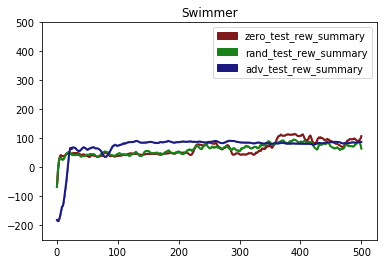

In [13]:
plot_tests = [const_test_rew_summary, rand_test_rew_summary, adv_test_rew_summary]
plot_names = ['zero_test_rew_summary', 'rand_test_rew_summary', 'adv_test_rew_summary']
plot_colors = [(0.5,0.1,0.1), (0.1,0.5,0.1), (0.1,0.1,0.5)]
all_patches = []
for i in range(len(plot_tests)):
    con_rew = np.array(plot_tests[i])
    mean_con = con_rew.mean(0)
    std_con = con_rew.std(0)
    if if_filtering==True:
        mean_window_size = 15
        mean_order = 3
        std_window_size = 45
        std_order = 2
        mean_con = scipy.signal.savgol_filter(mean_con, mean_window_size, mean_order)
        std_con = scipy.signal.savgol_filter(std_con, std_window_size, std_order)
    x = [i for i in range(len(mean_con))]
    plt.plot(x,mean_con,color=plot_colors[i], linewidth=2.0)
    plt.fill_between(x, mean_con-std_con, mean_con+std_con,color=plot_colors[i], alpha=0.5)
    all_patches.append(mpatches.Patch(color=plot_colors[i], label=plot_names[i]))

plt.legend(handles=all_patches)
axes = plt.gca()
axes.set_ylim([-250,500])
plt.title("Swimmer")
plt.show()